In [1]:
# Install torchaudio
!pip install torchaudio==0.9.1 -q
import librosa
import torchaudio
from torchaudio import transforms

     |████████████████████████████████| 1.9 MB 3.6 MB/s 
     |████████████████████████████████| 831.4 MB 2.7 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.


In [2]:
import datetime
import os

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

import numpy as np
import pandas as pd

from collections import Counter, defaultdict, OrderedDict

from sklearn.metrics import precision_score, f1_score, recall_score, classification_report, confusion_matrix, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Consider ragas that have at least 10 samples.
RAGAM_MIN_COUNT = 10

In [5]:
data = pd.read_json('/content/drive/MyDrive/song_lyric_map.json')
adata = pd.read_json('/content/drive/MyDrive/mp3_data_genres.json')

In [6]:
AUD_PATH = '/content/drive/MyDrive/Annamayya'
data['exists'] = data.apply(lambda x:os.path.exists(os.path.join(AUD_PATH,x['MP3 File'])),axis=1)
data = data[data.exists]

In [7]:
def get_offset(adata, id):
  l = adata[adata.Samputi==id]['Offset'].tolist()
  return 60 if len(l) == 0 else l[0]
data['Offset'] = data.apply(lambda x:get_offset(adata, x.Samputi), axis=1)

data['Offset'].fillna(60,inplace=True)

In [8]:
all_samples = data.Ragam.value_counts().index
low_samples = all_samples[data.Ragam.value_counts()<RAGAM_MIN_COUNT]
# Drop these rows.
for s in low_samples:
  data = data[data.Ragam!=s]

In [9]:
le = LabelEncoder()
le.fit_transform(data['Ragam'])
data['RagamCode'] = data.apply(lambda x:le.transform([x.Ragam])[0],axis=1)
n_labels = len(data['RagamCode'].unique())

In [10]:
data['Ragam'].value_counts()

లలిత            98
సాళంగనాట        94
సామంతం          89
బౌళి            70
శంకరాభరణం       68
శ్రీరాగం        65
రామక్రియ        61
ముఖారి          55
పాడి            50
ఆహిరి           45
దేసాళం          40
దేవగాంధారి      35
శుద్ధవసంతం      33
భూపాలం          32
దేసాక్షి        29
గుండుక్రియ      28
భైరవి           27
నాట             25
వరాళి           22
మలహరి           20
ధన్నాసి         20
కాంబోది         19
మాళవి           18
మాళవిగౌళ        18
గుజ్జరి         15
కన్నడగౌళ        15
గౌళ             14
బౌళిరామక్రియ    13
సాళంగం          11
నాదరామక్రియ     11
Name: Ragam, dtype: int64

In [11]:
print(f'Unique Ragas : {n_labels}')

Unique Ragas : 30


ఆహిరి : [0]
కన్నడగౌళ : [1]
కాంబోది : [2]
గుండుక్రియ : [3]
గుజ్జరి : [4]
గౌళ : [5]
దేవగాంధారి : [6]
దేసాక్షి : [7]
దేసాళం : [8]
ధన్నాసి : [9]
నాట : [10]
నాదరామక్రియ : [11]
పాడి : [12]
బౌళి : [13]
బౌళిరామక్రియ : [14]
భూపాలం : [15]
భైరవి : [16]
మలహరి : [17]
మాళవి : [18]
మాళవిగౌళ : [19]
ముఖారి : [20]
రామక్రియ : [21]
లలిత : [22]
వరాళి : [23]
శంకరాభరణం : [24]
శుద్ధవసంతం : [25]
శ్రీరాగం : [26]
సామంతం : [27]
సాళంగం : [28]
సాళంగనాట : [29]


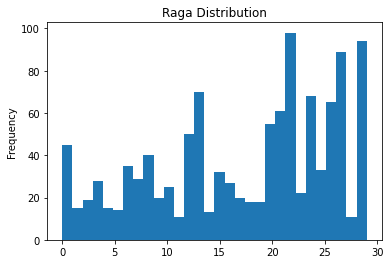

In [12]:
for c in le.classes_: print(f'{c} : {le.transform([c])}')
data['RagamCode'].plot.hist(bins=n_labels)
plt.title('Raga Distribution')
plt.show()

In [13]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [14]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight(class_weight = 'balanced',
                                         classes = np.unique(labels),
                                         y = labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [15]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores

In [16]:
def update_results_dict(results, train_labels, train_predictions, test_labels, test_predictions, s='micro'):
    results['train_precision'].append(precision_score(train_labels, train_predictions,average=s))
    results['train_recall'].append(recall_score(train_labels, train_predictions,average=s))
    results['train_f1'].append(f1_score(train_labels, train_predictions,average=s))
    results['validation_precision'].append(precision_score(test_labels, test_predictions,average=s))
    results['validation_recall'].append(recall_score(test_labels, test_predictions,average=s))
    results['validation_f1'].append(f1_score(test_labels, test_predictions,average=s))
    return results

In [17]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
  predict = lambda model, data, hidden: model(data, hidden) if hidden else model(data)
  hid = lambda model, data, run_on, lstm_model: model.init_hidden(data.shape[0], run_on) if lstm_model else None
  if is_training:
      model.train()
  else:
      model.eval()
  total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
  for step, batch in enumerate(dataset):
      if step % report_at == 0 and not step == 0:
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataset)))
      # push the batch to gpu
      batch = [r.to(run_on) for r in batch]        
      aud_data, labels = batch
      h = hid(model, aud_data, run_on, lstm_model)
      if is_training:
          for o in optimizer: o.zero_grad()
          model.zero_grad()
          predictions = predict(model, aud_data, h)
      else:
          with torch.no_grad():
            predictions = predict(model, aud_data, h)
      # compute the loss between actual and predicted values
      loss = loss_fcn(predictions, labels)
      predictions = predictions.detach().cpu().numpy()
      total_loss = total_loss + loss.item()
      if is_training:
          loss.backward()  # backward pass to calculate the gradients
          if clip_at: torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
          # update parameters
          for o in optimizer: o.step()
      # append the model predictions
      model_predictions.append(predictions)
      model_labels.append(labels.detach().cpu().numpy())
      del batch
  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataset)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  model_predictions = np.concatenate(model_predictions, axis=0)
  model_labels = np.concatenate(model_labels, axis=0)
  # returns the loss and predictions
  model_predictions = np.argmax(model_predictions, axis=1)
  return avg_loss, model_predictions, model_labels, model

In [18]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'
    legend_labels = ['Train', 'Val']

    def subplot_routine(key1, key2, title, loss=False):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        plt.grid()
        plt.xlabel(x_label)
        plt.legend([f'{x} {title}' for x in legend_labels])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    gs = GridSpec(2, 3, figure=fig)
    plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2, 3, 4)
    subplot_routine('train_precision', 'validation_precision', 'Precision')
    plt.subplot(2, 3, 5)
    subplot_routine('train_recall', 'validation_recall', 'Recall')
    plt.subplot(2, 3, 6)
    subplot_routine('train_f1', 'validation_f1', 'F1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [19]:
class AbsDataset(IterableDataset):
  def __init__(self):
    super().__init__()
  
  def get_data_loader(self, batch_size=32, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(self, batch_size=batch_size, generator=g)

In [20]:
def train_model(data, prepare_data_hnd, gpu, **kwargs):
  torch.manual_seed(42)
  start_time = datetime.datetime.now()

  n_labels = kwargs['n_labels']
  title = kwargs['title']
  report = kwargs['report'] if 'report' in kwargs else 20
  lstm = kwargs['lstm'] if 'lstm' in kwargs else False
  lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
  clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
  k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
  balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
  dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.25
  plot = kwargs['plot'] if 'plot' in kwargs else True
  epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
  mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
  feature = kwargs['feature'] if 'feature' in kwargs else ['mfcc_mean']
  target = kwargs['target'] if 'target' in kwargs else 'RagamCode'
  
  k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
  results = {x: {} for x in range(k_folds)}
  labels = data[target]
  ovl_best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
  for fold, (train_ids, test_ids) in enumerate(k_fold.split(data[feature], data[target])):
    print(f'FOLD {fold + 1} \n Data Sizes (Train/Test) : {len(train_ids)}/{len(test_ids)}')
    fold_start = datetime.datetime.now()
    # empty lists to store training and validation loss of each epoch
    train_losses, valid_losses = [], []
    best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
    # for each epoch
    results[fold] = {
        'train_f1': [],
        'validation_f1': [],
        'train_precision': [],
        'validation_precision': [],
        'train_recall': [],
        'validation_recall': []
    }
    train_data, test_data, train_lbls, test_lbls = prepare_data_hnd(data, train_ids, test_ids)
    model = kwargs['model'](n_labels,dropout=dropout,**mdlargs)
    model.to(gpu)
    loss_fcn = get_loss_function(balance_classes, data[target].tolist(), gpu, nn.CrossEntropyLoss)
    # define the optimizer
    optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
    lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3,factor=0.1,threshold=1e-9,mode='min'),
                     ExponentialLR(optimizer[0],gamma=0.9)]
    for epoch in range(epochs):
        e_start = datetime.datetime.now()
        # train model
        train_loss, train_predictions, train_labels, model = run_model(model, train_data.get_data_loader(batch_size=32),
                                                                        loss_fcn, optimizer, run_on=gpu,
                                                                        is_training=True, clip_at=clip_at,
                                                                       lstm_model=lstm, report_at=report)
        # evaluate model
        valid_loss, test_predictions, test_labels, model = run_model(model, test_data.get_data_loader(batch_size=32),
                                                                      loss_fcn, optimizer, run_on=gpu,
                                                                      is_training=False, clip_at=clip_at,
                                                                     lstm_model=lstm, report_at=report)
        for lr_scheduler in lr_schedulers:
            lr_scheduler.step(valid_loss)
        torch.cuda.empty_cache()
        # save the best model
        best_scores = update_best_result(best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions,
                                          model=model,
                                          model_file_name=f'saved_weights_Fold_{fold}.pt')
        ovl_best_scores = update_best_result(ovl_best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions)
        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        results[fold] = update_results_dict(results[fold],
                                            train_labels, train_predictions,
                                            test_labels, test_predictions)
        e_end = datetime.datetime.now()
        print(f'Epoch {epoch+1}/{epochs} : Training Loss: {train_loss:.3f} / Validation Loss : {valid_loss:.3f} [Time Taken : {(e_end - e_start).total_seconds()} seconds]')
    print('*** Confusion Matrix - Training ***')
    print(confusion_matrix(best_scores['train_labels'],best_scores['train_predictions']))
    print('*** Confusion Matrix - Validation ***')
    print(confusion_matrix(best_scores['test_labels'],best_scores['test_predictions']))
    results[fold]['train_losses'] = train_losses
    results[fold]['validation_losses'] = valid_losses
    print(f'Fold {fold+1} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
  end_time = datetime.datetime.now()
  print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
  print('*** Confusion Matrix - Training ***')
  print(confusion_matrix(ovl_best_scores['train_labels'],ovl_best_scores['train_predictions']))
  print('*** Confusion Matrix - Validation ***')
  print(confusion_matrix(ovl_best_scores['test_labels'],ovl_best_scores['test_predictions']))
  if plot: plot_results(results, title)
  return results

In [21]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by='validation_f1', ascending=False, inplace=True)
    return p

# OVR Experiment 1 - Chroma Feed Forward

In [22]:
DURATION = 120
FREQ = 16000
def get_chroma(offset, aud_path, a_path):
  aud_path = os.path.join(aud_path, a_path)
  i = torchaudio.info(aud_path)
  waveform, sample_rate = torchaudio.load(aud_path, num_frames=int(DURATION*i.sample_rate), 
                                          frame_offset=int(offset*i.sample_rate))
  waveform = librosa.to_mono(waveform)
  if len(waveform) > 0 :
    resampler = transforms.Resample(sample_rate, FREQ)
    waveform = resampler(torch.tensor(waveform))
    chroma = librosa.feature.chroma_stft(waveform.numpy(), FREQ, n_fft=4096, hop_length=1024)
  else:
    chroma = []
  return torch.tensor(chroma)
data['chroma'] = data.apply(lambda x:get_chroma(x.Offset, AUD_PATH, x['MP3 File']),axis=1)
data = data[data.apply(lambda x:len(x['chroma'].shape)==2,axis=1)]

In [23]:
class ChromaDataset(AbsDataset):
    def __init__(self, labels, chroma):
        super().__init__()
        self.labels = labels
        self.chroma = chroma

    def __get__(self,index):
      if self.chroma[index].shape[1] < 1876:
        self.chroma[index] = torch.hstack((self.chroma[index],torch.zeros(12,1876-self.chroma[index].shape[1])))
      return self.chroma[index].reshape((1,)+self.chroma[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['chroma'].iloc[x] for x in train_ids]
      test_vals = [data['chroma'].iloc[x] for x in test_ids]
      train_data = ChromaDataset(train_lbls, train_vals)
      test_data = ChromaDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [24]:
class ChromaRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.height = 12
        self.width = 1876
        # Fully connected audio layer with Chromagram 12x1876 (120secs)
        pool_kernel = 2
        kernel = (2,2)
        self.layers1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Flatten()
        )
        self.final = nn.Linear(22512,n_labels)
        
    def forward(self,x):
        x = self.layers1(x)
        x = self.final(x)
        return x

In [25]:
def ovr_train_model(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, target='RagamCode', feature='mfcc', lr=5e-3,
                    lstm=False, dropout=0.1, epochs=15, n_folds=2):
  results = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if lbl_encoder: 
      lbl = lbl_encoder.inverse_transform([i])
      print(f'Training for {lbl} with {nsamples} positive samples')
    else:
      lbl = i
    ndata = pd.DataFrame()
    ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
    ndata[feature] = data[feature]
    results[i] = train_model(ndata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : lstm,
                                   'lr' : lr,
                                   'clip_at' : None,
                                   'k_folds' : n_folds,
                                   'balance_classes' : True,
                                   'dropout' : dropout,
                                   'title' : title,
                                   'plot' : True,
                                   'epochs' : epochs,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target})
    print(results_to_df(results[i]))
  return results

Training for ['ఆహిరి'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.52056673 12.65555556]
Epoch 1/15 : Training Loss: 0.808 / Validation Loss : 0.665 [Time Taken : 0.480607 seconds]
Epoch 2/15 : Training Loss: 0.635 / Validation Loss : 0.661 [Time Taken : 0.218875 seconds]
Epoch 3/15 : Training Loss: 0.588 / Validation Loss : 0.652 [Time Taken : 0.216829 seconds]
Epoch 4/15 : Training Loss: 0.509 / Validation Loss : 0.675 [Time Taken : 0.229313 seconds]
Epoch 5/15 : Training Loss: 0.423 / Validation Loss : 0.739 [Time Taken : 0.222876 seconds]
Epoch 6/15 : Training Loss: 0.328 / Validation Loss : 0.856 [Time Taken : 0.21497 seconds]
Epoch 7/15 : Training Loss: 0.236 / Validation Loss : 0.925 [Time Taken : 0.215947 seconds]
Epoch 8/15 : Training Loss: 0.147 / Validation Loss : 1.110 [Time Taken : 0.216664 seconds]
Epoch 9/15 : Training Loss: 0.083 / Validation Loss : 1.316 [Time Taken : 0.221386 seconds]
Epoch 10/15 : Training Loss: 0.048 / Val

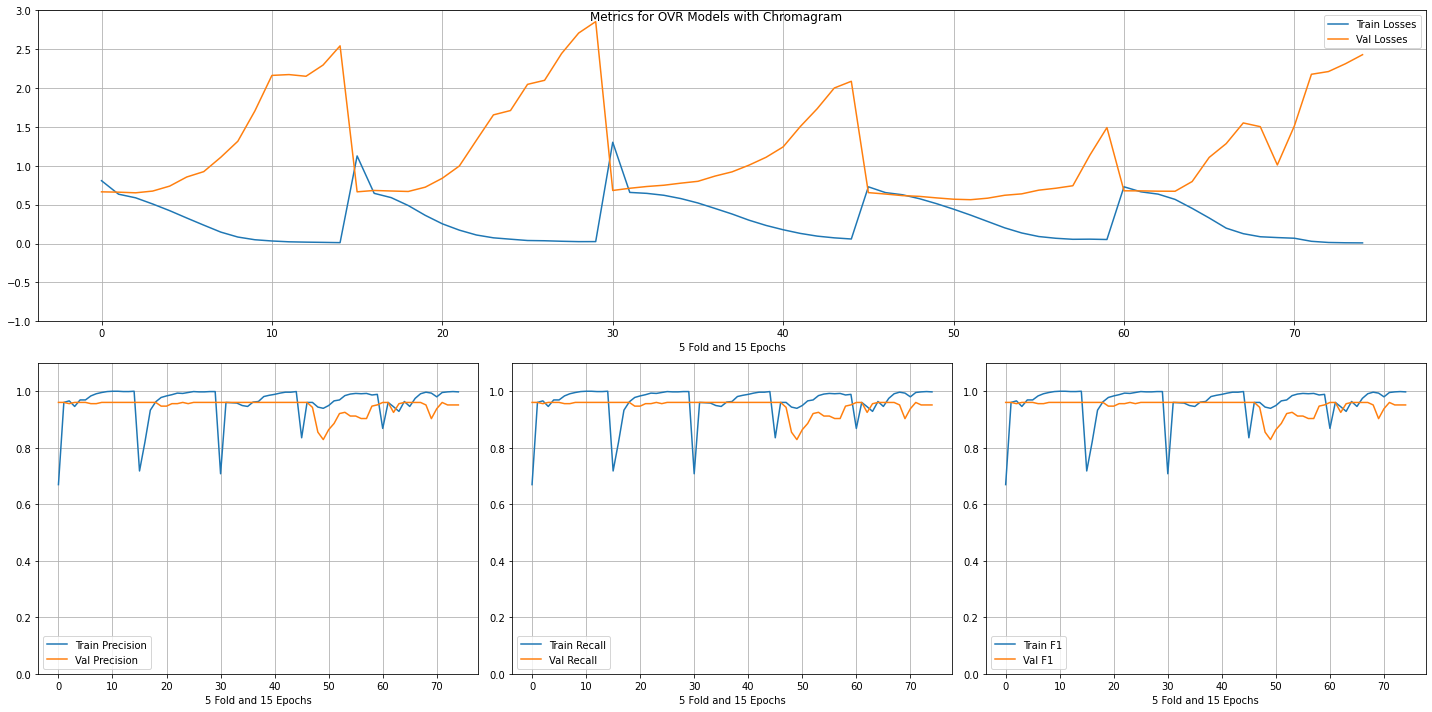

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.669594       0.960526  ...      0.808368           0.664853
6   0.961581       0.960526  ...      0.451157           0.867528
12  0.997805       0.960526  ...      0.028801           2.445314
13  0.998902       0.960526  ...      0.023986           2.708406
14  0.998902       0.960526  ...      0.024503           2.855474
..       ...            ...  ...           ...                ...
9   0.993421       0.903084  ...      0.076276           1.010910
6   0.965971       0.885965  ...      0.365419           0.563669
5   0.949506       0.864035  ...      0.441742           0.569969
3   0.944018       0.855263  ...      0.576540           0.606415
4   0.939627       0.828947  ...      0.512748           0.586966

[75 rows x 8 columns]
Training for ['కన్నడగౌళ'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.5066726  37.96666667]
Epoch 1/15 : Training Loss: 0.964 / Validation Lo

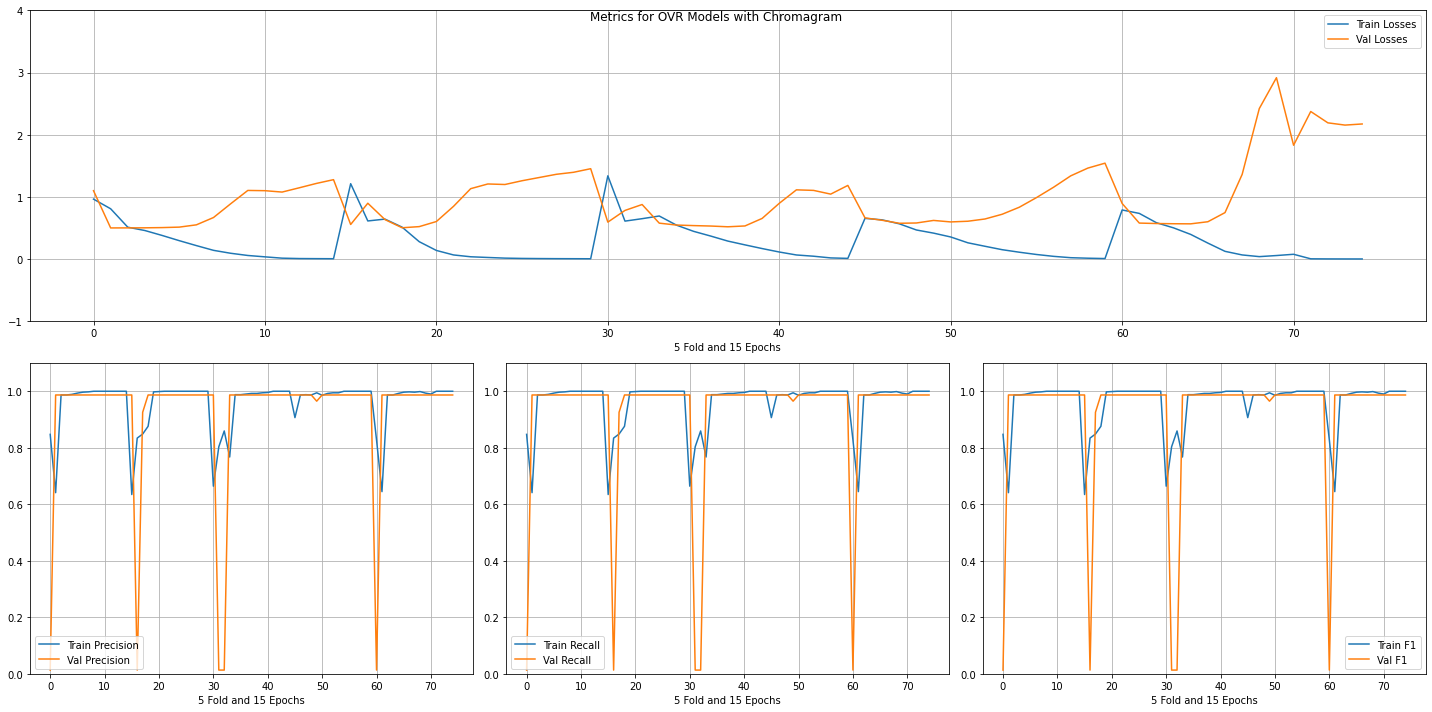

    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.992316       0.986842  ...      0.288995           0.518873
12  1.000000       0.986842  ...      0.021553           1.338324
0   0.664105       0.986842  ...      1.338848           0.593826
14  1.000000       0.986842  ...      0.007798           1.542303
3   0.767289       0.986842  ...      0.692339           0.577195
..       ...            ...  ...           ...                ...
0   0.827851       0.013216  ...      0.789696           0.893503
2   0.859495       0.013158  ...      0.649320           0.877060
1   0.803513       0.013158  ...      0.610070           0.782053
1   0.834248       0.013158  ...      0.612635           0.897803
0   0.847420       0.013158  ...      0.963999           1.099372

[75 rows x 8 columns]
Training for ['కాంబోది'] with 19 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50848214 29.97368421]
Epoch 1/15 : Training Loss: 0.732 / Validation Los

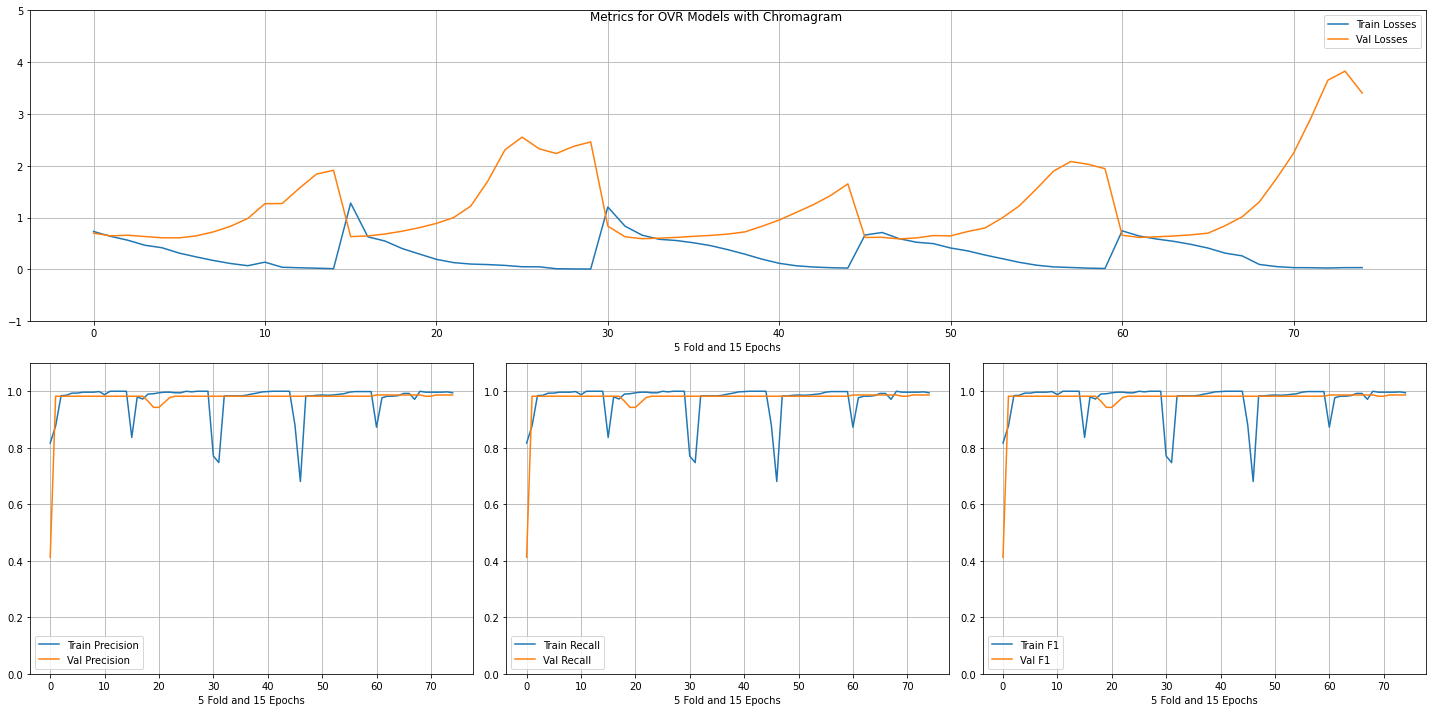

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.994518       0.986784  ...      0.034349           3.404806
6   0.992325       0.986784  ...      0.314710           0.842300
0   0.872807       0.986784  ...      0.744022           0.659367
2   0.982456       0.986784  ...      0.586827           0.628562
3   0.982456       0.986784  ...      0.542077           0.644783
..       ...            ...  ...           ...                ...
3   0.990121       0.964912  ...      0.403055           0.736905
6   0.996707       0.960526  ...      0.131140           0.999433
4   0.991218       0.942982  ...      0.297312           0.805121
5   0.994512       0.942982  ...      0.194546           0.887849
0   0.816685       0.412281  ...      0.732071           0.699959

[75 rows x 8 columns]
Training for ['గుండుక్రియ'] with 28 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51260126 20.33928571]
Epoch 1/15 : Training Loss: 0.748 / Validation 

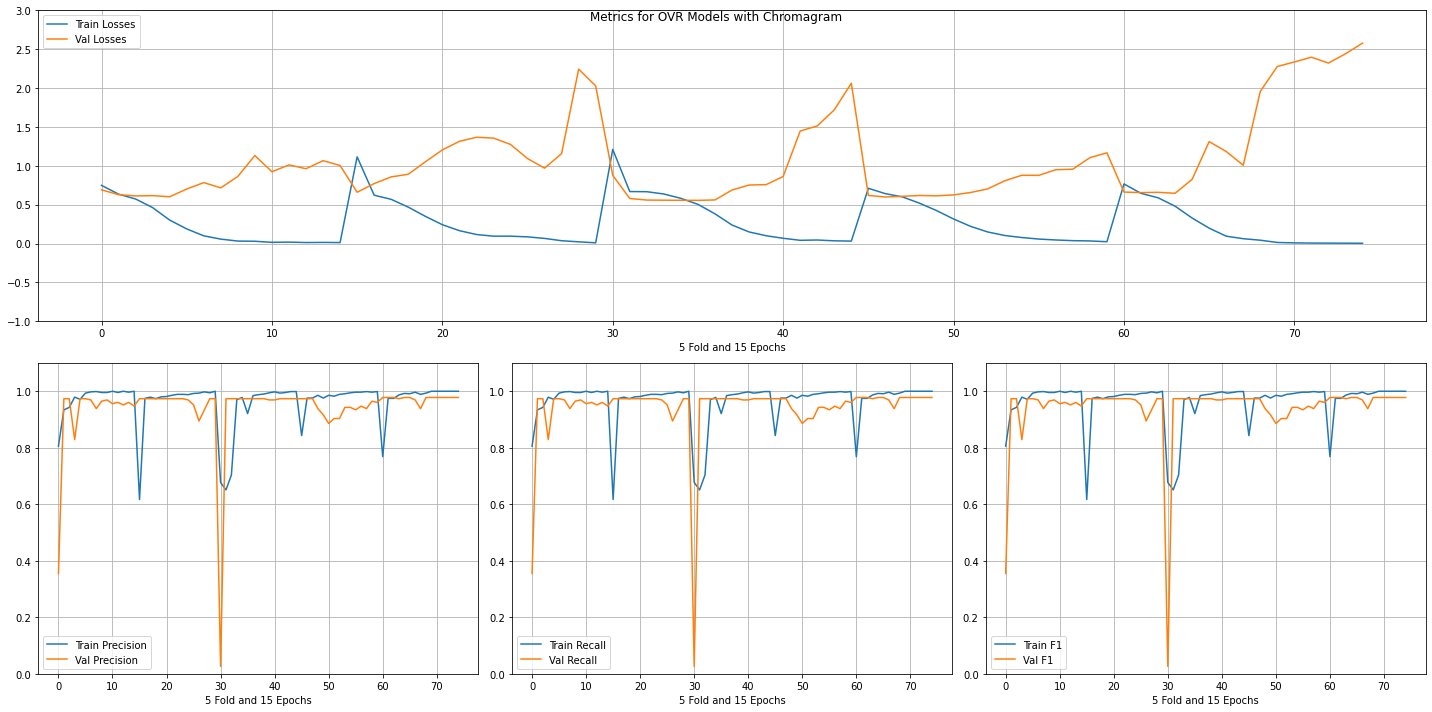

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.977974  ...      0.003090           2.578962
8   0.993421       0.977974  ...      0.042369           1.958555
0   0.768640       0.977974  ...      0.766892           0.662087
1   0.974781       0.977974  ...      0.645259           0.655250
2   0.974781       0.977974  ...      0.588628           0.658844
..       ...            ...  ...           ...                ...
11  0.993414       0.894737  ...      0.065440           0.969789
5   0.985730       0.885965  ...      0.315681           0.625630
3   0.979144       0.828947  ...      0.462114           0.616064
0   0.805708       0.355263  ...      0.748252           0.690433
0   0.677278       0.026316  ...      1.210818           0.876823

[75 rows x 8 columns]
Training for ['గుజ్జరి'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.5066726  37.96666667]
Epoch 1/15 : Training Loss: 0.794 / Validation Los

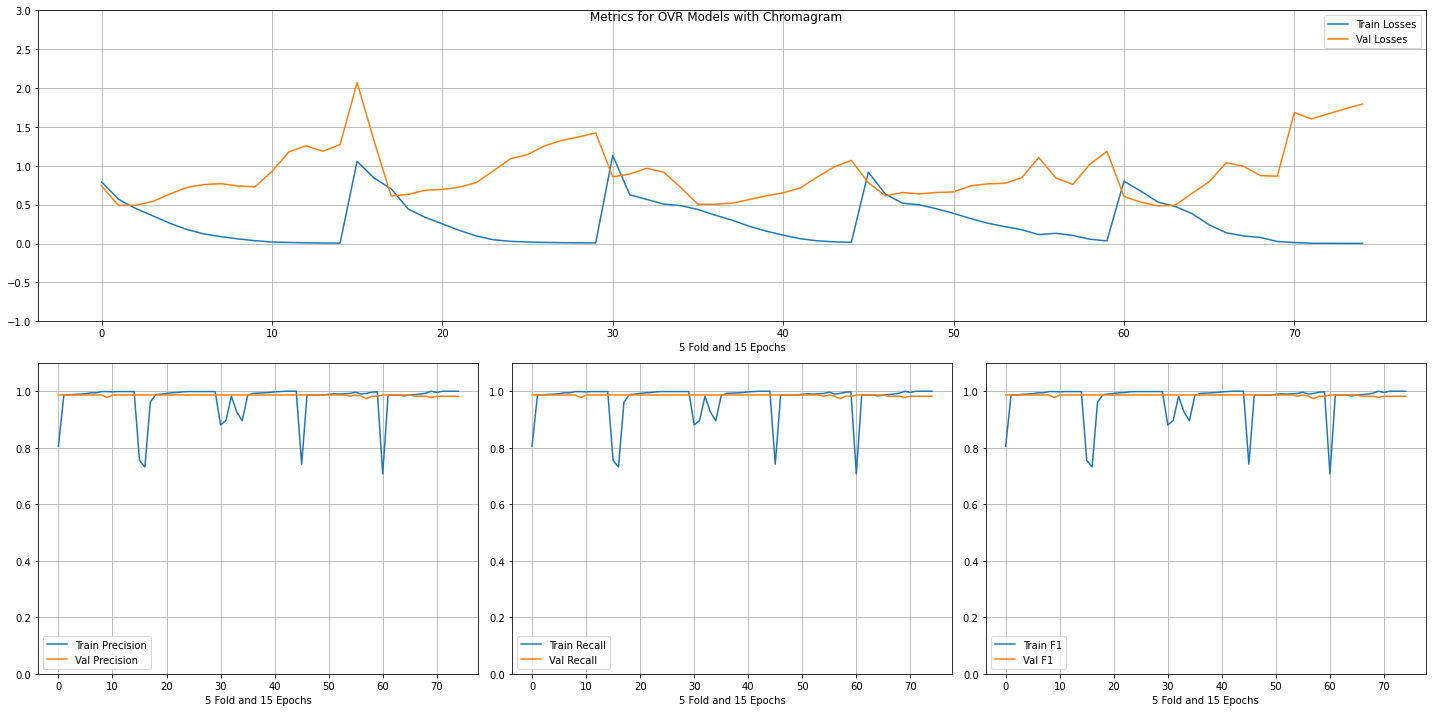

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.805708       0.986842  ...      0.794378           0.740343
13  0.998902       0.986842  ...      0.009079           1.371246
0   0.880351       0.986842  ...      1.133254           0.858306
1   0.896817       0.986842  ...      0.626915           0.895036
2   0.982437       0.986842  ...      0.567145           0.968809
..       ...            ...  ...           ...                ...
13  1.000000       0.982379  ...      0.002028           1.735151
14  1.000000       0.982379  ...      0.001862           1.794604
9   0.998902       0.978070  ...      0.036052           0.729178
9   1.000000       0.977974  ...      0.025961           0.866931
12  0.992316       0.973684  ...      0.103756           0.760905

[75 rows x 8 columns]
Training for ['గౌళ'] with 14 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50622222 40.67857143]
Epoch 1/15 : Training Loss: 0.662 / Validation Loss : 

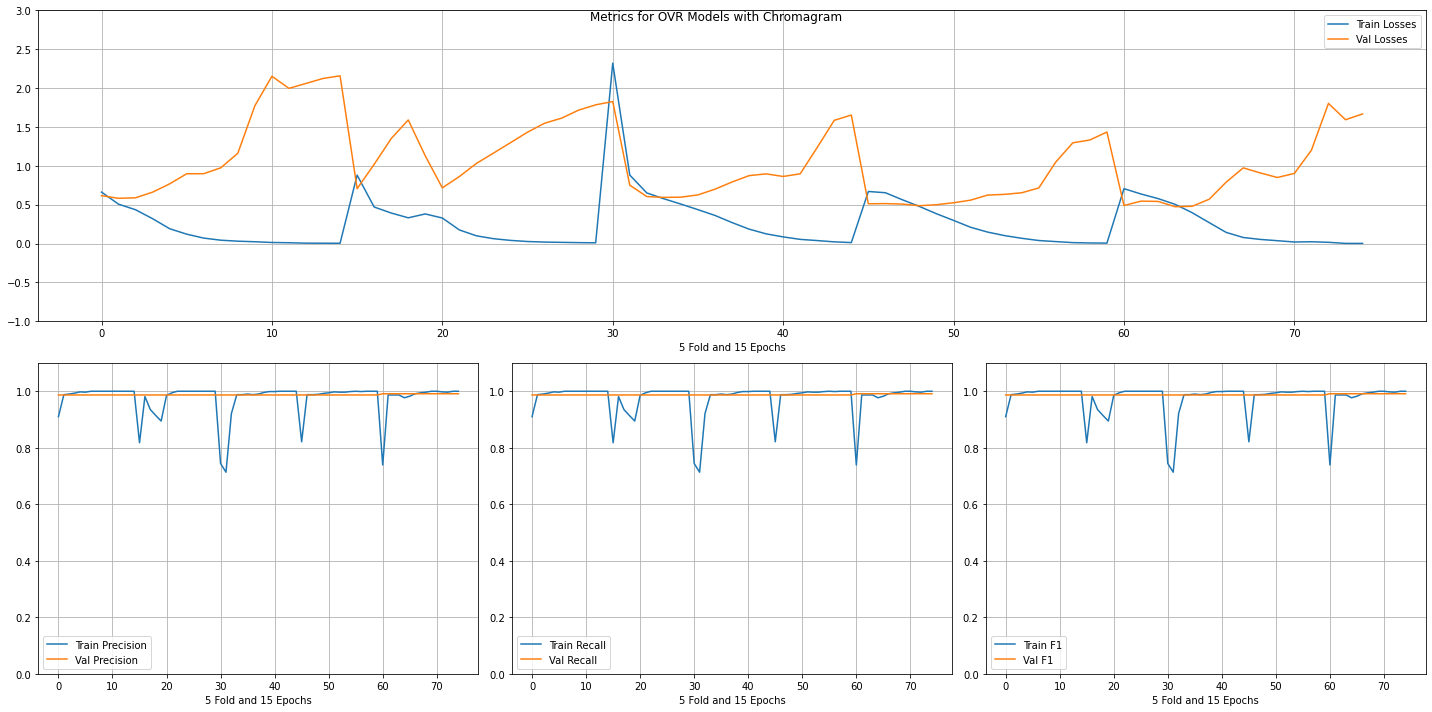

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.991189  ...      0.001155           1.667523
7   0.994518       0.991189  ...      0.077181           0.973172
0   0.739035       0.991189  ...      0.705806           0.488686
1   0.986842       0.991189  ...      0.637023           0.545227
2   0.986842       0.991189  ...      0.577973           0.541677
..       ...            ...  ...           ...                ...
9   1.000000       0.986842  ...      0.040007           1.297470
8   1.000000       0.986842  ...      0.061988           1.163171
7   1.000000       0.986842  ...      0.098890           1.030677
6   0.994512       0.986842  ...      0.174563           0.862005
7   0.990121       0.986842  ...      0.269338           0.791062

[75 rows x 8 columns]
Training for ['దేవగాంధారి'] with 35 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51585145 16.27142857]
Epoch 1/15 : Training Loss: 0.737 / Validation 

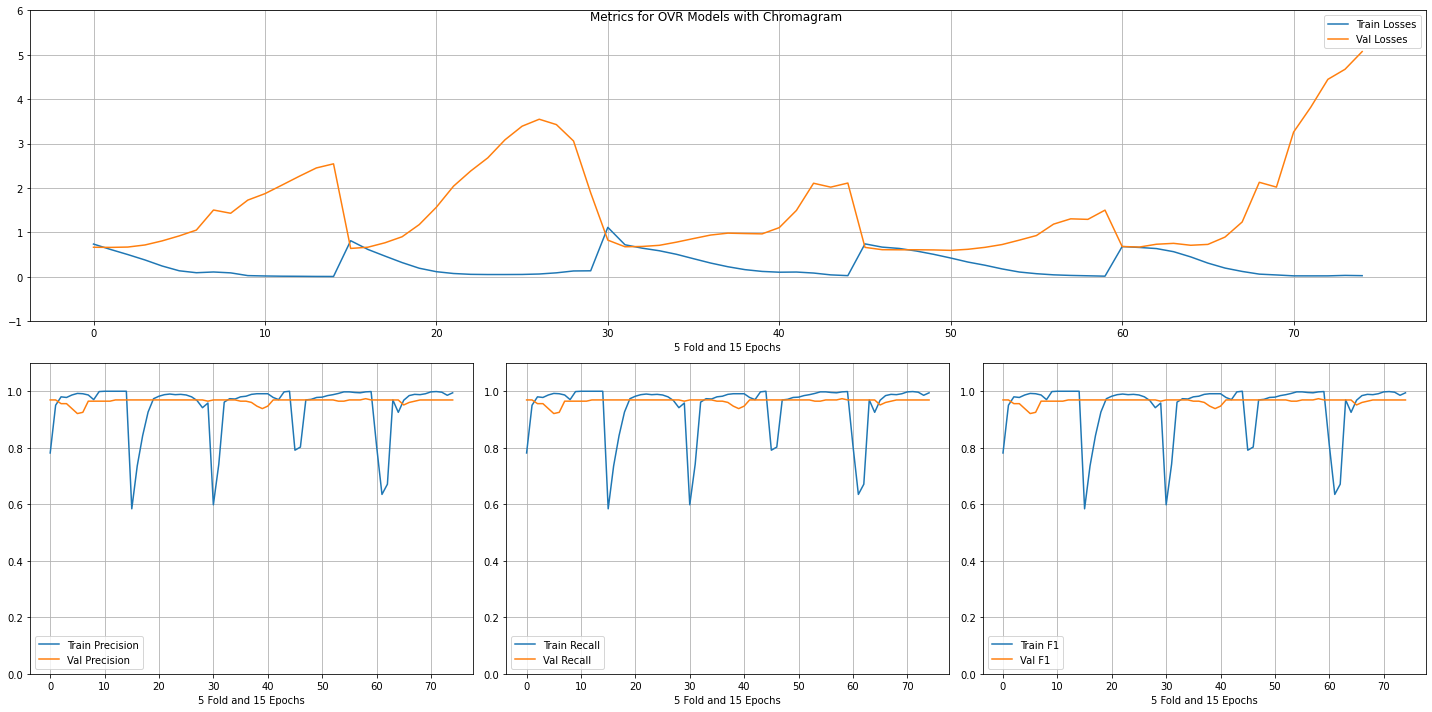

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.997805       0.973684  ...      0.022668           1.293513
0   0.781559       0.969298  ...      0.737407           0.665587
11  0.995609       0.969298  ...      0.044184           1.186167
13  0.941822       0.969298  ...      0.131358           3.058464
0   0.598244       0.969298  ...      1.113966           0.825788
..       ...            ...  ...           ...                ...
10  0.991218       0.947368  ...      0.103241           1.107683
9   0.991218       0.938596  ...      0.121050           0.966943
4   0.986828       0.938596  ...      0.243427           0.808503
6   0.991218       0.925439  ...      0.091815           1.052484
5   0.992316       0.921053  ...      0.135347           0.921219

[75 rows x 8 columns]
Training for ['దేసాక్షి'] with 29 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51306306 19.63793103]
Epoch 1/15 : Training Loss: 1.338 / Validation Lo

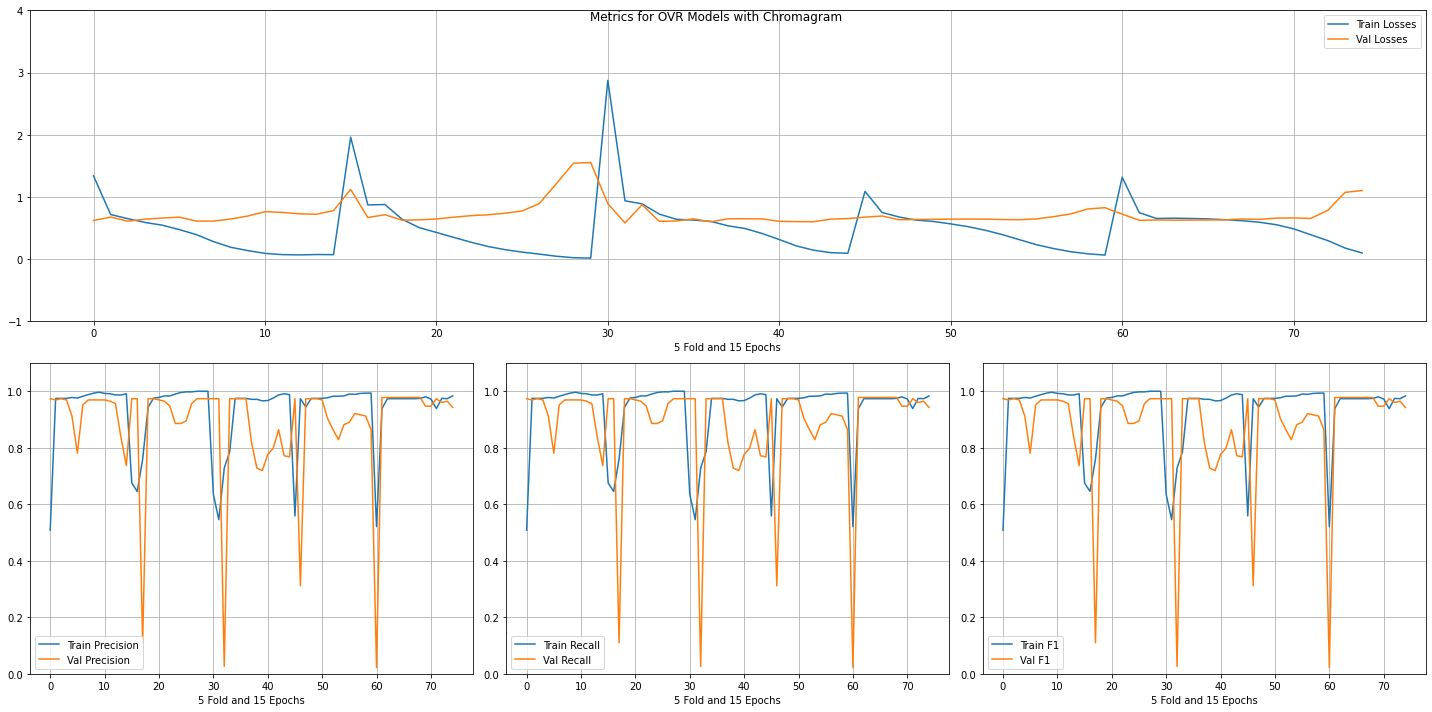

    train_f1  validation_f1  ...  train_losses  validation_losses
8   0.974781       0.977974  ...      0.592251           0.636937
3   0.973684       0.977974  ...      0.657103           0.624936
6   0.973684       0.977974  ...      0.633018           0.630544
5   0.973684       0.977974  ...      0.645829           0.628462
4   0.973684       0.977974  ...      0.652724           0.626628
..       ...            ...  ...           ...                ...
9   0.965971       0.719298  ...      0.411240           0.645163
1   0.973655       0.311404  ...      0.748735           0.692492
2   0.759605       0.109649  ...      0.876580           0.712774
2   0.727772       0.026316  ...      0.887733           0.873789
0   0.520833       0.022026  ...      1.315616           0.722550

[75 rows x 8 columns]
Training for ['దేసాళం'] with 40 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51819836 14.2375    ]
Epoch 1/15 : Training Loss: 0.732 / Validation Loss

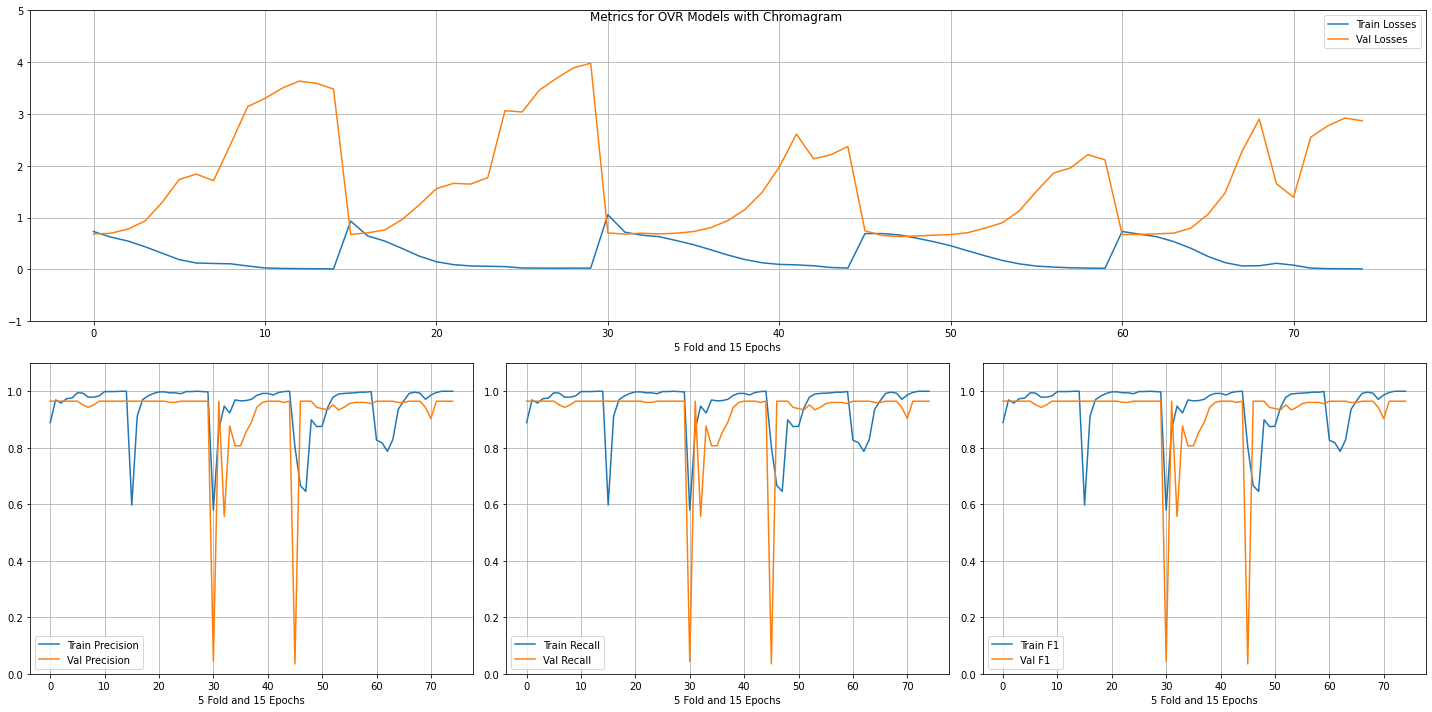

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.889133       0.964912  ...      0.731760           0.683375
3   0.983535       0.964912  ...      0.404151           0.962917
5   0.997805       0.964912  ...      0.148383           1.558484
14  1.000000       0.964912  ...      0.026302           2.372962
9   0.991218       0.964912  ...      0.053553           3.064104
..       ...            ...  ...           ...                ...
4   0.969265       0.807018  ...      0.556572           0.698690
5   0.965971       0.807018  ...      0.477171           0.730632
2   0.947311       0.557018  ...      0.660252           0.698379
0   0.579583       0.043860  ...      1.055528           0.703793
0   0.803513       0.035088  ...      0.691596           0.744080

[75 rows x 8 columns]
Training for ['ధన్నాసి'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50893655 28.475     ]
Epoch 1/15 : Training Loss: 0.918 / Validation Los

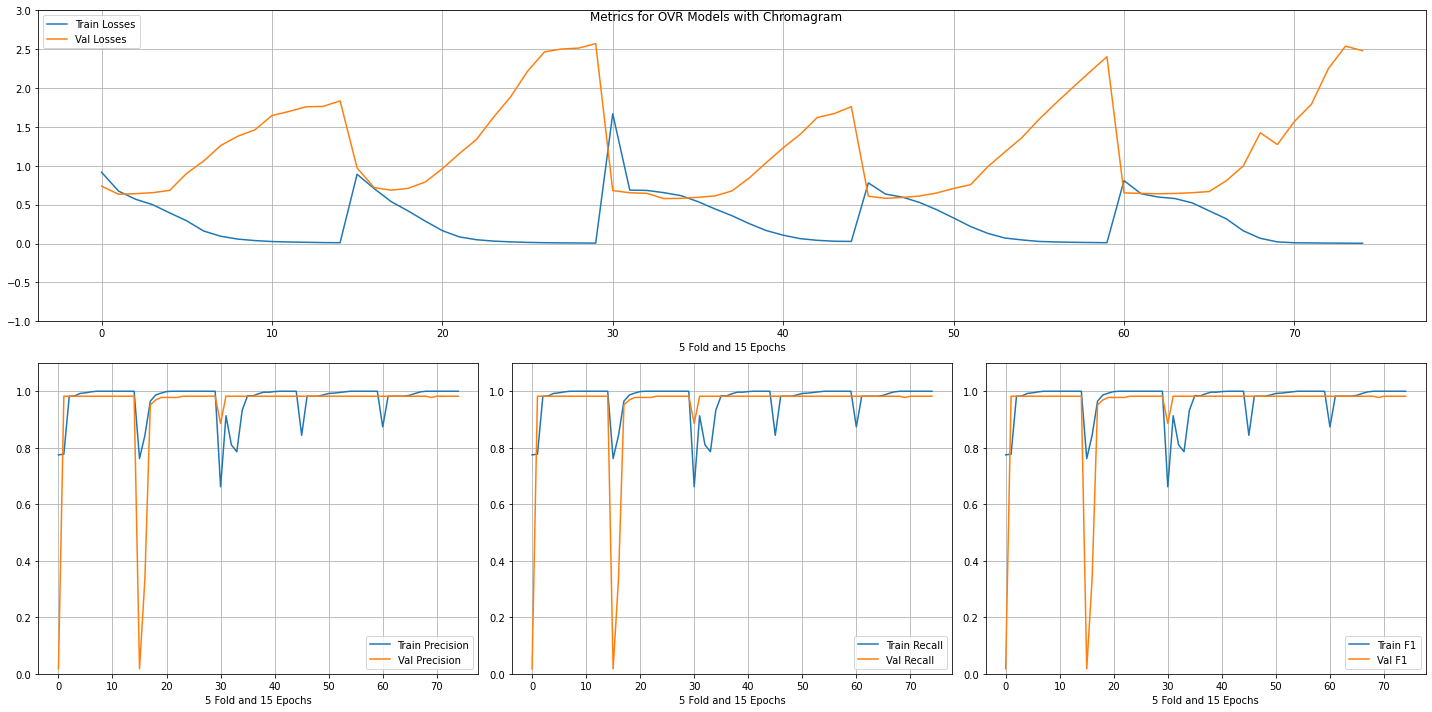

    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.991218       0.982456  ...      0.357189           0.677182
1   0.777168       0.982456  ...      0.674541           0.633712
12  1.000000       0.982456  ...      0.008024           2.503091
13  1.000000       0.982456  ...      0.006566           2.514701
14  1.000000       0.982456  ...      0.004957           2.572465
..       ...            ...  ...           ...                ...
2   0.964874       0.951754  ...      0.538546           0.685549
0   0.661910       0.885965  ...      1.669498           0.681231
1   0.844127       0.337719  ...      0.706861           0.719432
0   0.761800       0.017544  ...      0.890874           0.971308
0   0.774973       0.017544  ...      0.918115           0.738426

[75 rows x 8 columns]
Training for ['నాట'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51122083 22.78      ]
Epoch 1/15 : Training Loss: 0.896 / Validation Loss : 

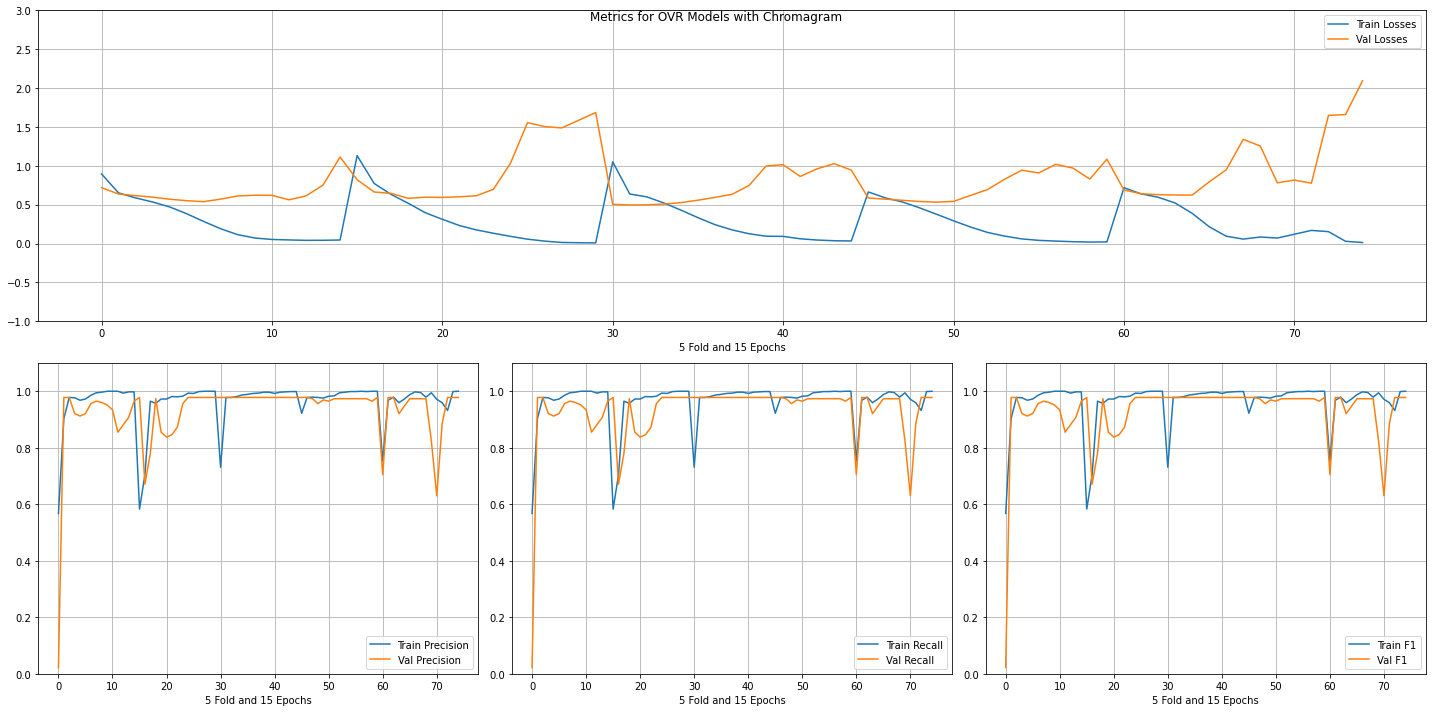

    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.993414       0.978070  ...      0.175473           0.632875
9   0.996707       0.978070  ...      0.093592           0.997206
14  1.000000       0.978070  ...      0.007987           1.685293
13  1.000000       0.978070  ...      0.009896           1.585942
12  1.000000       0.978070  ...      0.013426           1.487498
..       ...            ...  ...           ...                ...
2   0.964874       0.780702  ...      0.630987           0.645104
0   0.753289       0.704846  ...      0.717862           0.688402
1   0.704720       0.671053  ...      0.772552           0.662786
10  0.971491       0.629956  ...      0.119405           0.816689
0   0.567508       0.021930  ...      0.895959           0.718064

[75 rows x 8 columns]
Training for ['నాదరామక్రియ'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50487589 51.77272727]
Epoch 1/15 : Training Loss: 0.672 / Validation

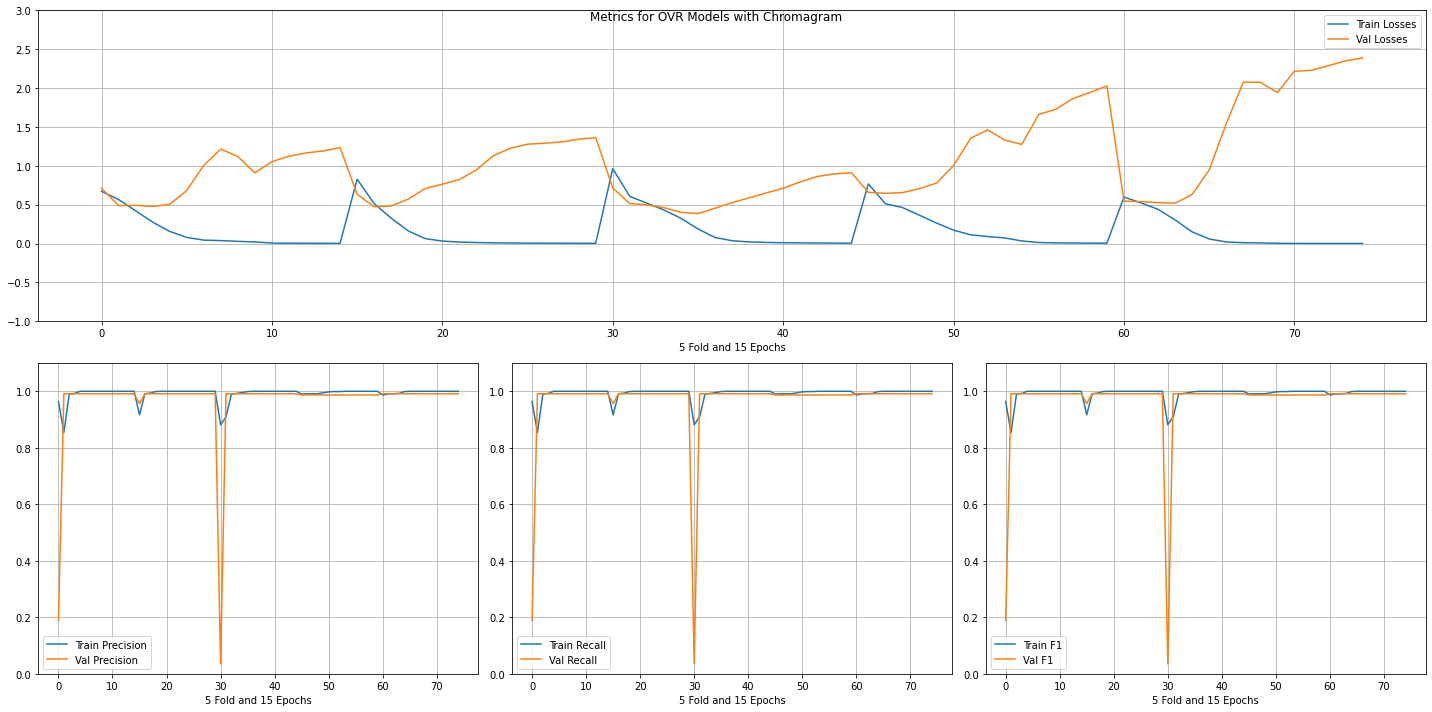

    train_f1  validation_f1  ...  train_losses  validation_losses
7   1.000000       0.991228  ...      0.035785           0.525807
7   1.000000       0.991228  ...      0.012402           0.947919
9   1.000000       0.991228  ...      0.006020           1.226528
10  1.000000       0.991228  ...      0.004659           1.278239
11  1.000000       0.991228  ...      0.003824           1.290521
..       ...            ...  ...           ...                ...
11  1.000000       0.986842  ...      0.008139           1.727444
14  1.000000       0.986842  ...      0.003686           2.027018
0   0.916575       0.956140  ...      0.827105           0.633752
0   0.963776       0.188596  ...      0.671622           0.711049
0   0.881449       0.035088  ...      0.962985           0.715187

[75 rows x 8 columns]
Training for ['పాడి'] with 49 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.52247706 11.62244898]
Epoch 1/15 : Training Loss: 0.770 / Validation Loss :

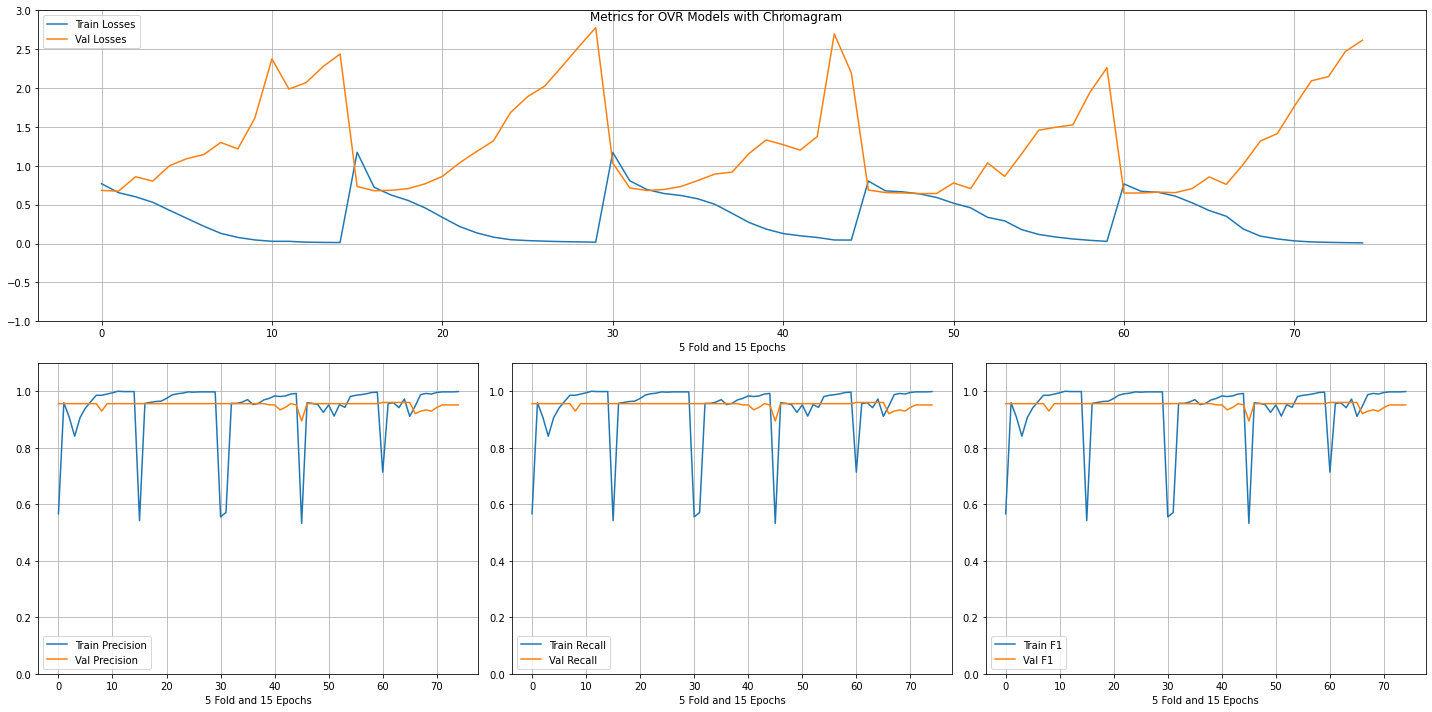

    train_f1  validation_f1  ...  train_losses  validation_losses
5   0.911184       0.960352  ...      0.424428           0.856944
4   0.972588       0.960352  ...      0.523759           0.706431
3   0.941886       0.960352  ...      0.610503           0.654171
2   0.959430       0.960352  ...      0.659210           0.660866
1   0.956140       0.960352  ...      0.672062           0.650010
..       ...            ...  ...           ...                ...
8   0.985730       0.929825  ...      0.078075           1.217220
7   0.987939       0.929515  ...      0.186844           1.018195
9   0.990132       0.929515  ...      0.059019           1.414855
6   0.947368       0.920705  ...      0.351185           0.760876
0   0.532382       0.894737  ...      0.804023           0.687898

[75 rows x 8 columns]
Training for ['బౌళి'] with 70 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.53274088 8.13571429]
Epoch 1/15 : Training Loss: 0.774 / Validation Loss : 0

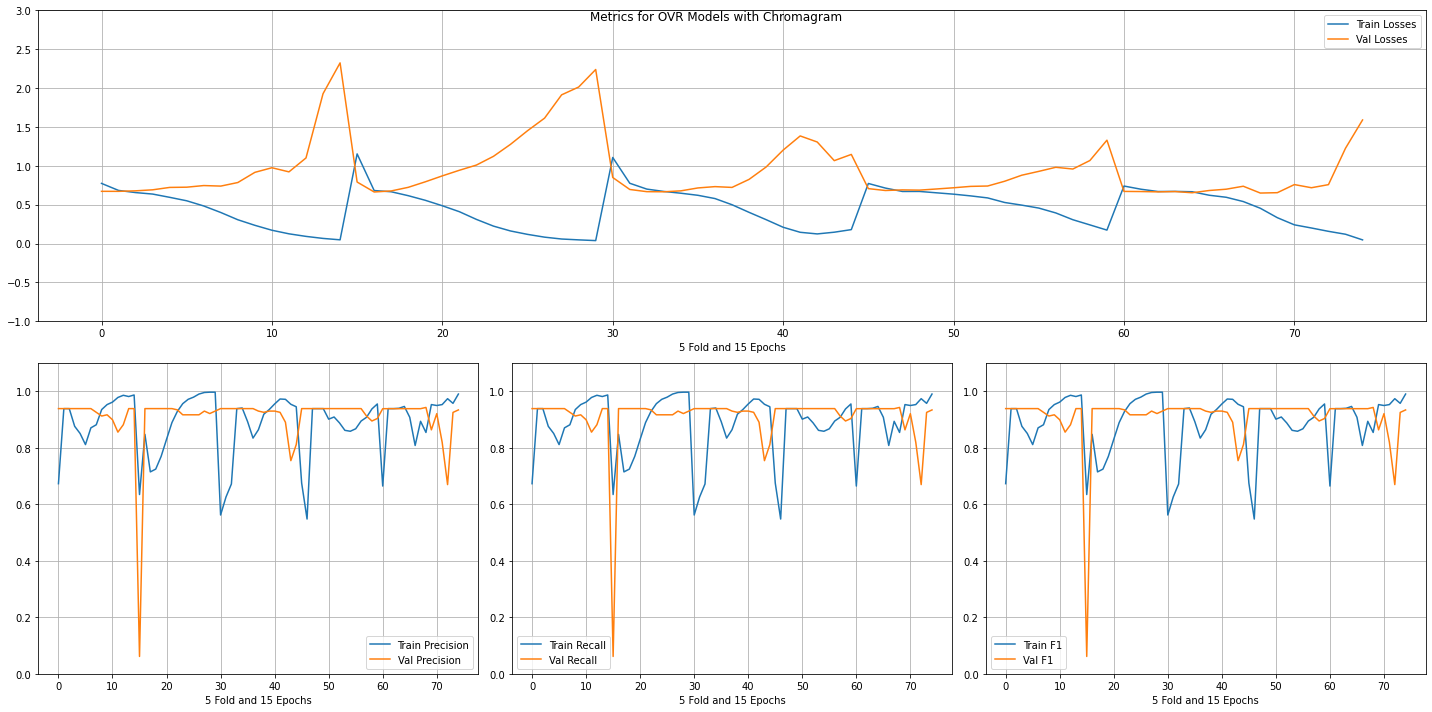

    train_f1  validation_f1  ...  train_losses  validation_losses
8   0.854167       0.942731  ...      0.453603           0.649340
0   0.672887       0.938596  ...      0.773688           0.671537
4   0.940724       0.938596  ...      0.647090           0.677723
10  0.867179       0.938596  ...      0.455928           0.928285
9   0.858397       0.938596  ...      0.493818           0.878704
..       ...            ...  ...           ...                ...
11  0.952851       0.819383  ...      0.199543           0.717745
14  0.945115       0.811404  ...      0.178613           1.146428
13  0.953897       0.754386  ...      0.145349           1.066360
12  0.973684       0.669604  ...      0.156609           0.757482
0   0.634468       0.061404  ...      1.153287           0.791096

[75 rows x 8 columns]
Training for ['బౌళిరామక్రియ'] with 13 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50577265 43.80769231]
Epoch 1/15 : Training Loss: 0.774 / Validatio

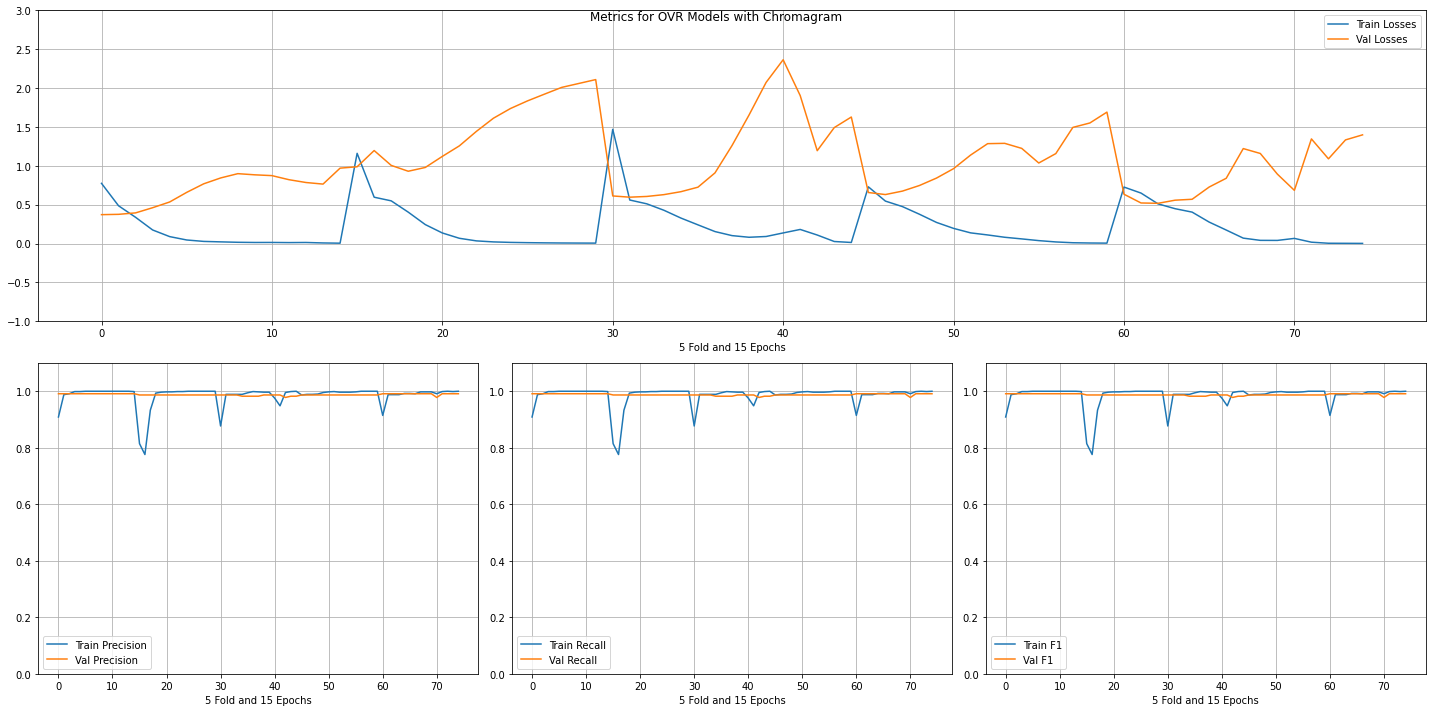

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.908891       0.991228  ...      0.774185           0.371272
8   1.000000       0.991228  ...      0.015577           0.898832
1   0.987925       0.991228  ...      0.485568           0.375363
13  1.000000       0.991228  ...      0.007104           0.764571
12  1.000000       0.991228  ...      0.013188           0.784918
..       ...            ...  ...           ...                ...
5   0.994512       0.982456  ...      0.240133           0.724772
4   0.989023       0.982456  ...      0.327505           0.666743
7   0.997805       0.982456  ...      0.101449           1.260874
12  0.995609       0.978070  ...      0.109163           1.194478
10  0.991228       0.977974  ...      0.065626           0.683976

[75 rows x 8 columns]
Training for ['భూపాలం'] with 32 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51445348 17.796875  ]
Epoch 1/15 : Training Loss: 0.852 / Validation Loss

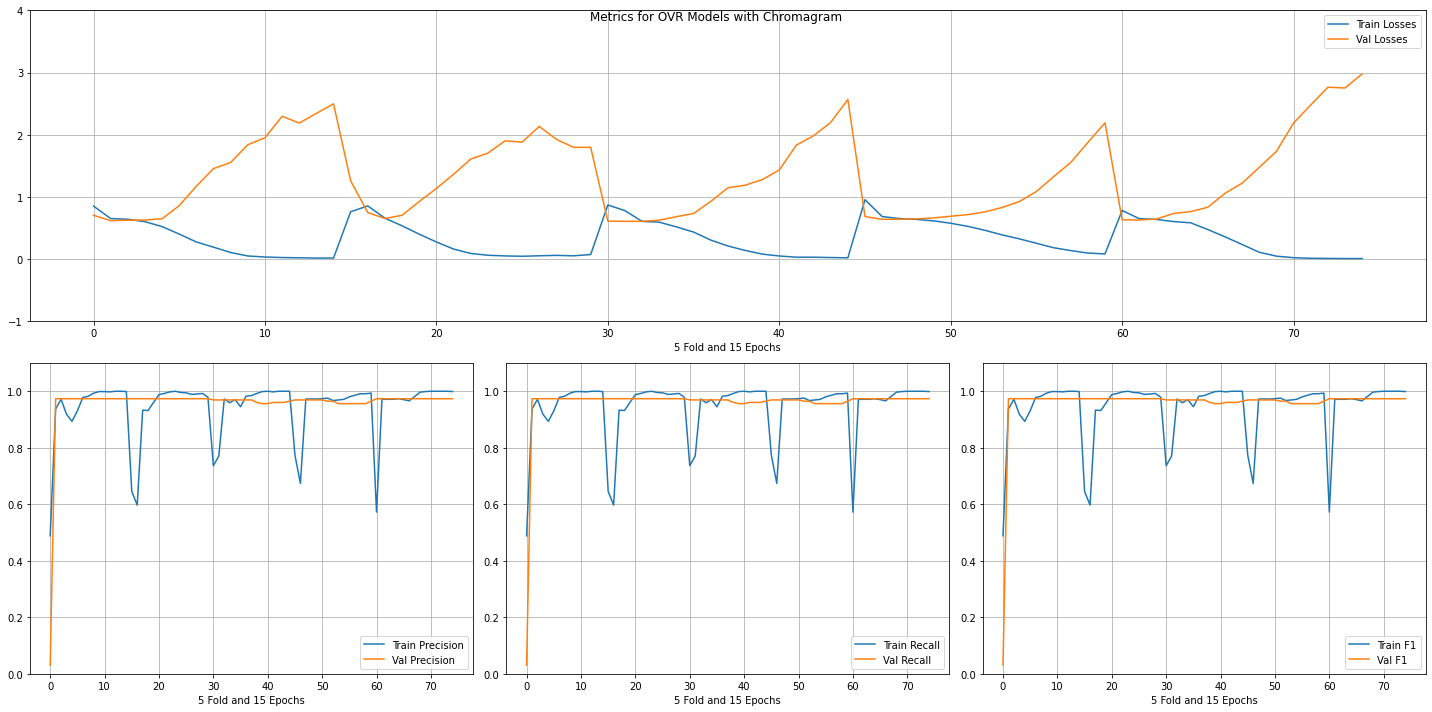

    train_f1  validation_f1  ...  train_losses  validation_losses
8   1.000000       0.973684  ...      0.060858           1.704181
0   0.645445       0.973684  ...      0.760975           1.256276
14  0.979144       0.973684  ...      0.072506           1.797275
13  0.992316       0.973684  ...      0.051799           1.797036
12  0.990121       0.973684  ...      0.059152           1.925775
..       ...            ...  ...           ...                ...
11  0.985730       0.956140  ...      0.182102           1.324382
10  0.980241       0.956140  ...      0.253808           1.086830
9   0.971460       0.956140  ...      0.324953           0.924030
8   0.969265       0.956140  ...      0.388335           0.829533
0   0.488474       0.030702  ...      0.852087           0.704272

[75 rows x 8 columns]
Training for ['భైరవి'] with 27 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51214029 21.09259259]
Epoch 1/15 : Training Loss: 0.873 / Validation Loss 

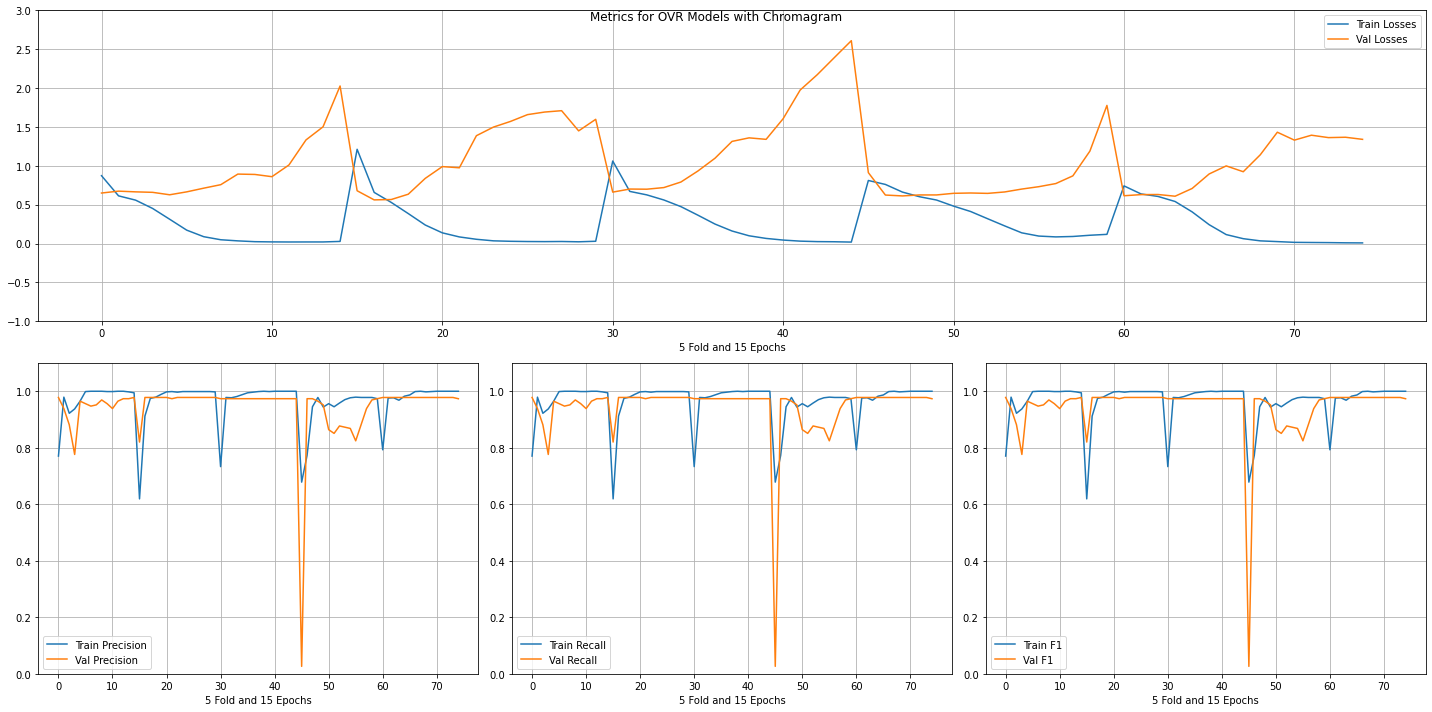

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.770582       0.978070  ...      0.872772           0.649571
14  0.994512       0.978070  ...      0.026729           2.027088
14  0.997805       0.978070  ...      0.028892           1.598208
13  0.998902       0.978070  ...      0.021903           1.449422
12  0.998902       0.978070  ...      0.025832           1.709320
..       ...            ...  ...           ...                ...
6   0.945115       0.850877  ...      0.411824           0.649963
10  0.979144       0.824561  ...      0.095675           0.731154
0   0.619100       0.820175  ...      1.212429           0.678980
3   0.937431       0.776316  ...      0.450943           0.658447
0   0.678375       0.026316  ...      0.811018           0.911889

[75 rows x 8 columns]
Training for ['మలహరి'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50893655 28.475     ]
Epoch 1/15 : Training Loss: 0.791 / Validation Loss 

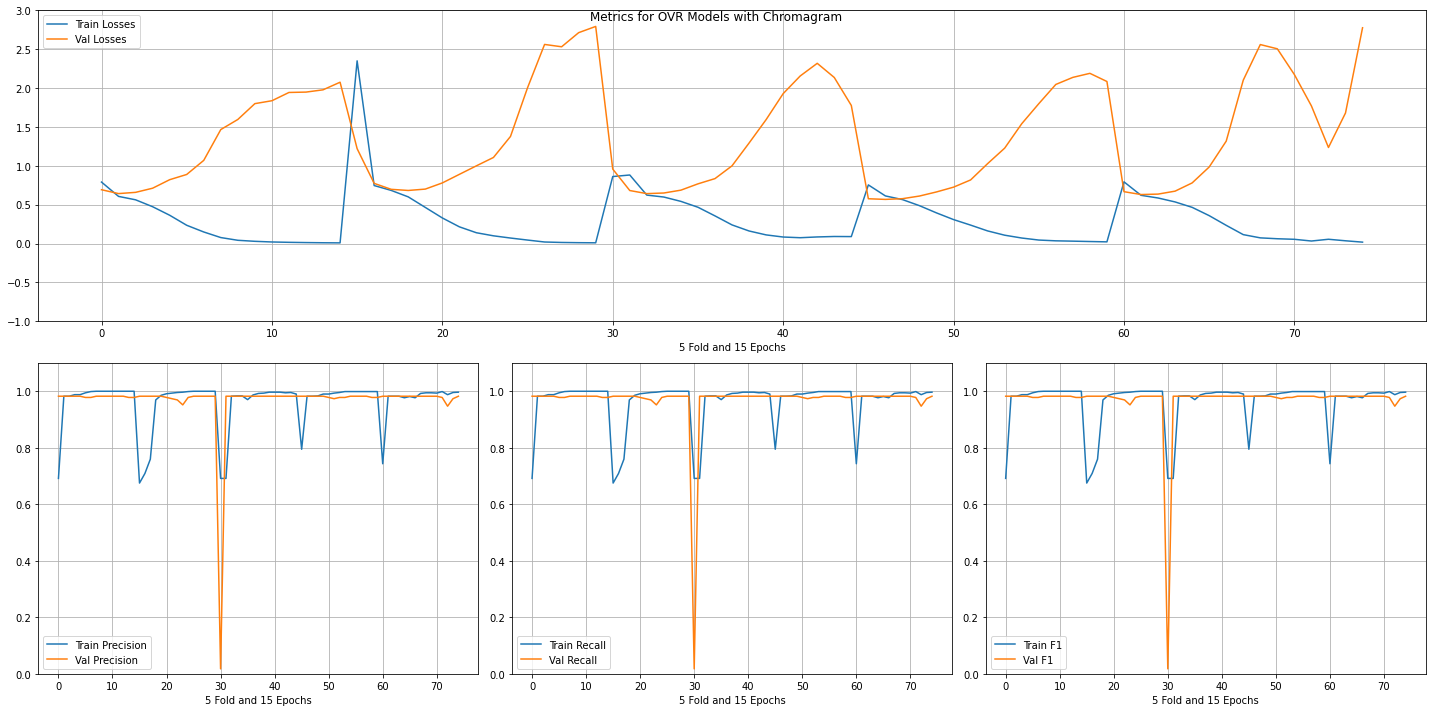

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.691548       0.982456  ...      0.790605           0.692121
11  0.996707       0.982456  ...      0.074442           2.155894
14  1.000000       0.982456  ...      0.008887           2.793554
1   0.691548       0.982456  ...      0.881591           0.681695
2   0.982437       0.982456  ...      0.622941           0.641859
..       ...            ...  ...           ...                ...
13  0.995614       0.973568  ...      0.034929           1.679899
7   0.995609       0.969298  ...      0.138441           0.999626
8   0.996707       0.951754  ...      0.098904           1.107202
12  0.987939       0.947137  ...      0.054540           1.235724
0   0.691548       0.017544  ...      0.861722           0.957883

[75 rows x 8 columns]
Training for ['మాళవి'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50802855 31.63888889]
Epoch 1/15 : Training Loss: 0.776 / Validation Loss 

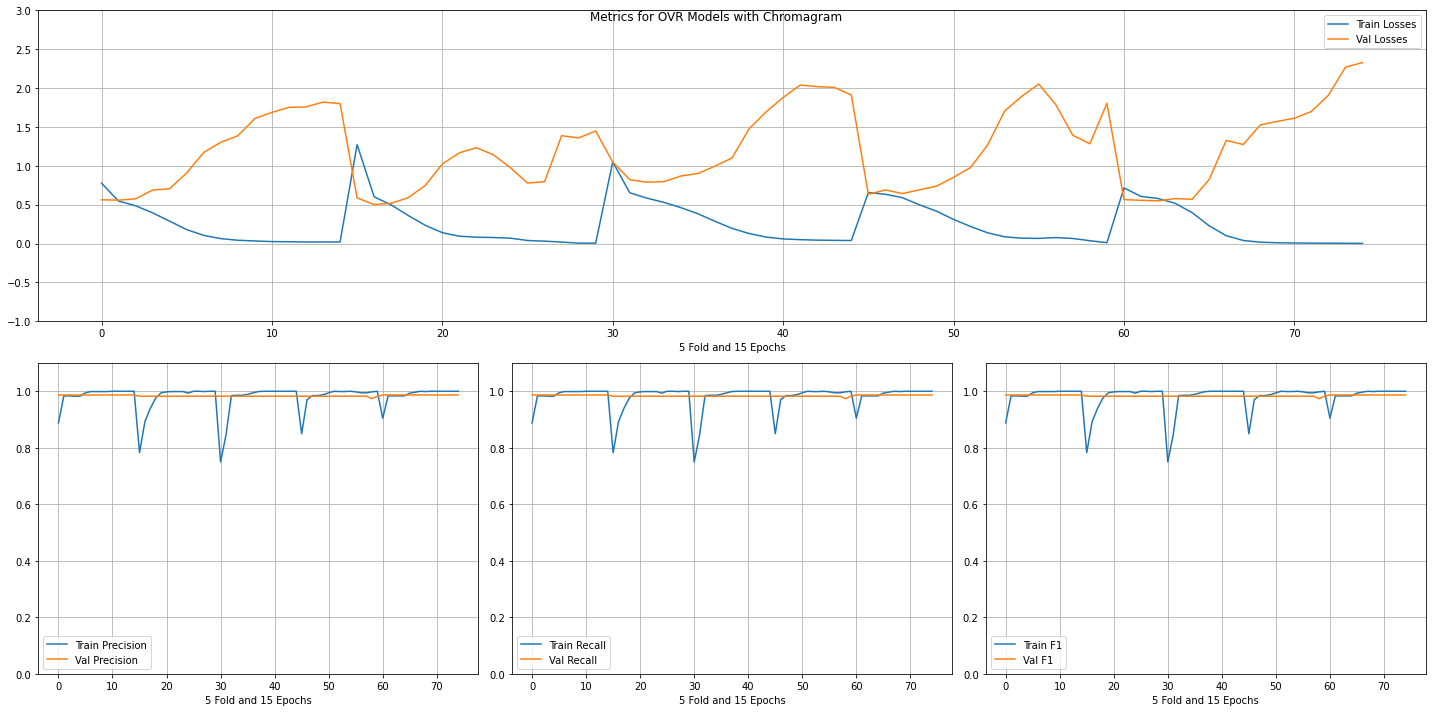

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.888035       0.986842  ...      0.776277           0.562337
8   0.998902       0.986842  ...      0.041679           1.386511
1   0.983535       0.986842  ...      0.546545           0.558088
13  1.000000       0.986842  ...      0.020197           1.820296
12  1.000000       0.986842  ...      0.019917           1.757500
..       ...            ...  ...           ...                ...
2   0.984632       0.982456  ...      0.589137           0.642612
3   0.984632       0.982456  ...      0.497607           0.691185
4   0.987925       0.982456  ...      0.416073           0.738012
7   0.998902       0.982456  ...      0.194937           1.100367
13  0.997805       0.973684  ...      0.035773           1.283047

[75 rows x 8 columns]
Training for ['మాళవిగౌళ'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50802855 31.63888889]
Epoch 1/15 : Training Loss: 0.937 / Validation Lo

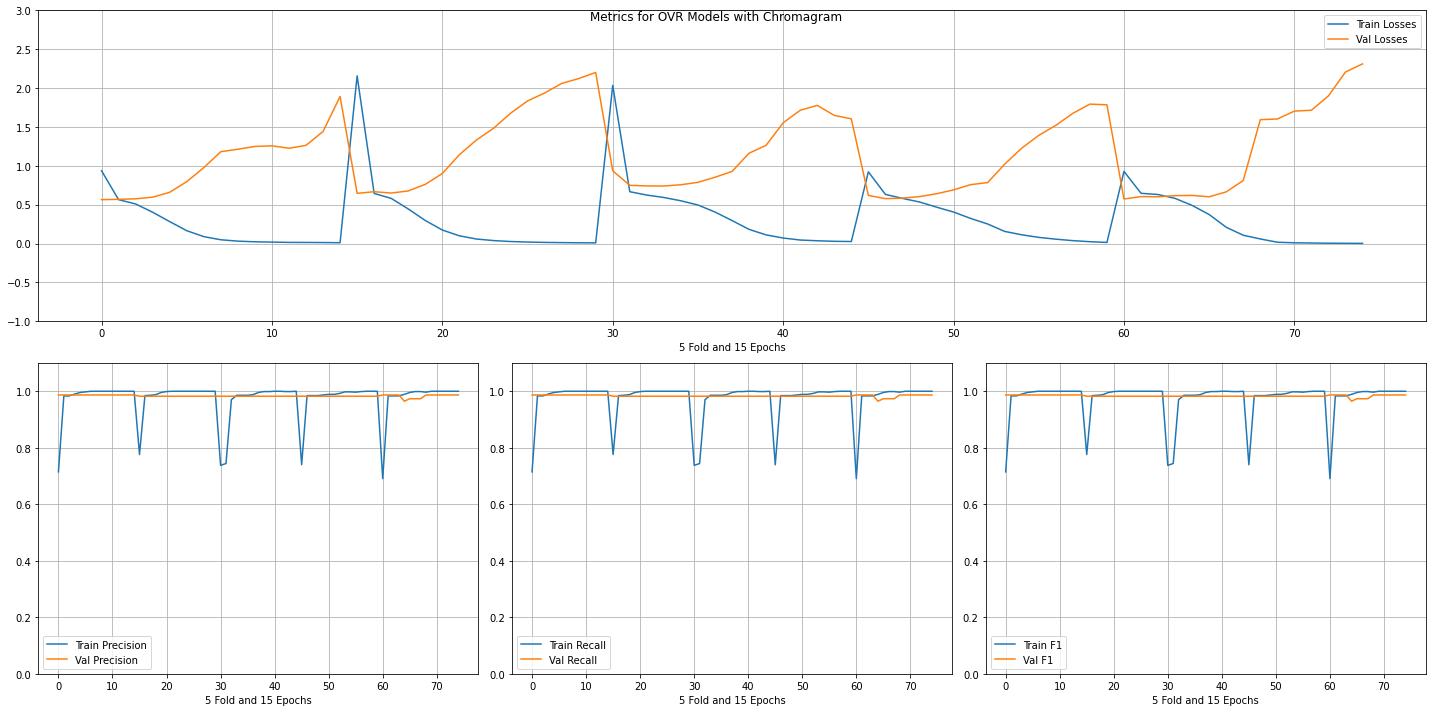

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.714599       0.986842  ...      0.937228           0.564449
8   1.000000       0.986842  ...      0.030461           1.213157
14  1.000000       0.986842  ...      0.009901           1.891874
13  1.000000       0.986842  ...      0.012207           1.441507
1   0.983535       0.986842  ...      0.564664           0.567982
..       ...            ...  ...           ...                ...
7   0.995609       0.982456  ...      0.295424           0.927169
5   0.995614       0.973568  ...      0.372586           0.601182
6   0.998904       0.973568  ...      0.209146           0.664630
7   0.998904       0.973568  ...      0.106229           0.810629
4   0.989035       0.964758  ...      0.490170           0.618945

[75 rows x 8 columns]
Training for ['ముఖారి'] with 55 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.525369   10.35454545]
Epoch 1/15 : Training Loss: 0.811 / Validation Loss

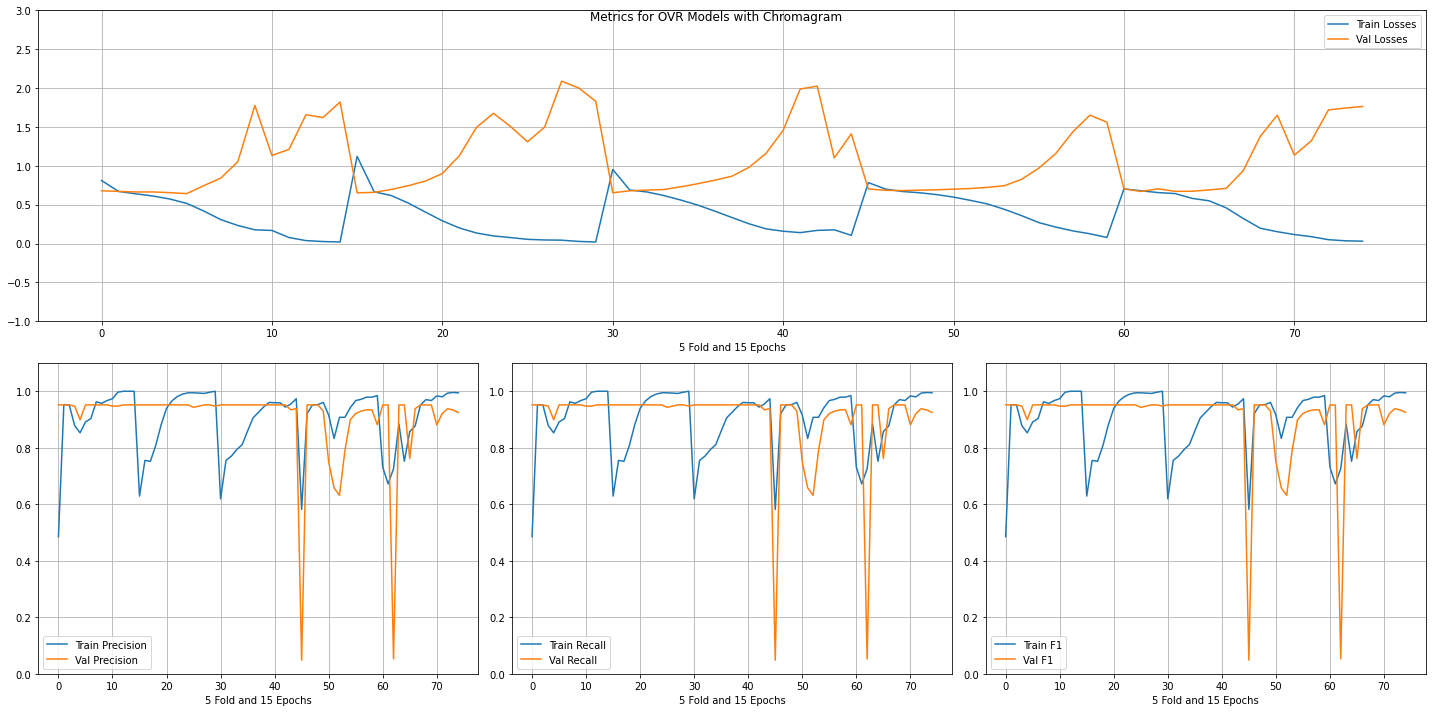

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.485181       0.951754  ...      0.811233           0.678540
7   0.981339       0.951754  ...      0.135469           1.493678
9   0.994512       0.951754  ...      0.076257           1.506466
12  0.992316       0.951754  ...      0.042888           2.088885
13  0.996707       0.951754  ...      0.026816           2.002003
..       ...            ...  ...           ...                ...
5   0.915477       0.750000  ...      0.597168           0.699304
6   0.833150       0.657895  ...      0.554734           0.707682
7   0.907794       0.631579  ...      0.508433           0.722663
2   0.725877       0.052863  ...      0.655345           0.704136
0   0.581778       0.048246  ...      0.783674           0.701924

[75 rows x 8 columns]
Training for ['రామక్రియ'] with 61 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.52829314 9.33606557]
Epoch 1/15 : Training Loss: 0.808 / Validation Loss

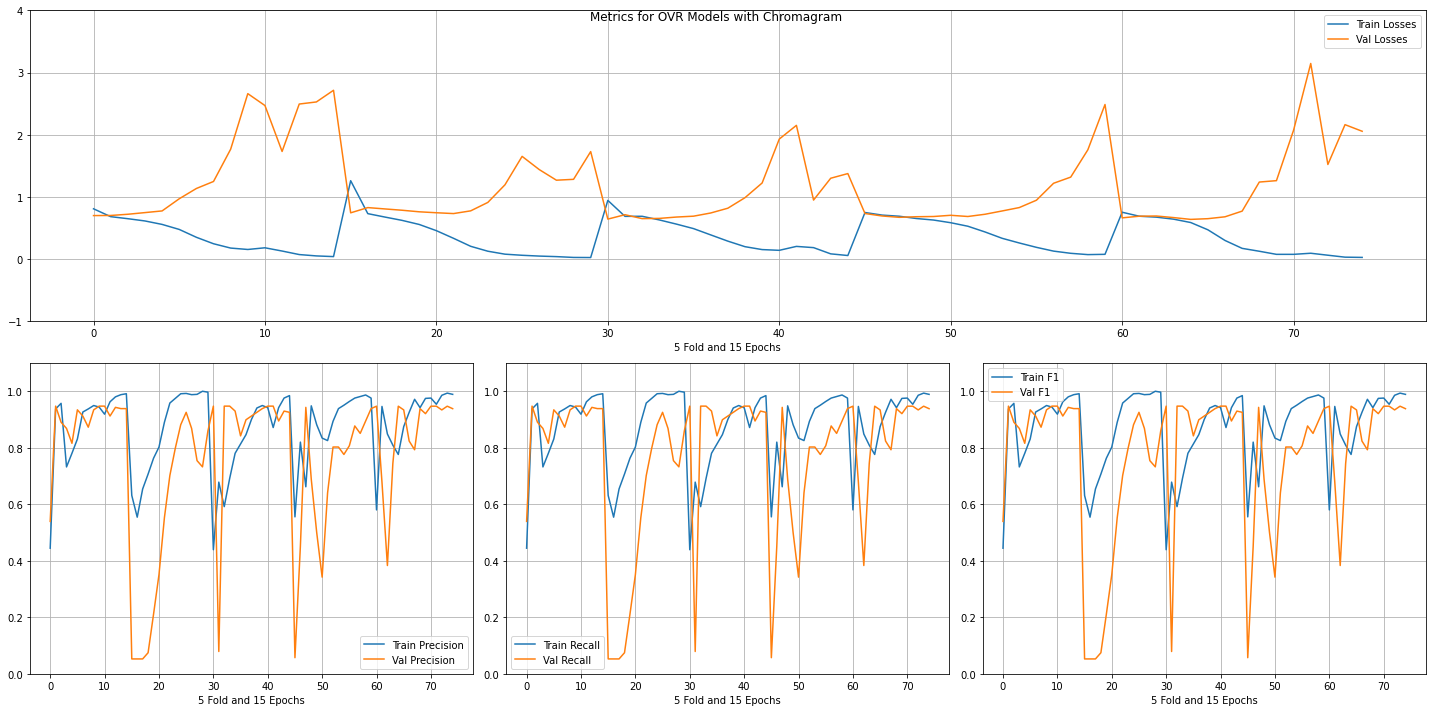

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.439078       0.947368  ...      0.943567           0.642524
10  0.941822       0.947368  ...      0.140166           1.930057
2   0.591658       0.947368  ...      0.687762           0.650361
11  0.871570       0.947368  ...      0.203387           2.150644
10  0.918771       0.947368  ...      0.180983           2.469372
..       ...            ...  ...           ...                ...
3   0.706915       0.074561  ...      0.621947           0.785011
0   0.555434       0.057018  ...      0.748644           0.732295
1   0.554336       0.052632  ...      0.730337           0.827599
0   0.631175       0.052632  ...      1.260262           0.743485
2   0.654226       0.052632  ...      0.675206           0.805970

[75 rows x 8 columns]
Training for ['లలిత'] with 98 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.54707012 5.81122449]
Epoch 1/15 : Training Loss: 0.759 / Validation Loss : 0

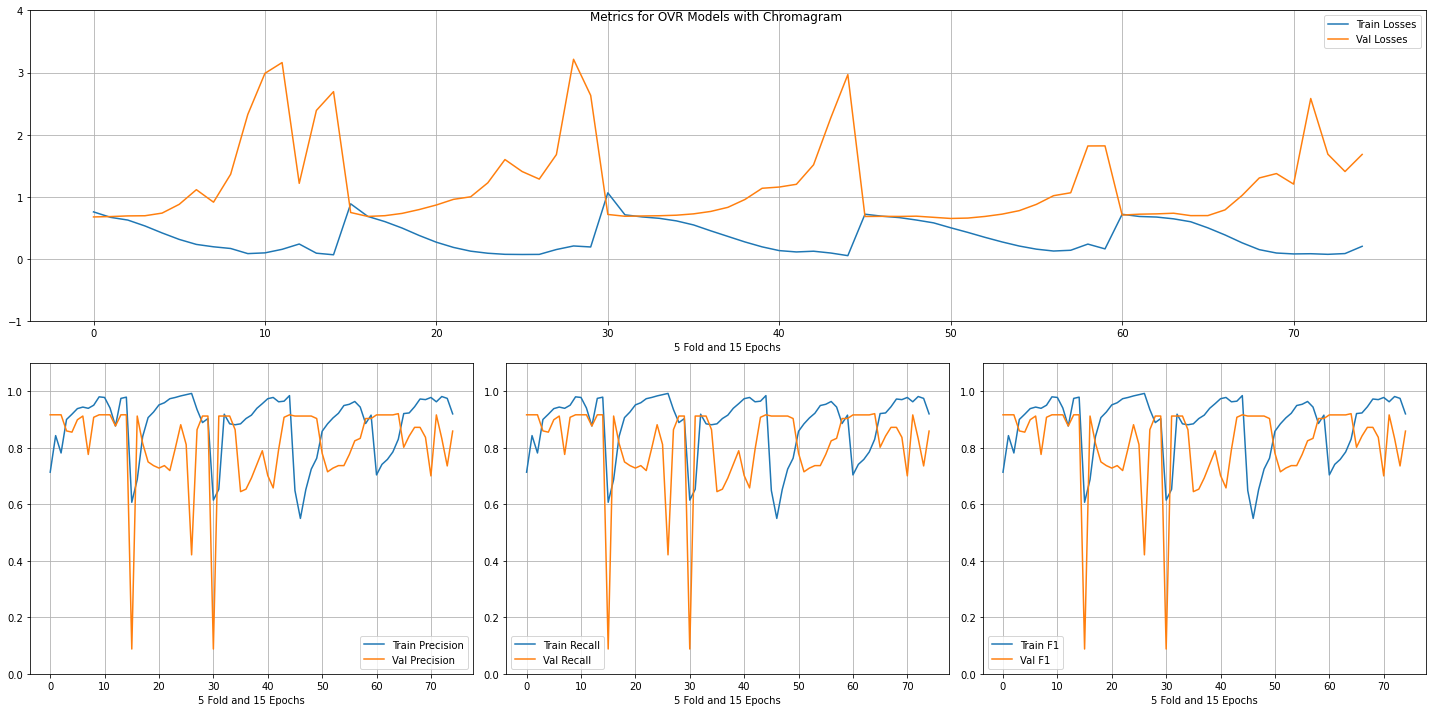

    train_f1  validation_f1  ...  train_losses  validation_losses
4   0.830044       0.920705  ...      0.599636           0.698376
0   0.713502       0.916667  ...      0.758598           0.677254
9   0.980241       0.916667  ...      0.087355           2.326361
1   0.843030       0.916667  ...      0.670439           0.683309
14  0.979144       0.916667  ...      0.068592           2.692814
..       ...            ...  ...           ...                ...
6   0.903403       0.653509  ...      0.454138           0.765786
5   0.884742       0.644737  ...      0.548653           0.726920
11  0.992316       0.421053  ...      0.074696           1.286021
0   0.607025       0.087719  ...      0.888102           0.748355
0   0.614709       0.087719  ...      1.064913           0.717211

[75 rows x 8 columns]
Training for ['వరాళి'] with 22 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50984781 25.88636364]
Epoch 1/15 : Training Loss: 0.719 / Validation Loss 

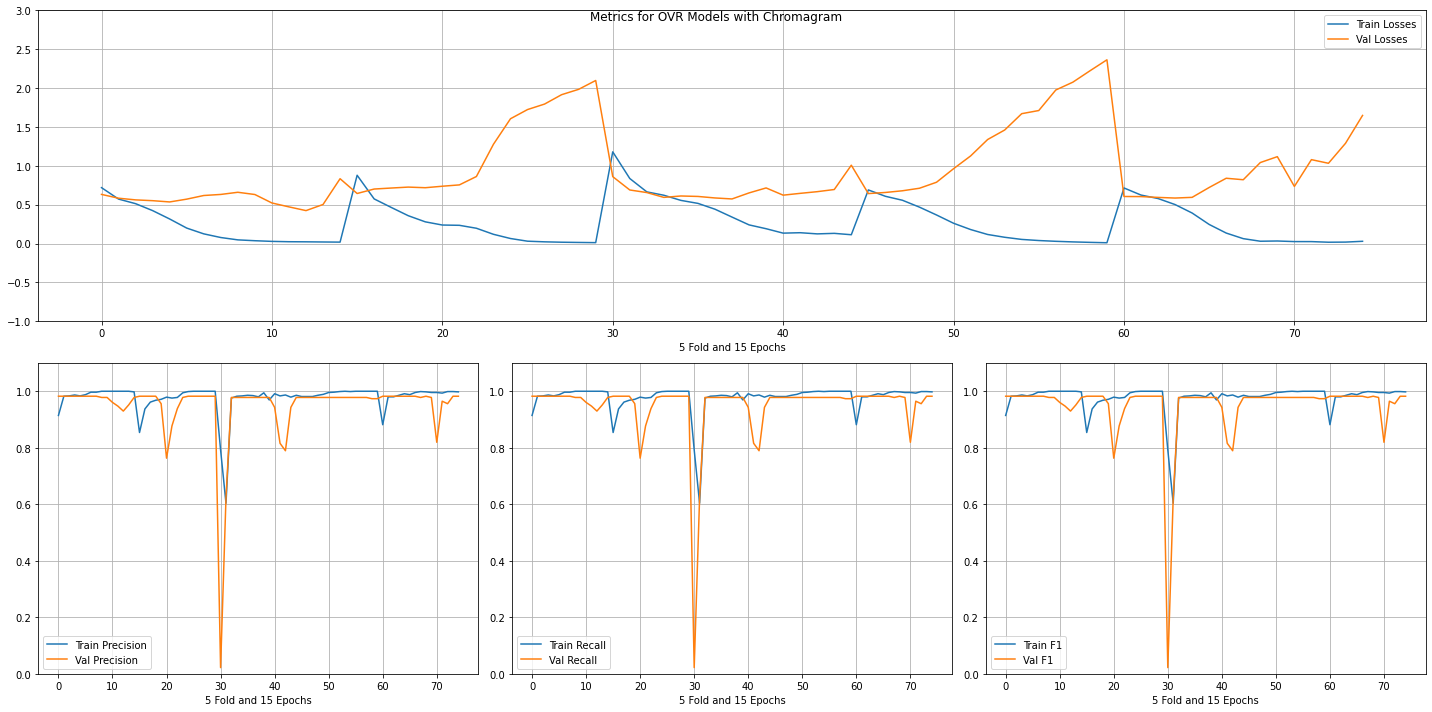

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.914380       0.982456  ...      0.718916           0.631826
12  1.000000       0.982456  ...      0.016544           1.915241
10  1.000000       0.982456  ...      0.029728           1.723856
9   0.998902       0.982456  ...      0.064117           1.605621
13  1.000000       0.982456  ...      0.013556           1.984120
..       ...            ...  ...           ...                ...
11  0.983535       0.815789  ...      0.138803           0.645435
12  0.986828       0.789474  ...      0.123821           0.667058
5   0.979144       0.763158  ...      0.237688           0.737053
1   0.603732       0.622807  ...      0.836468           0.688830
0   0.792536       0.021930  ...      1.179597           0.860520

[75 rows x 8 columns]
Training for ['శంకరాభరణం'] with 68 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.53174603 8.375     ]
Epoch 1/15 : Training Loss: 0.801 / Validation Los

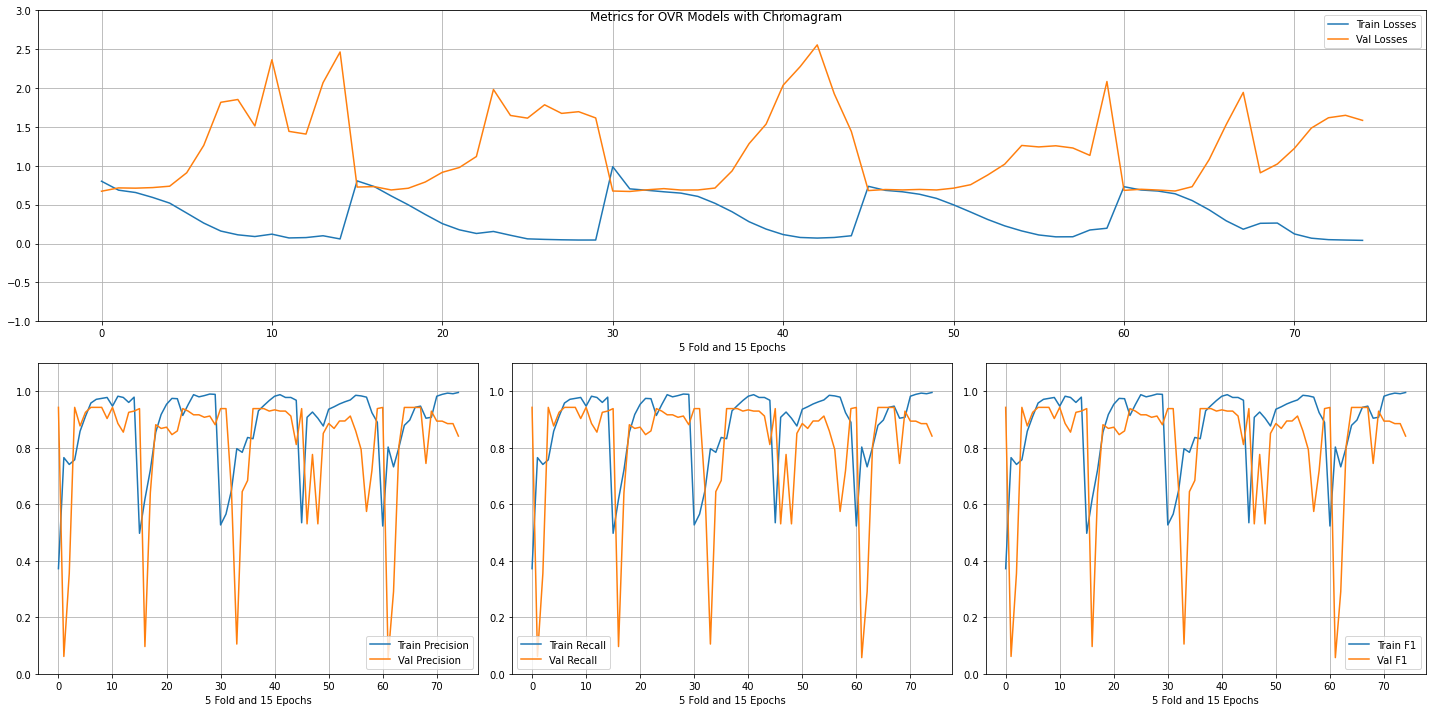

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.372119       0.942982  ...      0.801452           0.672685
7   0.971460       0.942982  ...      0.160204           1.817206
3   0.757409       0.942982  ...      0.592955           0.719573
10  0.947311       0.942982  ...      0.120284           2.364916
8   0.974753       0.942982  ...      0.111704           1.853302
..       ...            ...  ...           ...                ...
2   0.732456       0.290749  ...      0.675024           0.688096
3   0.796926       0.105263  ...      0.665525           0.706181
1   0.618002       0.096491  ...      0.733193           0.732022
1   0.765093       0.061404  ...      0.686477           0.715553
1   0.802632       0.057269  ...      0.688741           0.697893

[75 rows x 8 columns]
Training for ['శుద్ధవసంతం'] with 33 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51491863 17.25757576]
Epoch 1/15 : Training Loss: 0.723 / Validation 

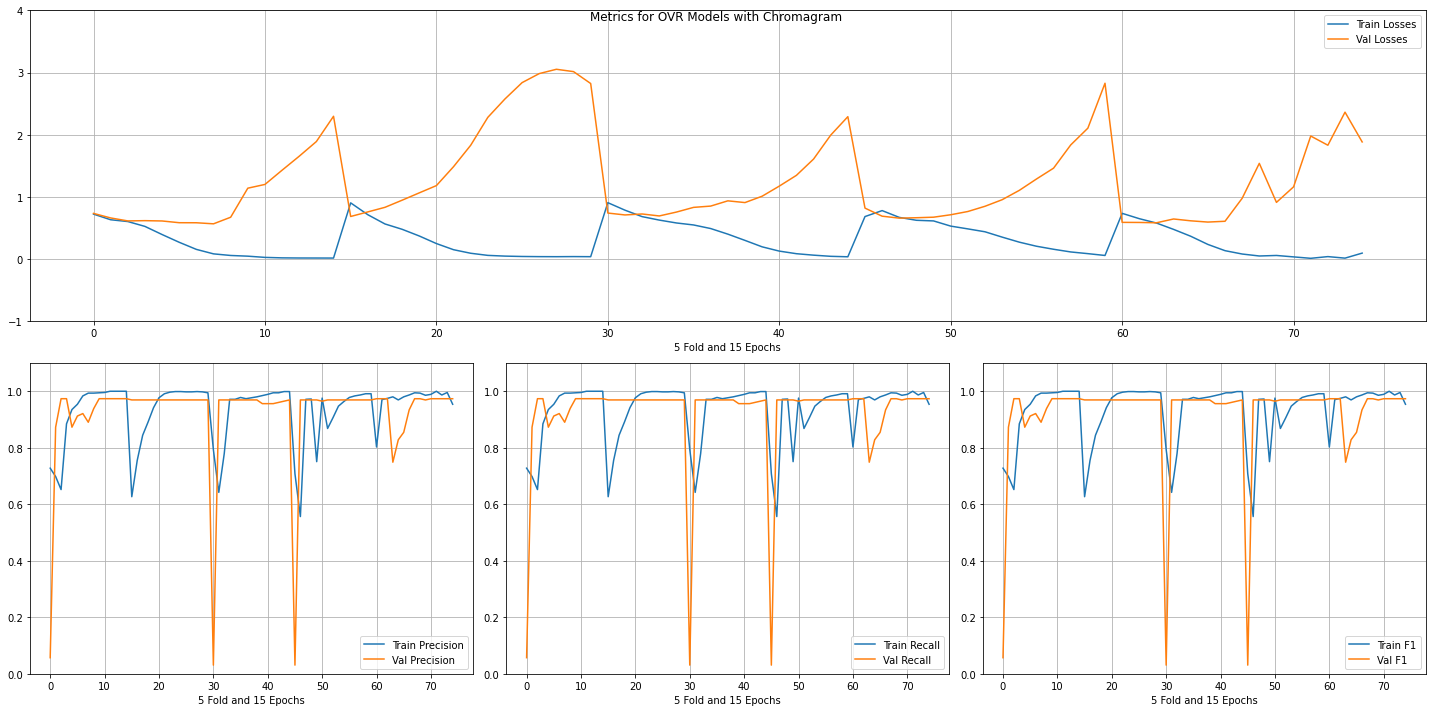

    train_f1  validation_f1  ...  train_losses  validation_losses
12  1.000000       0.973684  ...      0.016694           1.654328
2   0.652031       0.973684  ...      0.603283           0.613288
3   0.884742       0.973684  ...      0.525108           0.617506
14  1.000000       0.973684  ...      0.015676           2.296726
13  1.000000       0.973684  ...      0.016206           1.890208
..       ...            ...  ...           ...                ...
4   0.969298       0.828194  ...      0.366654           0.614997
3   0.980263       0.748899  ...      0.477074           0.644404
0   0.727772       0.057018  ...      0.722795           0.734210
0   0.708013       0.030702  ...      0.683453           0.819309
0   0.793633       0.030702  ...      0.906853           0.739739

[75 rows x 8 columns]
Training for ['శ్రీరాగం'] with 65 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.53026071 8.76153846]
Epoch 1/15 : Training Loss: 0.764 / Validation Loss

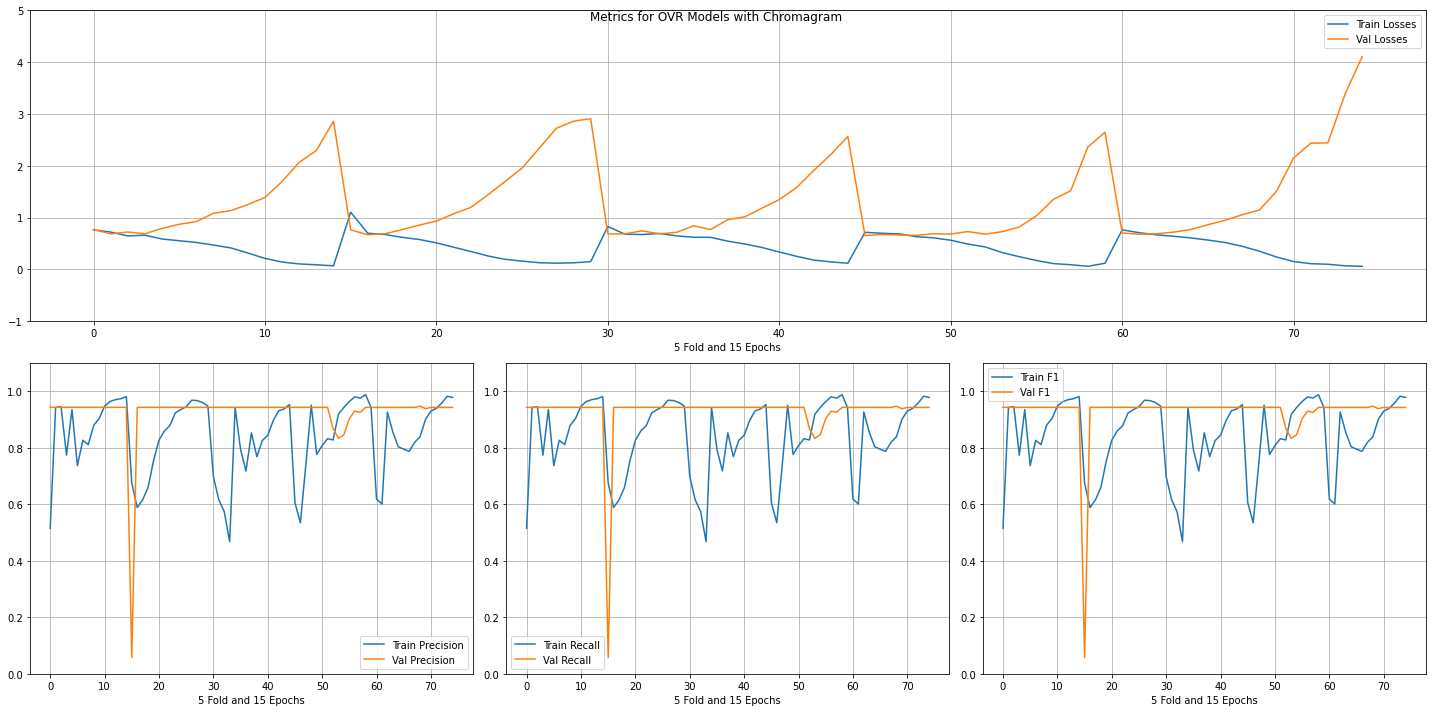

    train_f1  validation_f1  ...  train_losses  validation_losses
8   0.838816       0.947137  ...      0.352174           1.144215
0   0.514819       0.942982  ...      0.764099           0.769547
11  0.895719       0.942982  ...      0.253347           1.577671
0   0.698134       0.942982  ...      0.828252           0.684274
1   0.615807       0.942982  ...      0.679483           0.686525
..       ...            ...  ...           ...                ...
10  0.963776       0.903509  ...      0.172817           1.035069
7   0.827662       0.868421  ...      0.434775           0.681148
9   0.942920       0.846491  ...      0.245187           0.818489
8   0.918771       0.833333  ...      0.324624           0.728601
0   0.675082       0.057018  ...      1.104169           0.763295

[75 rows x 8 columns]
Training for ['సామంతం'] with 89 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.54238095 6.3988764 ]
Epoch 1/15 : Training Loss: 0.752 / Validation Loss :

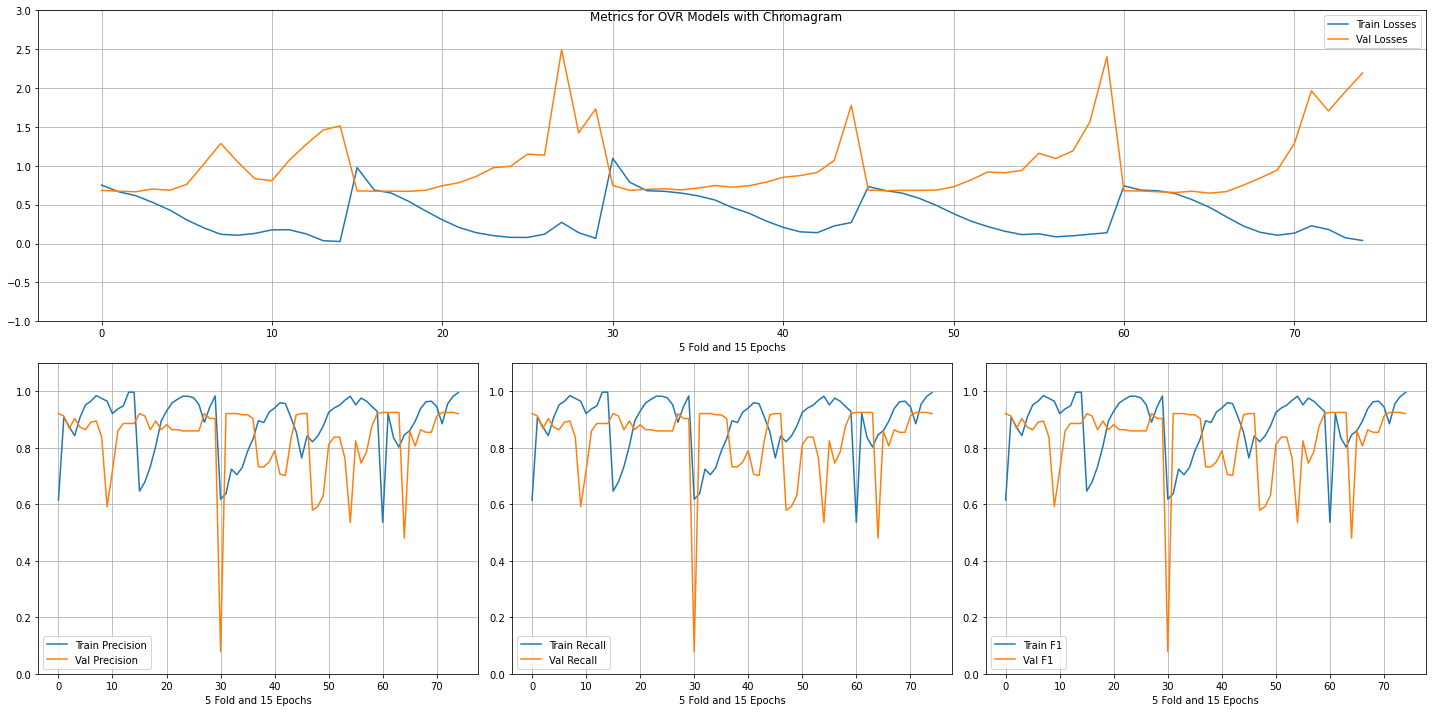

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.981360       0.925110  ...      0.072748           1.956945
12  0.955044       0.925110  ...      0.180568           1.705351
11  0.884868       0.925110  ...      0.227941           1.965175
3   0.802632       0.925110  ...      0.643859           0.656095
2   0.835526       0.925110  ...      0.677987           0.665640
..       ...            ...  ...           ...                ...
3   0.841932       0.592105  ...      0.579975           0.683924
2   0.821076       0.578947  ...      0.647665           0.684792
9   0.982437       0.535088  ...      0.114562           0.939546
4   0.845395       0.480176  ...      0.563559           0.672693
0   0.618002       0.078947  ...      1.095444           0.745692

[75 rows x 8 columns]
Training for ['సాళంగం'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50487589 51.77272727]
Epoch 1/15 : Training Loss: 0.738 / Validation Loss

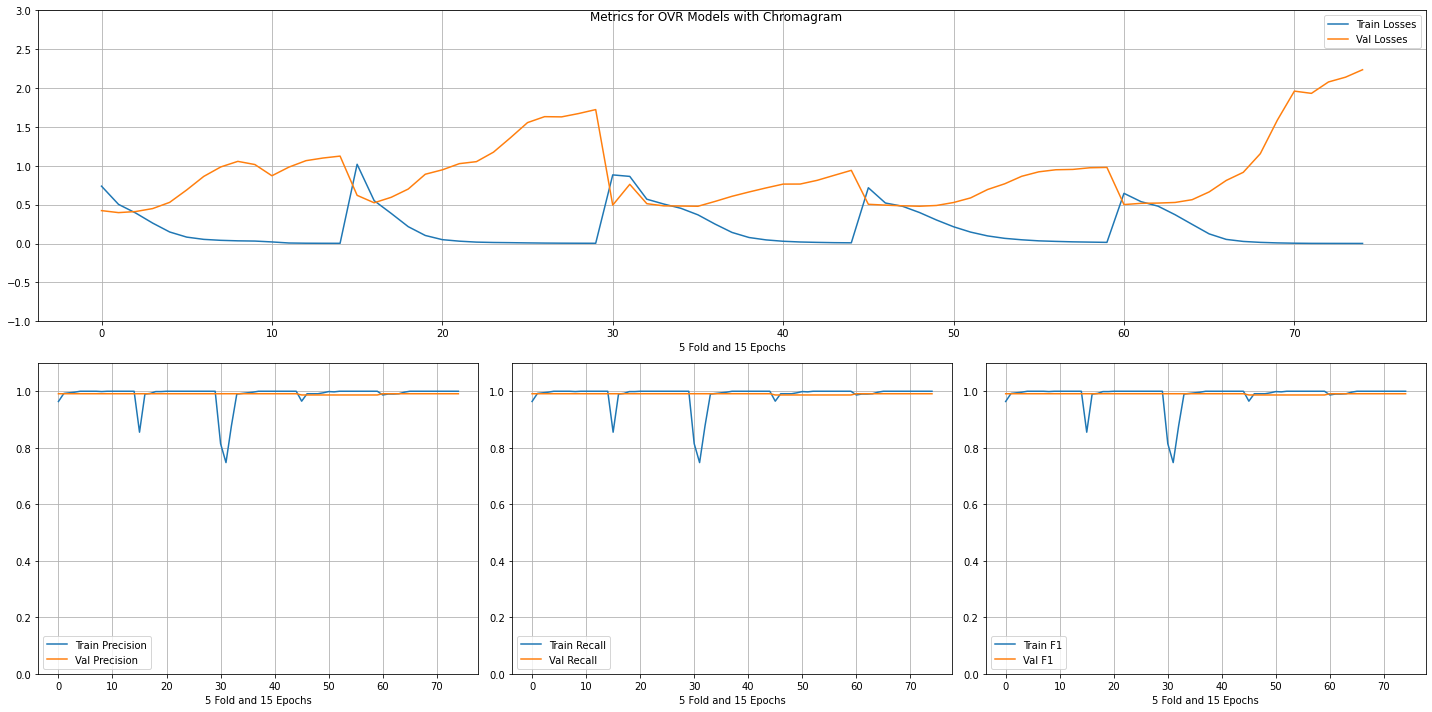

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.963776       0.991228  ...      0.738104           0.423256
4   0.992316       0.991228  ...      0.452917           0.482426
10  1.000000       0.991228  ...      0.007712           1.555899
11  1.000000       0.991228  ...      0.005396           1.632422
12  1.000000       0.991228  ...      0.004086           1.629661
..       ...            ...  ...           ...                ...
3   0.991218       0.986842  ...      0.398717           0.479582
2   0.991218       0.986842  ...      0.479444           0.485182
1   0.991218       0.986842  ...      0.521125           0.493721
0   0.964874       0.986842  ...      0.717535           0.504671
4   0.994512       0.986842  ...      0.302313           0.489501

[75 rows x 8 columns]
Training for ['సాళంగనాట'] with 94 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.54497608 6.05851064]
Epoch 1/15 : Training Loss: 0.732 / Validation Loss

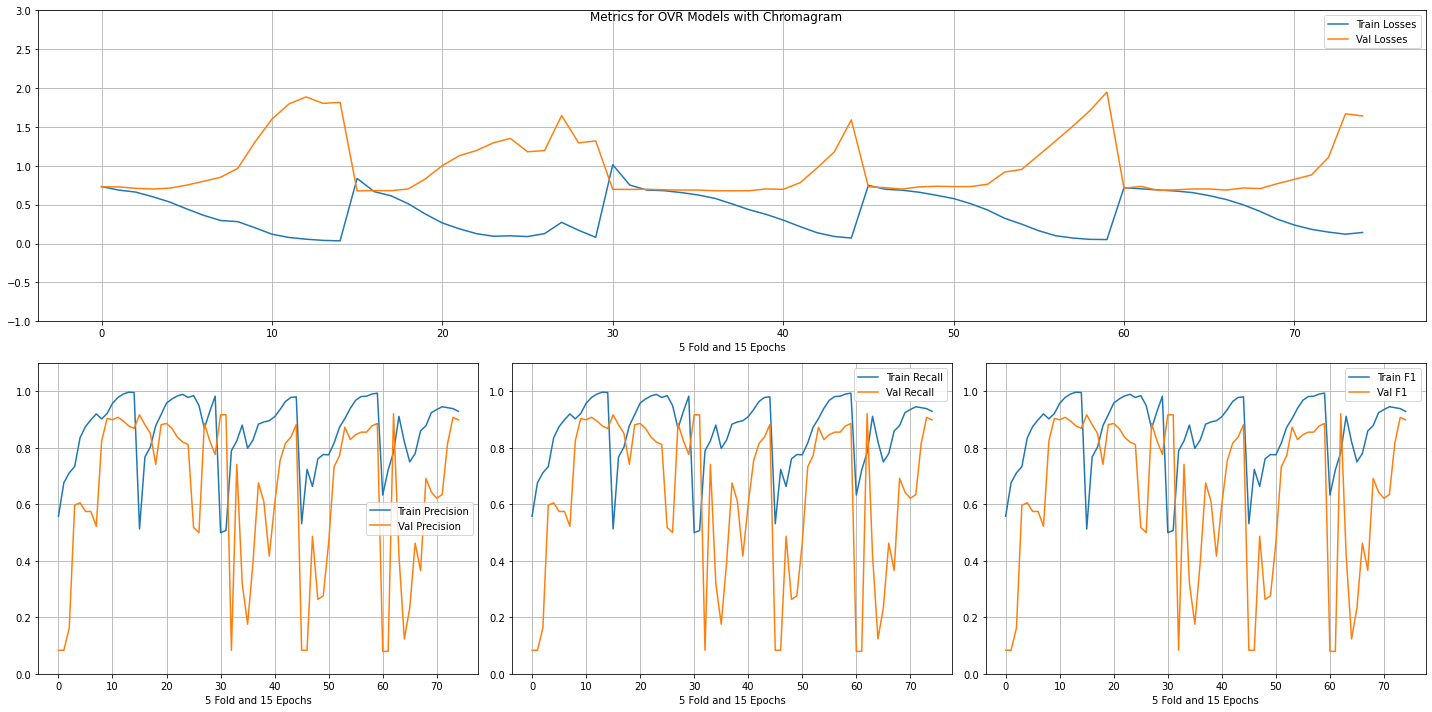

    train_f1  validation_f1  ...  train_losses  validation_losses
2   0.783991       0.920705  ...      0.689027           0.684048
1   0.507135       0.916667  ...      0.752410           0.696040
0   0.499451       0.916667  ...      1.013470           0.697795
0   0.512623       0.916667  ...      0.837365           0.676070
11  0.978046       0.907895  ...      0.077678           1.796119
..       ...            ...  ...           ...                ...
1   0.723381       0.083333  ...      0.698235           0.718083
0   0.531284       0.083333  ...      0.747903           0.730998
0   0.557629       0.083333  ...      0.732418           0.730283
0   0.632675       0.079295  ...      0.718552           0.711330
1   0.721491       0.079295  ...      0.703860           0.735033

[75 rows x 8 columns]


In [26]:
le = LabelEncoder()
le.fit(data['Ragam'])
labels = le.transform(le.classes_)
ovr_res = ovr_train_model(data, ChromaDataset, ChromaRaga, "OVR Models with Chromagram", labels, le.classes_, 
                          lbl_encoder=le, lr=1e-3, epochs=15, n_folds=5, feature='chroma')

In [27]:
for k in ovr_res:
  print(le.inverse_transform([k]))
  print(results_to_df(ovr_res[k]).head())

['ఆహిరి']
    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.669594       0.960526  ...      0.808368           0.664853
6   0.961581       0.960526  ...      0.451157           0.867528
12  0.997805       0.960526  ...      0.028801           2.445314
13  0.998902       0.960526  ...      0.023986           2.708406
14  0.998902       0.960526  ...      0.024503           2.855474

[5 rows x 8 columns]
['కన్నడగౌళ']
    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.992316       0.986842  ...      0.288995           0.518873
12  1.000000       0.986842  ...      0.021553           1.338324
0   0.664105       0.986842  ...      1.338848           0.593826
14  1.000000       0.986842  ...      0.007798           1.542303
3   0.767289       0.986842  ...      0.692339           0.577195

[5 rows x 8 columns]
['కాంబోది']
    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.994518       0.986784  ...      0.034349           3.4048

# Mapping each Raga with Janaka Ragam

In [28]:
janaka_raga_map ={'లలిత':'Mayamalavagowla',
'సాళంగనాట':'Mayamalavagowla',
'సామంతం':'Naganandini',
'బౌళి':'Mayamalavagowla',
'శంకరాభరణం':'Shankarabharanam',
'శ్రీరాగం':'Kharaharapriya',
'రామక్రియ':'Mayamalavagowla',
'ముఖారి':'Kharaharapriya',
'పాడి':'Mayamalavagowla',
'ఆహిరి':'Vakulabharanam',
'దేసాళం':'Unknown',
'దేవగాంధారి':'Shankarabharanam',
'శుద్ధవసంతం':'Shankarabharanam',
'భూపాలం':'Shubhapantuvarali',
'దేసాక్షి':'Harikambhoji',
'గుండుక్రియ':'Mayamalavagowla',
'భైరవి':'Natabhairavi',
'నాట':'Chalanata',
'వరాళి':'Jhalavarali',
'ధన్నాసి':'Hanumatodi',
'మలహరి':'Mayamalavagowla',
'కాంబోది':'Harikambhoji',
'మాళవిగౌళ':'Mayamalavagowla',
'మాళవి':'Harikambhoji',
'గుజ్జరి':'Unknown',
'కన్నడగౌళ':'Kharaharapriya',
'గౌళ':'Mayamalavagowla',
'బౌళిరామక్రియ':'Mayamalavagowla',
'నాదరామక్రియ':'Unknown',
'సాళంగం':'Kalyani'}

In [29]:
data['janaka_ragam'] = data.apply(lambda x:janaka_raga_map[x['Ragam']],axis=1)

In [30]:
jle = LabelEncoder()
jle.fit(data['janaka_ragam'])
data['JanakaRagamCode'] = data.apply(lambda x:jle.transform([x.janaka_ragam])[0],axis=1)
n_labels = len(data['RagamCode'].unique())

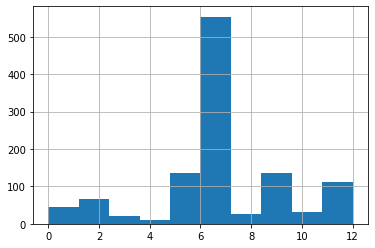

In [31]:
data['JanakaRagamCode'].hist()

In [32]:
class ChromaJanakaRagaDataset(AbsDataset):
    def __init__(self, labels, mfcc_vals):
        super().__init__()
        self.labels = labels
        self.mfcc_vals = mfcc_vals

    def __get__(self,index):
      if self.mfcc_vals[index].shape[1] < 1876:
        self.mfcc_vals[index] = torch.hstack((self.mfcc_vals[index],torch.zeros(12,1876-self.mfcc_vals[index].shape[1])))
      return self.mfcc_vals[index].reshape((1,)+self.mfcc_vals[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['JanakaRagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['JanakaRagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['chroma'].iloc[x] for x in train_ids]
      test_vals = [data['chroma'].iloc[x] for x in test_ids]
      train_data = ChromaJanakaRagaDataset(train_lbls, train_vals)
      test_data = ChromaJanakaRagaDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.51192748 21.46      ]
Epoch 1/15 : Training Loss: 0.820 / Validation Loss : 0.715 [Time Taken : 0.227882 seconds]
Epoch 2/15 : Training Loss: 0.662 / Validation Loss : 0.662 [Time Taken : 0.209175 seconds]
Epoch 3/15 : Training Loss: 0.586 / Validation Loss : 0.648 [Time Taken : 0.205685 seconds]
Epoch 4/15 : Training Loss: 0.495 / Validation Loss : 0.634 [Time Taken : 0.213138 seconds]
Epoch 5/15 : Training Loss: 0.409 / Validation Loss : 0.622 [Time Taken : 0.211676 seconds]
Epoch 6/15 : Training Loss: 0.317 / Validation Loss : 0.614 [Time Taken : 0.210635 seconds]
Epoch 7/15 : Training Loss: 0.219 / Validation Loss : 0.676 [Time Taken : 0.213215 seconds]
Epoch 8/15 : Training Loss: 0.144 / Validation Loss : 0.688 [Time Taken : 0.20003 seconds]
Epoch 9/15 : Training Loss: 0.120 / Validation Loss : 0.635 [Time Taken : 0.210523 seconds]
Epoch 10/15 : Training Loss: 0.104 /

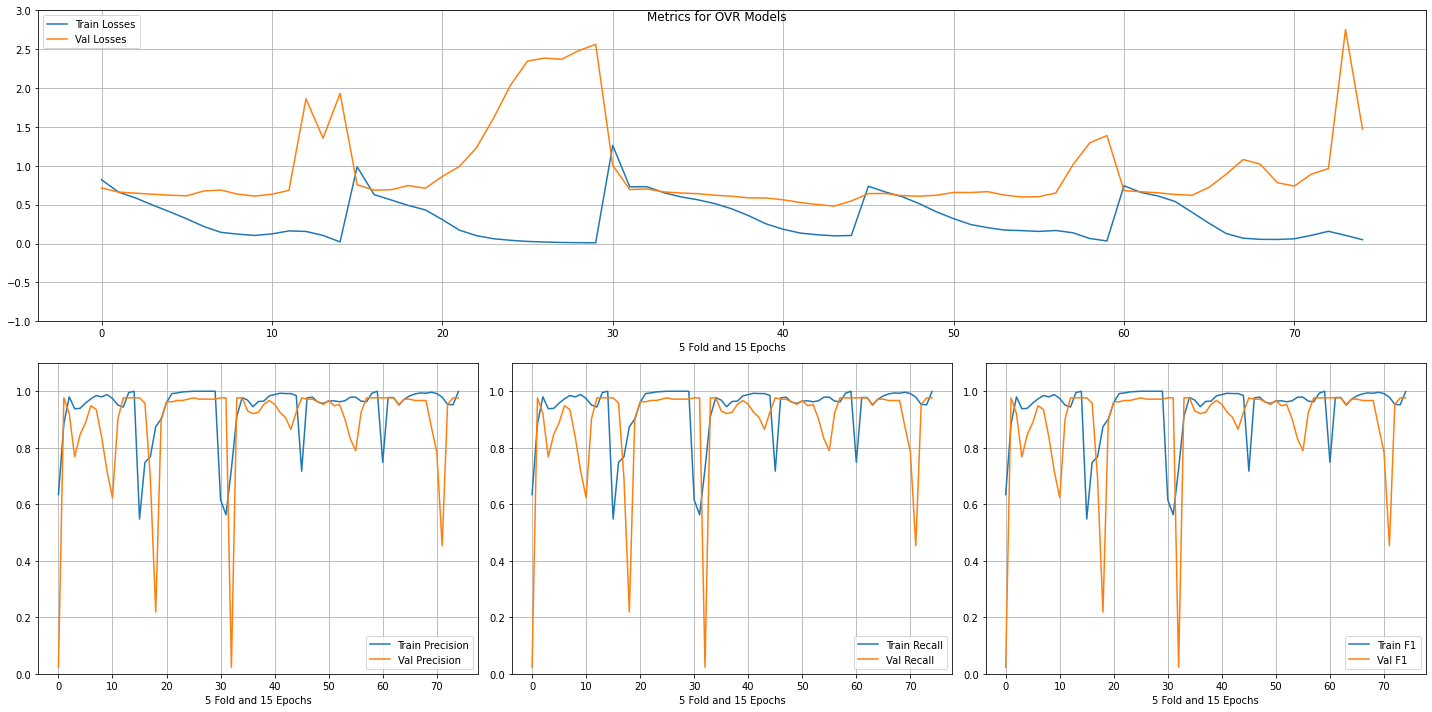

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.615385       0.976744  ...      1.262428           1.004443
13  0.995338       0.976744  ...      0.103952           1.355394
1   0.884615       0.976744  ...      0.661820           0.661921
0   0.547786       0.976744  ...      0.987298           0.756009
4   0.977855       0.976744  ...      0.600334           0.649554
..       ...            ...  ...           ...                ...
10  0.974359       0.623256  ...      0.123682           0.634195
11  0.979045       0.453271  ...      0.104898           0.892538
3   0.874126       0.218605  ...      0.489536           0.745926
2   0.724942       0.023256  ...      0.731343           0.702849
0   0.634033       0.023256  ...      0.820331           0.714579

[75 rows x 8 columns]
Training for ['Hanumatodi'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.50949668 26.825     ]
Epoch 1/15 : Training Loss: 0.887 / Validation 

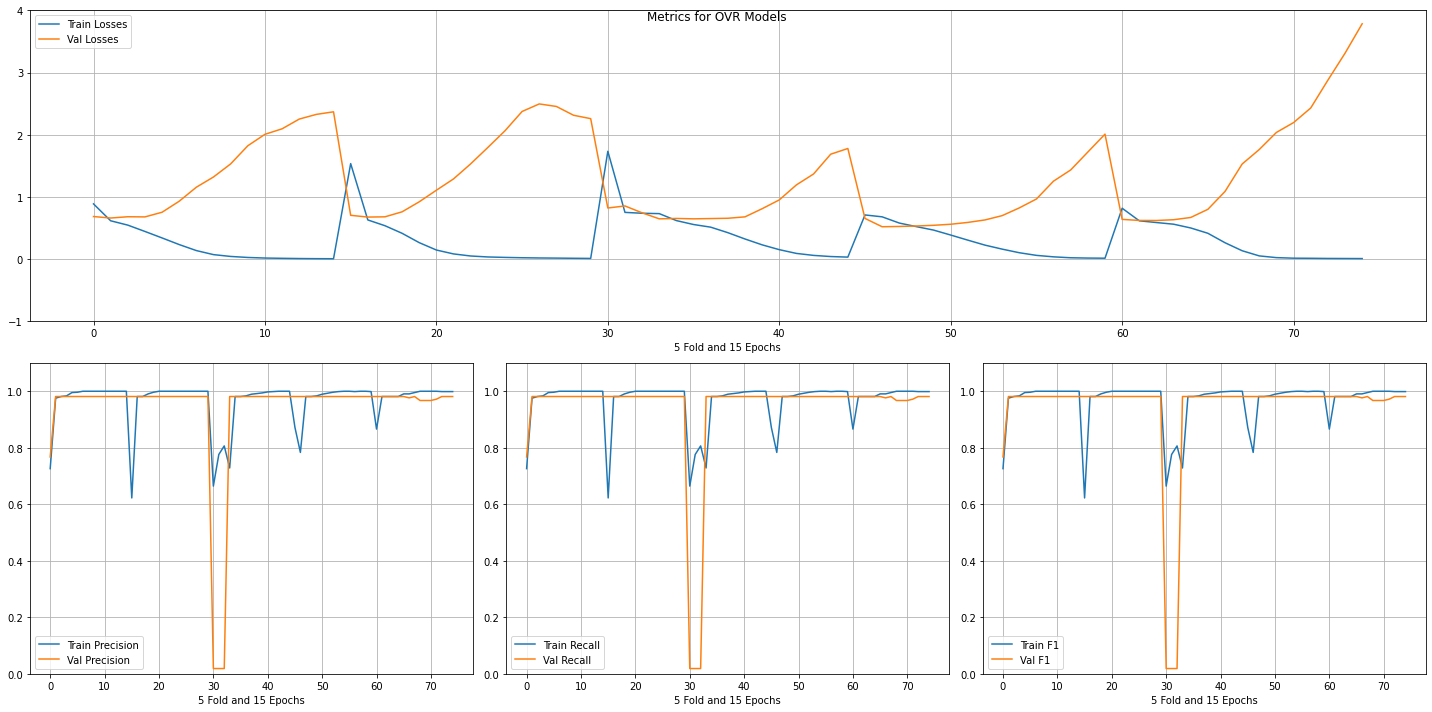

    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.989510       0.981395  ...      0.424324           0.655963
5   0.981352       0.981395  ...      0.555363           0.646771
8   1.000000       0.981395  ...      0.033420           1.794710
9   1.000000       0.981395  ...      0.026424           2.062909
10  1.000000       0.981395  ...      0.020879           2.374134
..       ...            ...  ...           ...                ...
10  1.000000       0.967290  ...      0.013798           2.195330
0   0.726107       0.767442  ...      0.887102           0.683610
2   0.806527       0.018605  ...      0.736664           0.743299
1   0.776224       0.018605  ...      0.750320           0.854018
0   0.664336       0.018605  ...      1.733541           0.821175

[75 rows x 8 columns]
Training for ['Harikambhoji'] with 66 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [0.53277061 8.12878788]
Epoch 1/15 : Training Loss: 0.736 / Validation 

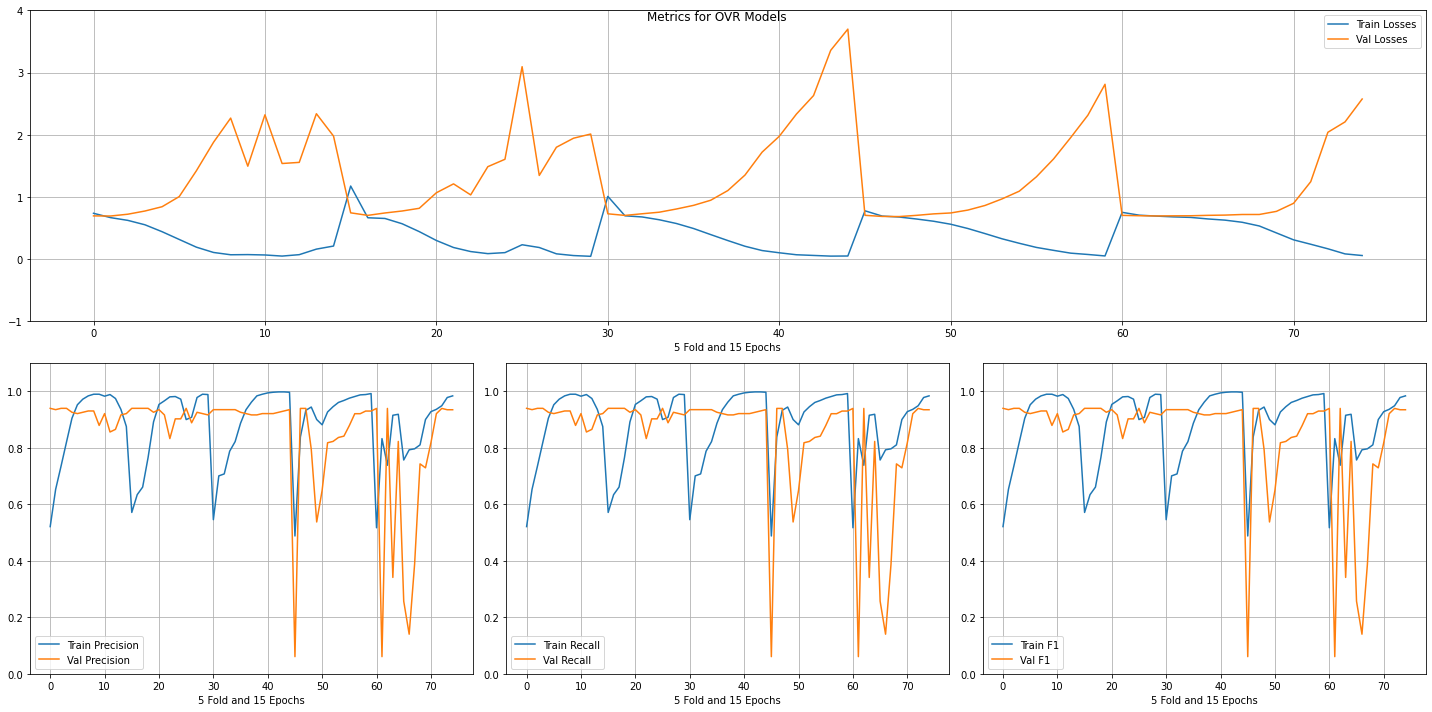

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.520979       0.939535  ...      0.736078           0.694139
0   0.571096       0.939535  ...      1.174463           0.743239
2   0.735431       0.939535  ...      0.622130           0.721114
3   0.820513       0.939535  ...      0.551167           0.772527
10  0.899767       0.939535  ...      0.229873           3.094429
..       ...            ...  ...           ...                ...
3   0.915017       0.341121  ...      0.678036           0.695188
5   0.756694       0.257009  ...      0.645043           0.702968
6   0.792782       0.140187  ...      0.625840           0.707040
1   0.832363       0.060748  ...      0.705513           0.696628
0   0.487776       0.060748  ...      0.775915           0.703343

[75 rows x 8 columns]
Training for ['Jhalavarali'] with 22 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.51046622 24.38636364]
Epoch 1/15 : Training Loss: 0.751 / Validation

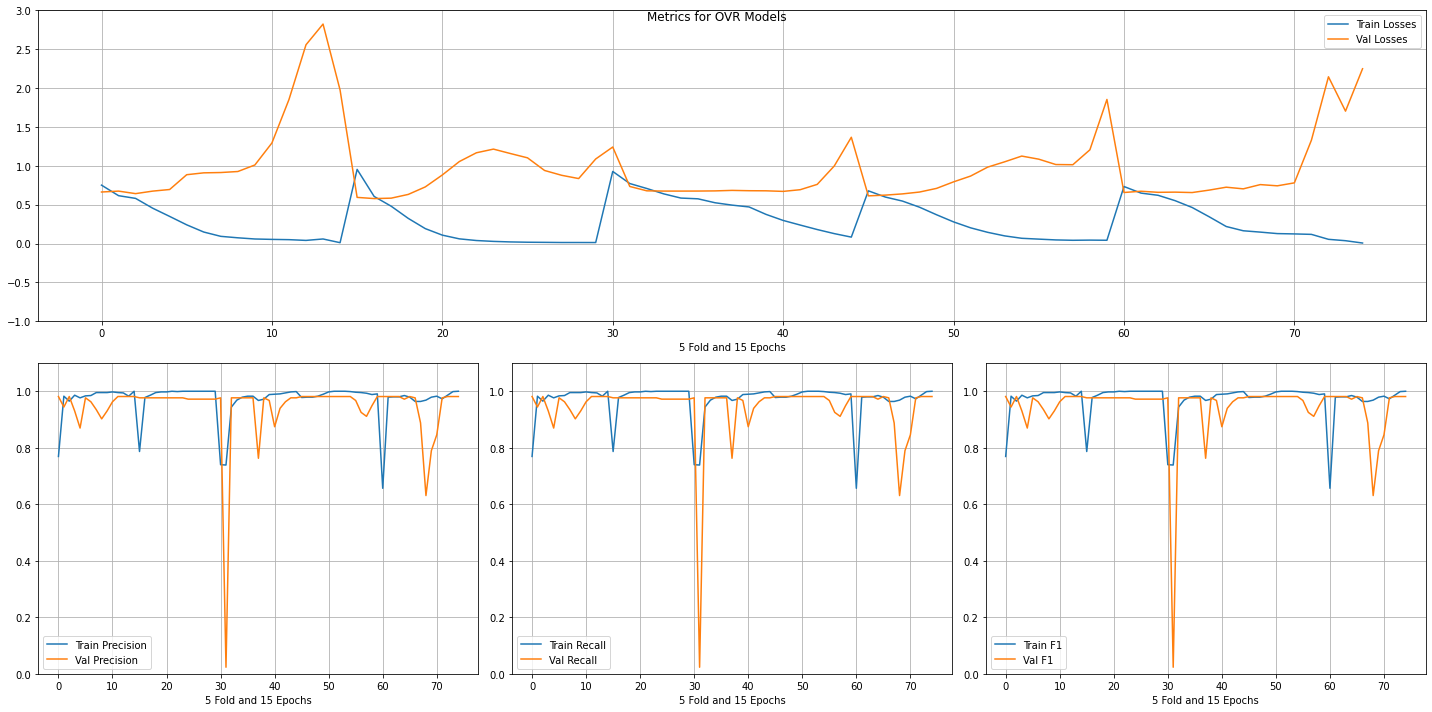

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.769231       0.981395  ...      0.751115           0.662702
11  0.995338       0.981395  ...      0.049479           1.852403
14  1.000000       0.981395  ...      0.010469           1.974652
13  0.982517       0.981395  ...      0.058253           2.824027
12  0.994172       0.981395  ...      0.039829           2.557538
..       ...            ...  ...           ...                ...
10  0.982538       0.845794  ...      0.123275           0.780440
9   0.979045       0.789720  ...      0.127468           0.742333
7   0.967366       0.762791  ...      0.493978           0.683520
8   0.968568       0.630841  ...      0.146579           0.758038
1   0.738928       0.023256  ...      0.771763           0.734044

[75 rows x 8 columns]
Training for ['Kalyani'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.50517891 48.77272727]
Epoch 1/15 : Training Loss: 0.839 / Validation Los

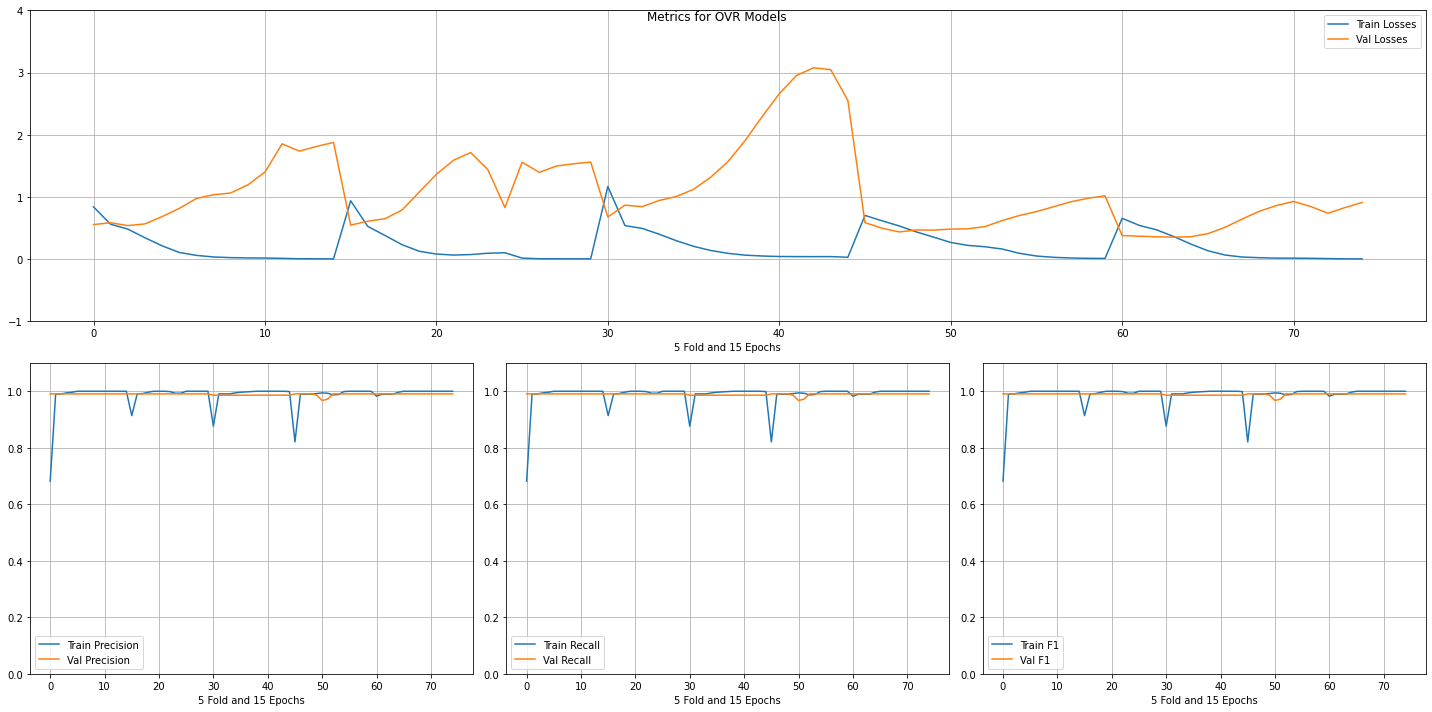

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.681818       0.990698  ...      0.839258           0.554451
1   0.990676       0.990698  ...      0.524426           0.609260
1   0.989510       0.990698  ...      0.559336           0.583925
14  1.000000       0.990698  ...      0.003121           1.560338
13  1.000000       0.990698  ...      0.003550           1.532482
..       ...            ...  ...           ...                ...
13  1.000000       0.986047  ...      0.039436           3.047216
14  0.998834       0.986047  ...      0.028049           2.551863
4   0.991851       0.985981  ...      0.353026           0.464971
6   0.993015       0.971963  ...      0.219641           0.486191
5   0.994179       0.967290  ...      0.266887           0.481678

[75 rows x 8 columns]
Training for ['Kharaharapriya'] with 135 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [0.57196162 3.97407407]
Epoch 1/15 : Training Loss: 0.786 / Validati

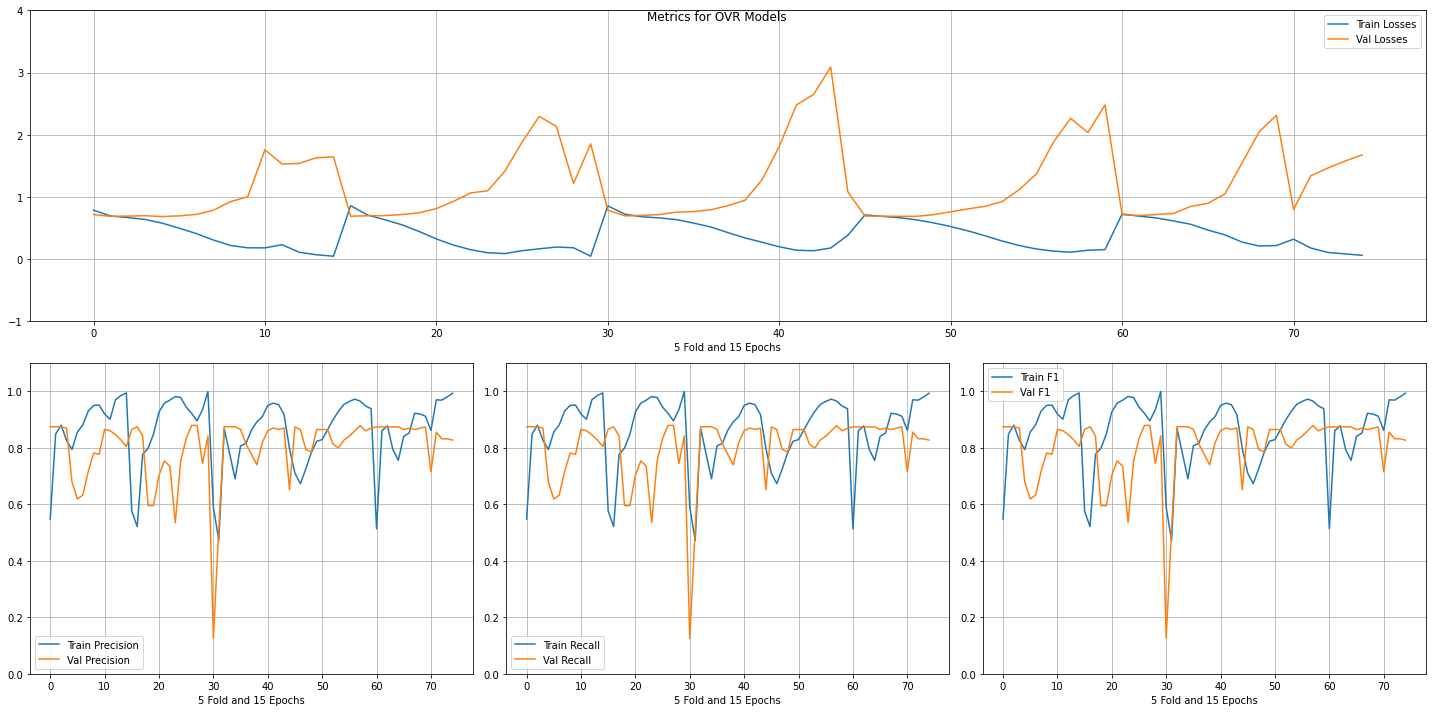

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.895105       0.879070  ...      0.193029           2.132088
11  0.921911       0.879070  ...      0.164682           2.294286
12  0.965076       0.878505  ...      0.110332           2.263916
0   0.547786       0.874419  ...      0.786215           0.716158
1   0.520979       0.874419  ...      0.706644           0.696929
..       ...            ...  ...           ...                ...
4   0.848485       0.595349  ...      0.442398           0.745174
3   0.798368       0.595349  ...      0.550224           0.715325
8   0.981352       0.534884  ...      0.101072           1.099027
1   0.472028       0.511628  ...      0.720906           0.693984
0   0.589744       0.125581  ...      0.855257           0.786087

[75 rows x 8 columns]
Training for ['Mayamalavagowla'] with 465 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [0.88240132 1.15376344]
Epoch 1/15 : Training Loss: 0.749 / Validat

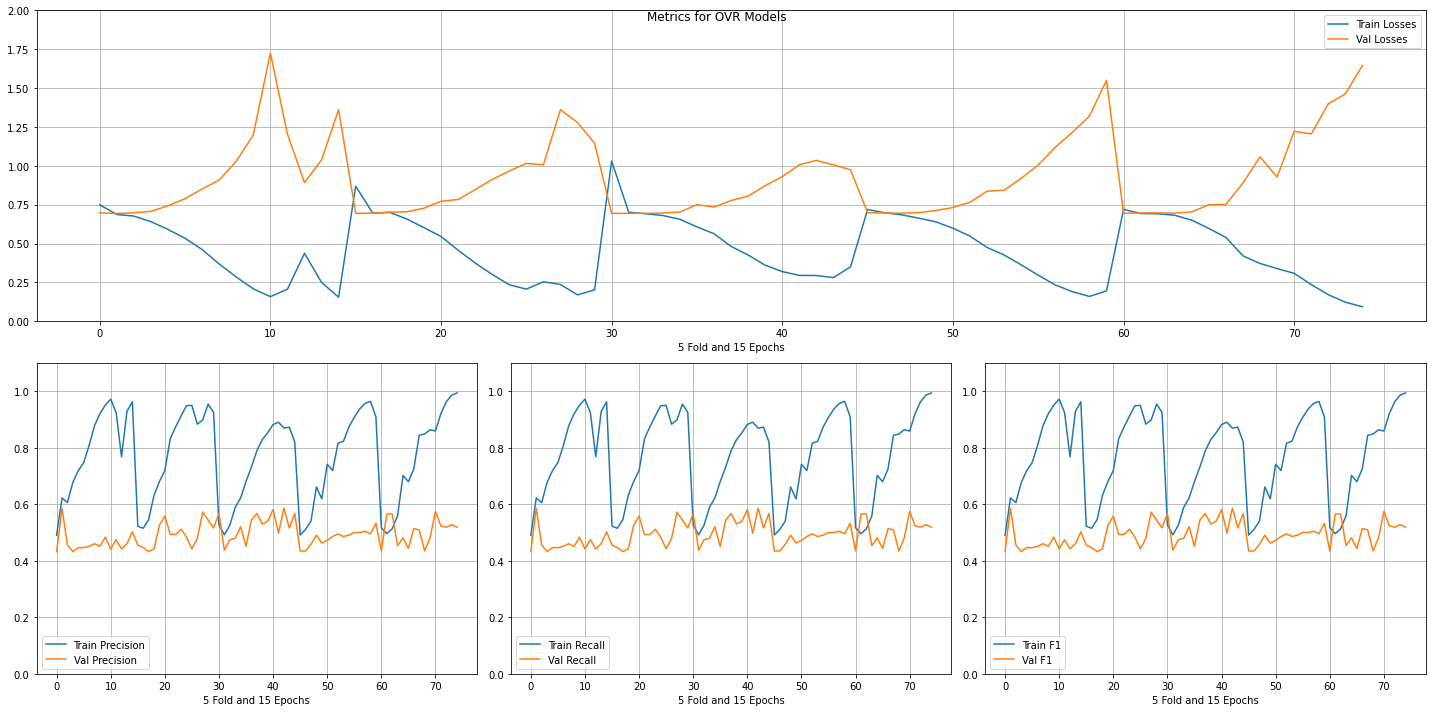

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.869464       0.586047  ...      0.294198           1.034638
1   0.622378       0.586047  ...      0.686680           0.692724
10  0.882284       0.581395  ...      0.318923           0.930204
10  0.859139       0.574766  ...      0.307839           1.222086
12  0.898601       0.572093  ...      0.236122           1.360808
..       ...            ...  ...           ...                ...
8   0.848661       0.434579  ...      0.371243           1.056995
0   0.491269       0.434579  ...      0.719017           0.698204
2   0.545455       0.432558  ...      0.700192           0.702068
3   0.677156       0.432558  ...      0.640608           0.706925
0   0.490676       0.432558  ...      0.749202           0.697199

[75 rows x 8 columns]
Training for ['Naganandini'] with 89 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [0.54522358 6.02808989]
Epoch 1/15 : Training Loss: 0.748 / Validation L

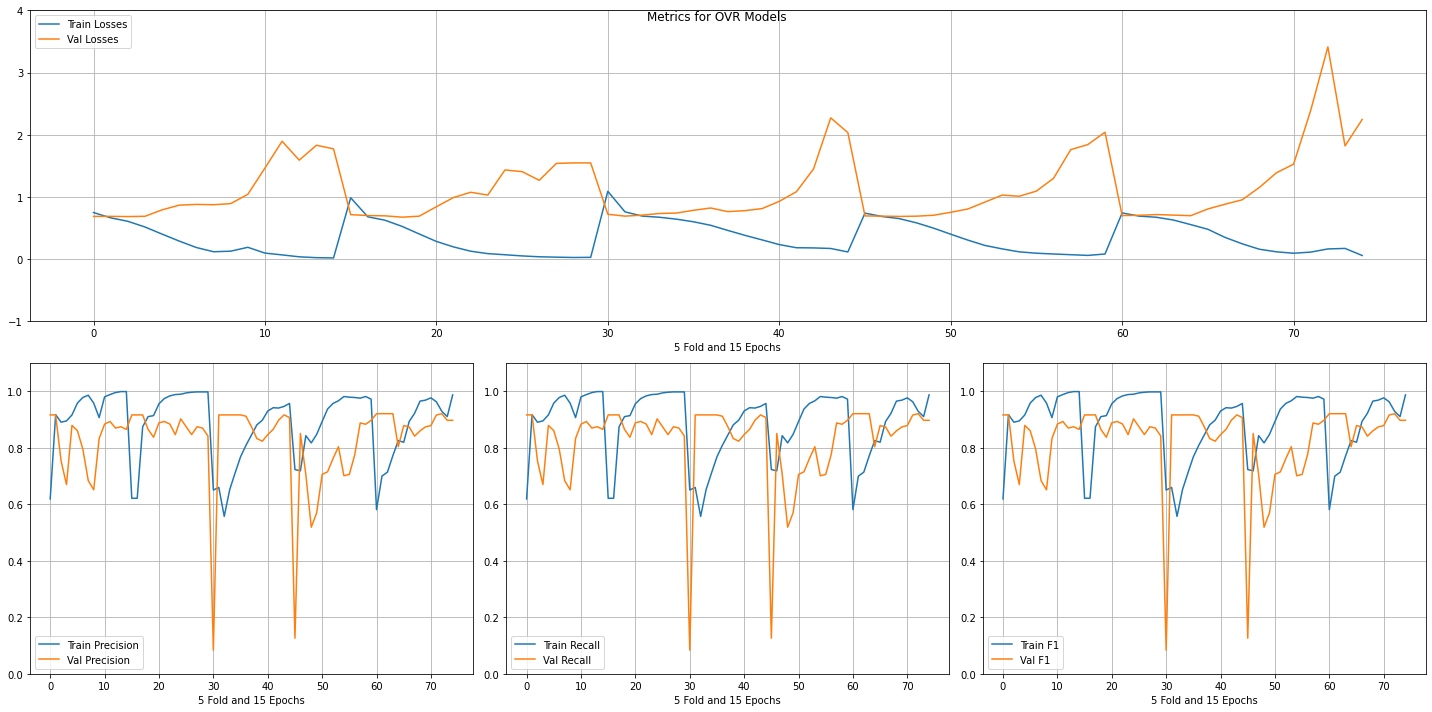

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.928987       0.920561  ...      0.162438           3.412930
3   0.771828       0.920561  ...      0.626814           0.706697
2   0.713620       0.920561  ...      0.672238           0.715445
1   0.699651       0.920561  ...      0.690091           0.703621
0   0.580908       0.920561  ...      0.741770           0.699267
..       ...            ...  ...           ...                ...
8   0.958042       0.651163  ...      0.126348           0.891573
4   0.847497       0.570093  ...      0.496878           0.704613
3   0.817229       0.518692  ...      0.582574           0.689568
0   0.722934       0.126168  ...      0.738483           0.693799
0   0.650350       0.083721  ...      1.089448           0.720373

[75 rows x 8 columns]
Training for ['Natabhairavi'] with 27 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.51290631 19.87037037]
Epoch 1/15 : Training Loss: 0.837 / Validatio

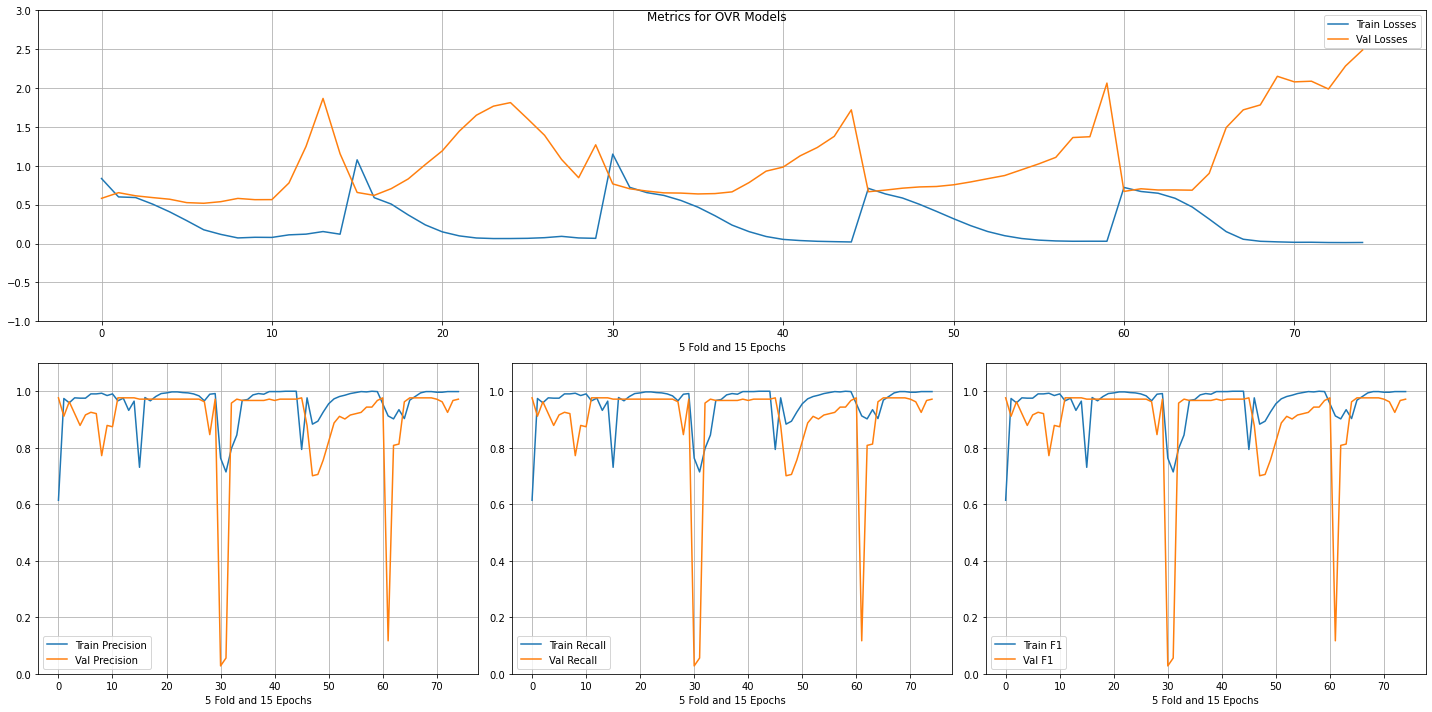

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.614219       0.976744  ...      0.836549           0.581096
11  0.966200       0.976744  ...      0.111301           0.779011
12  0.975524       0.976744  ...      0.120508           1.248761
13  0.932401       0.976744  ...      0.153685           1.867018
14  0.965035       0.976744  ...      0.119785           1.154760
..       ...            ...  ...           ...                ...
3   0.894063       0.705607  ...      0.504407           0.727999
2   0.883586       0.700935  ...      0.585588           0.711955
1   0.912689       0.116822  ...      0.669368           0.704415
1   0.714452       0.055814  ...      0.722588           0.704129
0   0.763403       0.027907  ...      1.150312           0.767169

[75 rows x 8 columns]
Training for ['Shankarabharanam'] with 136 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [0.57257204 3.94485294]
Epoch 1/15 : Training Loss: 0.740 / Valida

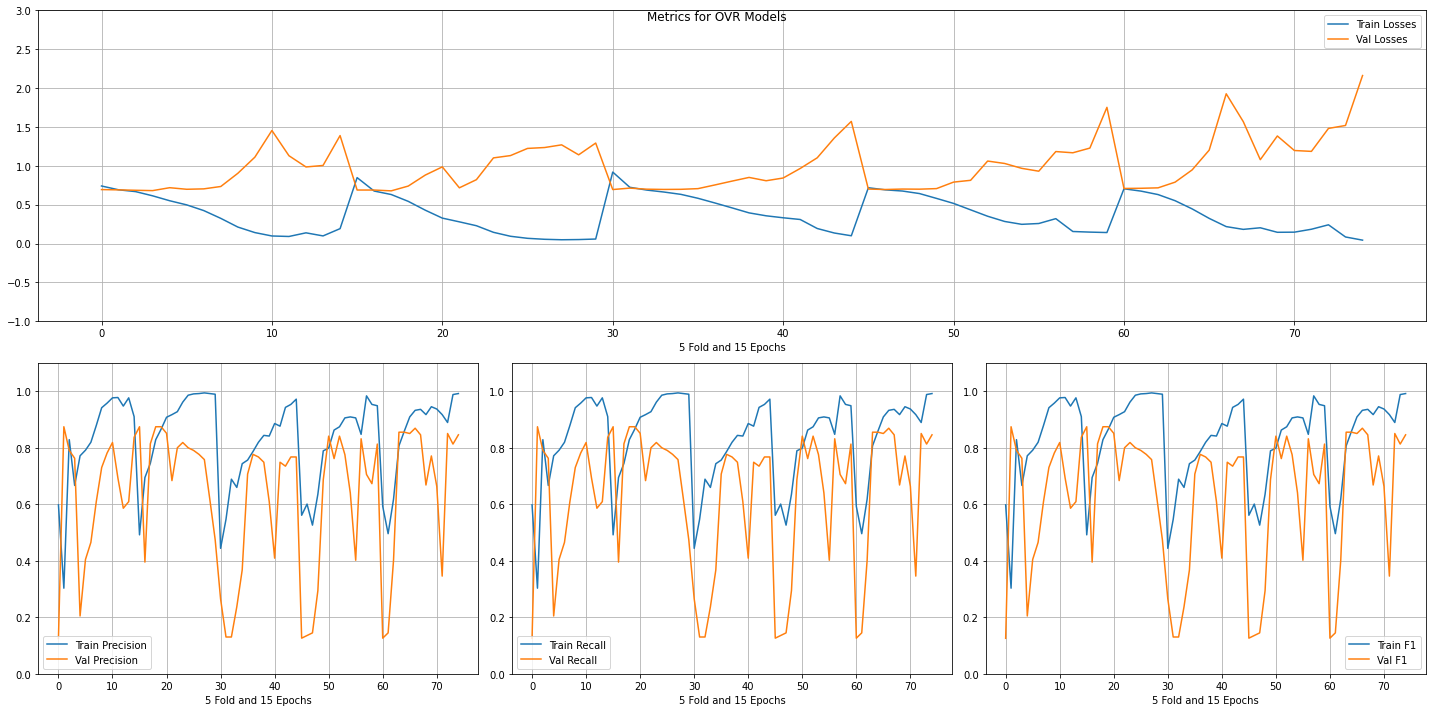

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.303030       0.874419  ...      0.691187           0.690305
4   0.865967       0.874419  ...      0.428706           0.880721
3   0.828671       0.874419  ...      0.542426           0.739163
0   0.491841       0.874419  ...      0.847867           0.688130
6   0.932480       0.869159  ...      0.217478           1.926766
..       ...            ...  ...           ...                ...
1   0.546620       0.130233  ...      0.723642           0.712801
2   0.688811       0.130233  ...      0.687407           0.699013
0   0.592549       0.126168  ...      0.704096           0.708405
0   0.561118       0.126168  ...      0.717712           0.700667
0   0.597902       0.125581  ...      0.740217           0.693932

[75 rows x 8 columns]
Training for ['Shubhapantuvarali'] with 32 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.51536984 16.765625  ]
Epoch 1/15 : Training Loss: 0.870 / Vali

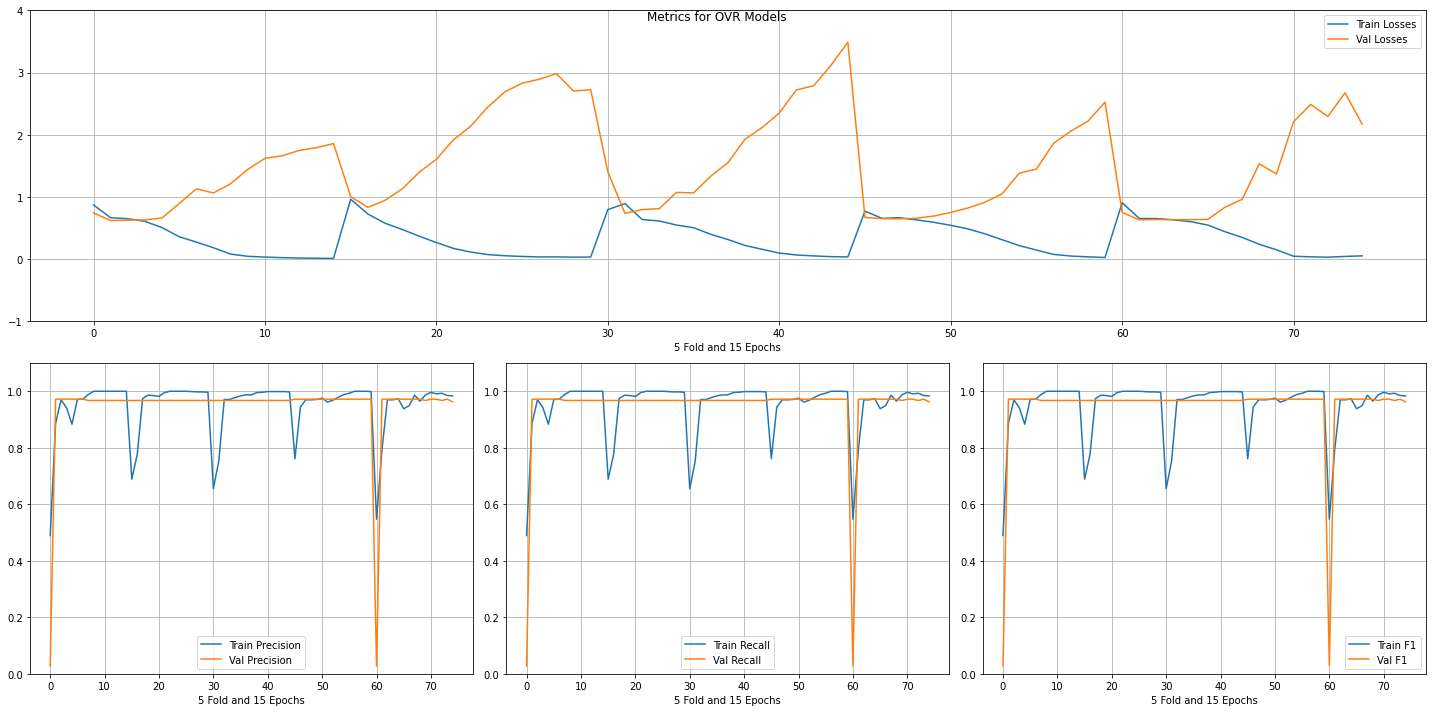

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.886946       0.972093  ...      0.663341           0.619442
2   0.969697       0.972093  ...      0.649610           0.625665
3   0.941725       0.972093  ...      0.605884           0.629013
4   0.883450       0.972093  ...      0.505555           0.662220
5   0.970862       0.972093  ...      0.358798           0.893244
..       ...            ...  ...           ...                ...
9   0.987194       0.967290  ...      0.148828           1.367902
12  0.993015       0.967290  ...      0.029534           2.292481
14  0.983702       0.962617  ...      0.051355           2.170312
0   0.547148       0.028037  ...      0.905665           0.749898
0   0.489510       0.027907  ...      0.869998           0.741800

[75 rows x 8 columns]
Training for ['Vakulabharanam'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.52188716 11.92222222]
Epoch 1/15 : Training Loss: 0.774 / Validat

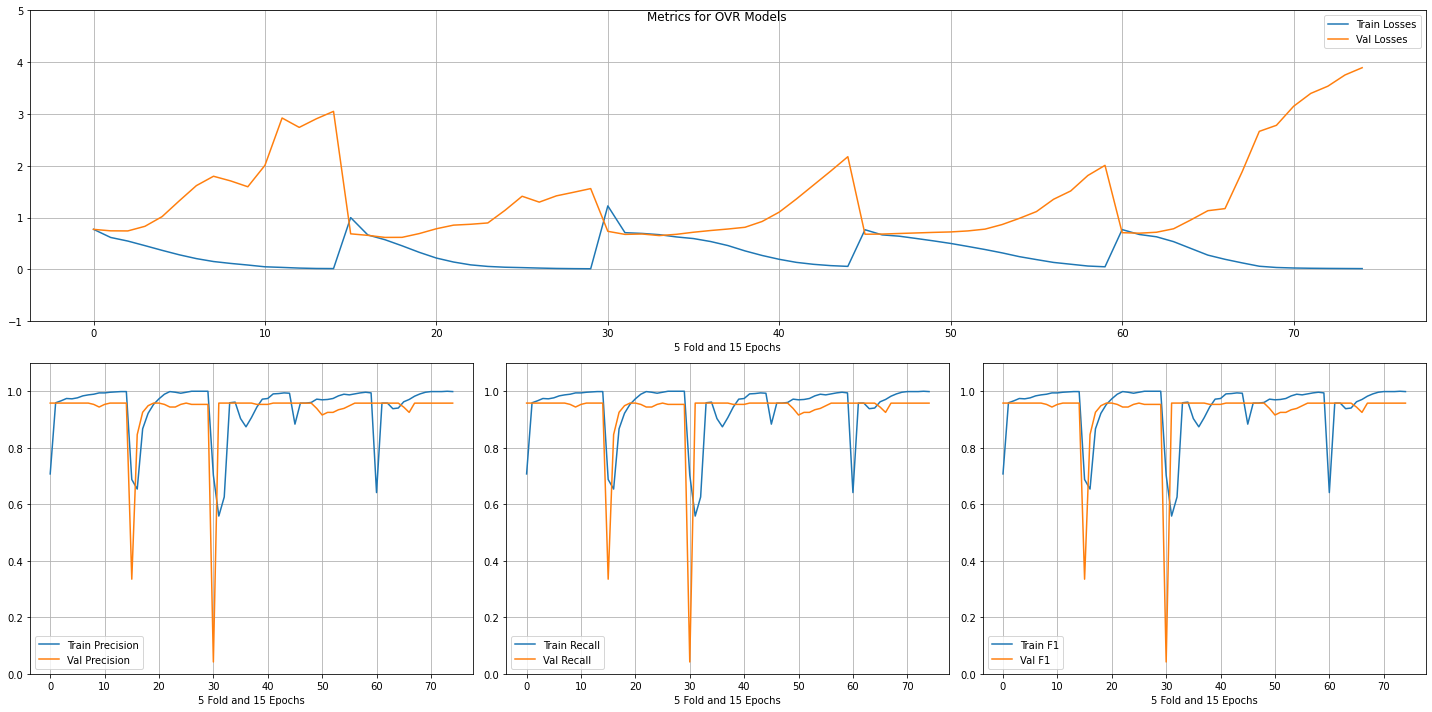

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.707459       0.958140  ...      0.773865           0.772854
4   0.953380       0.958140  ...      0.329728           0.691551
14  0.993007       0.958140  ...      0.058226           2.175829
13  0.994172       0.958140  ...      0.072857           1.897799
12  0.991841       0.958140  ...      0.097990           1.628715
..       ...            ...  ...           ...                ...
6   0.970896       0.925234  ...      0.443259           0.742861
5   0.969732       0.915888  ...      0.500911           0.723186
1   0.653846       0.846512  ...      0.665093           0.657126
0   0.687646       0.334884  ...      1.000156           0.686645
0   0.702797       0.041860  ...      1.225870           0.735088

[75 rows x 8 columns]


In [33]:
mc = jle.transform(['Unknown'])
data = data[data['JanakaRagamCode']!=mc[0]]
jle = LabelEncoder()
jle.fit(data['janaka_ragam'])
data['JanakaRagamCode'] = data.apply(lambda x:jle.transform([x.janaka_ragam])[0],axis=1)
labels = jle.transform(jle.classes_)
n_labels = len(data['JanakaRagamCode'].unique())

jlabels = jle.transform(jle.classes_)
jovr_res = ovr_train_model(data, ChromaJanakaRagaDataset, ChromaRaga, "OVR Models", jlabels, jle.classes_,
                           lbl_encoder=jle, target='JanakaRagamCode', lr=1e-3, epochs=15, n_folds=5, feature='chroma')

In [34]:
for k in jovr_res:
  print(jle.inverse_transform([k]))
  print(results_to_df(jovr_res[k]).head())

['Chalanata']
    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.615385       0.976744  ...      1.262428           1.004443
13  0.995338       0.976744  ...      0.103952           1.355394
1   0.884615       0.976744  ...      0.661820           0.661921
0   0.547786       0.976744  ...      0.987298           0.756009
4   0.977855       0.976744  ...      0.600334           0.649554

[5 rows x 8 columns]
['Hanumatodi']
    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.989510       0.981395  ...      0.424324           0.655963
5   0.981352       0.981395  ...      0.555363           0.646771
8   1.000000       0.981395  ...      0.033420           1.794710
9   1.000000       0.981395  ...      0.026424           2.062909
10  1.000000       0.981395  ...      0.020879           2.374134

[5 rows x 8 columns]
['Harikambhoji']
    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.520979       0.939535  ...      0.736078      

# OVR Experiment without Mayamalavagowla Raga

In [35]:
cl = jle.classes_
mc = jle.transform(['Mayamalavagowla'])
rdata = data[data['JanakaRagamCode']!=mc[0]]
cl = [x for x in cl if not x in ['Mayamalavagowla'] ]
jlabels1 = jle.transform(cl)

Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.51192748 21.46      ]
Epoch 1/15 : Training Loss: 0.820 / Validation Loss : 0.715 [Time Taken : 0.210573 seconds]
Epoch 2/15 : Training Loss: 0.662 / Validation Loss : 0.662 [Time Taken : 0.218021 seconds]
Epoch 3/15 : Training Loss: 0.586 / Validation Loss : 0.648 [Time Taken : 0.206636 seconds]
Epoch 4/15 : Training Loss: 0.495 / Validation Loss : 0.634 [Time Taken : 0.211905 seconds]
Epoch 5/15 : Training Loss: 0.409 / Validation Loss : 0.622 [Time Taken : 0.20534 seconds]
Epoch 6/15 : Training Loss: 0.317 / Validation Loss : 0.614 [Time Taken : 0.2129 seconds]
Epoch 7/15 : Training Loss: 0.220 / Validation Loss : 0.673 [Time Taken : 0.207539 seconds]
Epoch 8/15 : Training Loss: 0.145 / Validation Loss : 0.683 [Time Taken : 0.200314 seconds]
Epoch 9/15 : Training Loss: 0.121 / Validation Loss : 0.634 [Time Taken : 0.20641 seconds]
Epoch 10/15 : Training Loss: 0.104 / Va

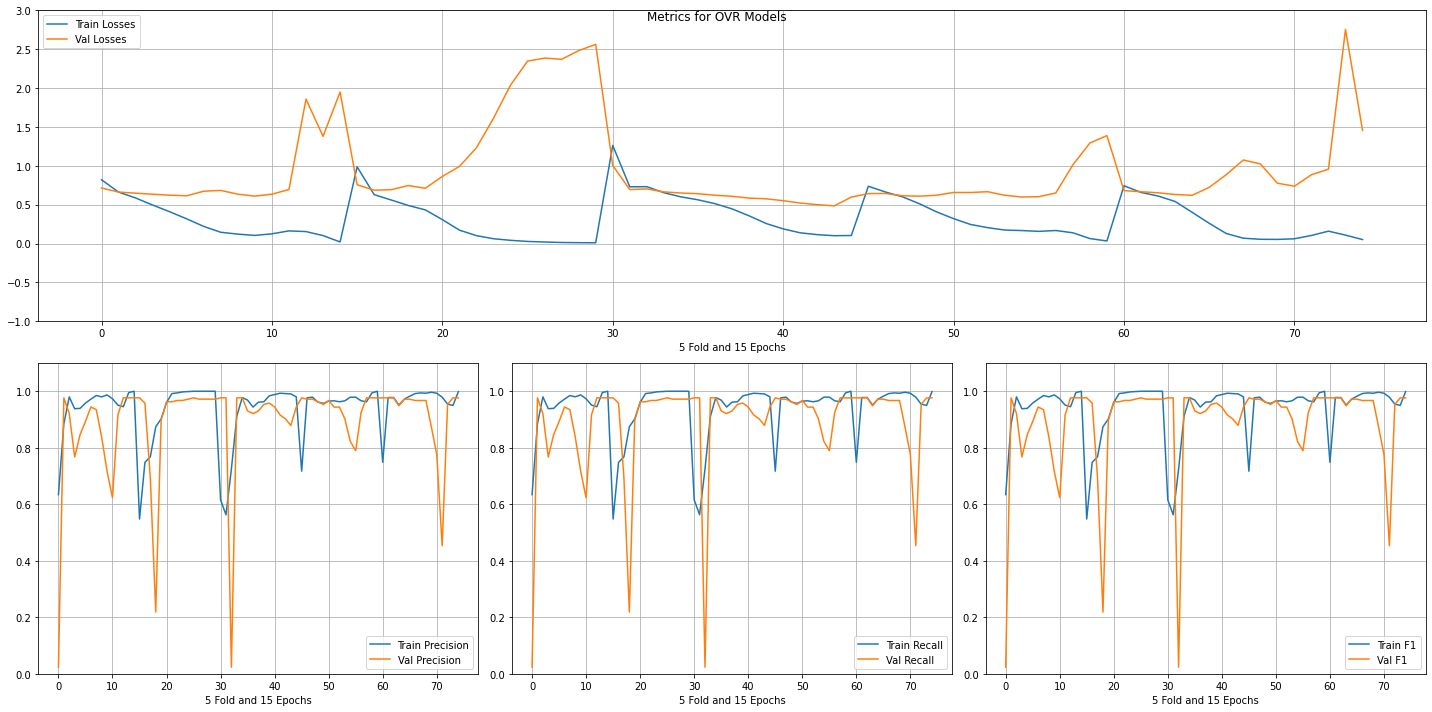

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.615385       0.976744  ...      1.262428           1.004443
13  0.995338       0.976744  ...      0.101750           1.379361
1   0.884615       0.976744  ...      0.661820           0.661921
0   0.547786       0.976744  ...      0.987298           0.756009
4   0.977855       0.976744  ...      0.600343           0.649547
..       ...            ...  ...           ...                ...
10  0.973193       0.623256  ...      0.124748           0.634459
11  0.979045       0.453271  ...      0.103576           0.884928
3   0.874126       0.218605  ...      0.489536           0.745927
2   0.724942       0.023256  ...      0.731344           0.702850
0   0.634033       0.023256  ...      0.820331           0.714579

[75 rows x 8 columns]
Training for ['Hanumatodi'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.50949668 26.825     ]
Epoch 1/15 : Training Loss: 0.887 / Validation 

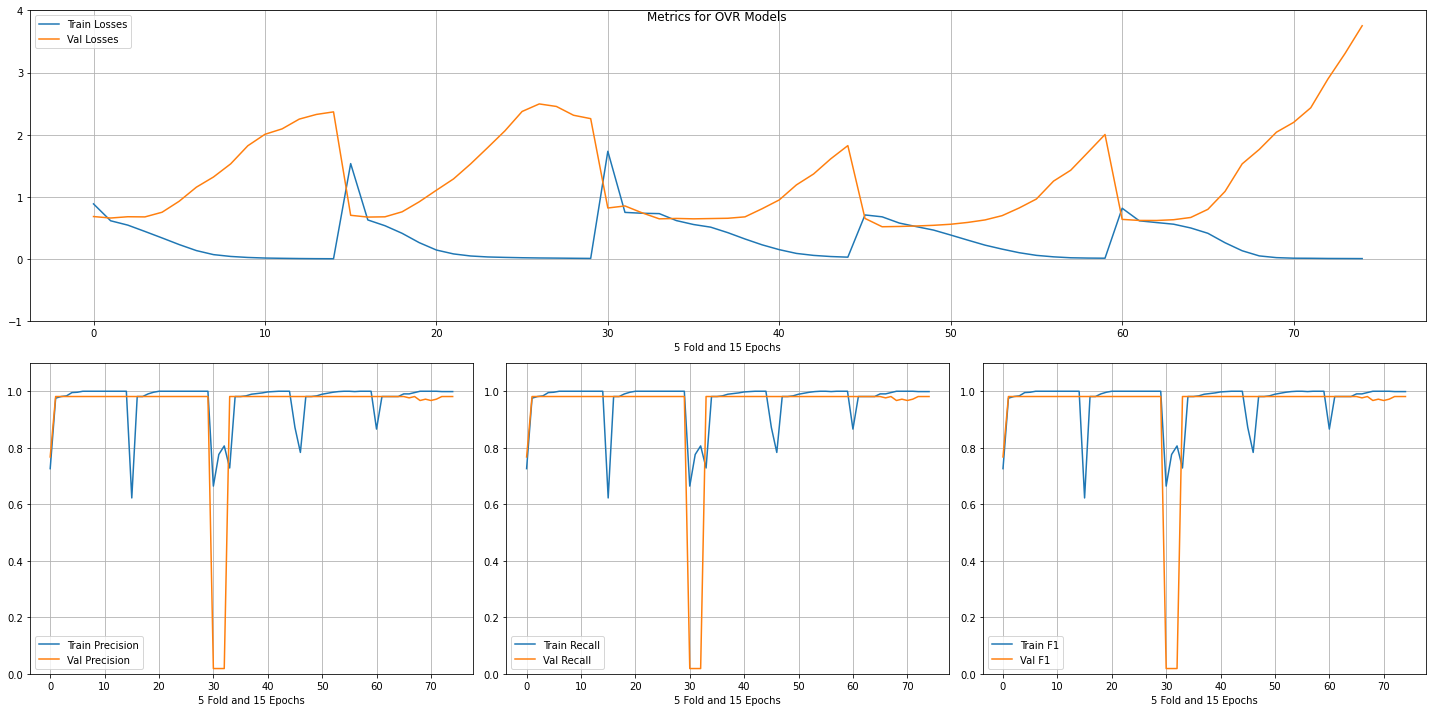

    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.989510       0.981395  ...      0.424325           0.655963
5   0.981352       0.981395  ...      0.555363           0.646771
8   1.000000       0.981395  ...      0.033420           1.794700
9   1.000000       0.981395  ...      0.026424           2.062894
10  1.000000       0.981395  ...      0.020879           2.374103
..       ...            ...  ...           ...                ...
10  1.000000       0.967290  ...      0.013744           2.197938
0   0.726107       0.767442  ...      0.887102           0.683610
2   0.806527       0.018605  ...      0.736664           0.743299
1   0.776224       0.018605  ...      0.750320           0.854018
0   0.664336       0.018605  ...      1.733541           0.821175

[75 rows x 8 columns]
Training for ['Harikambhoji'] with 66 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [0.53277061 8.12878788]
Epoch 1/15 : Training Loss: 0.736 / Validation 

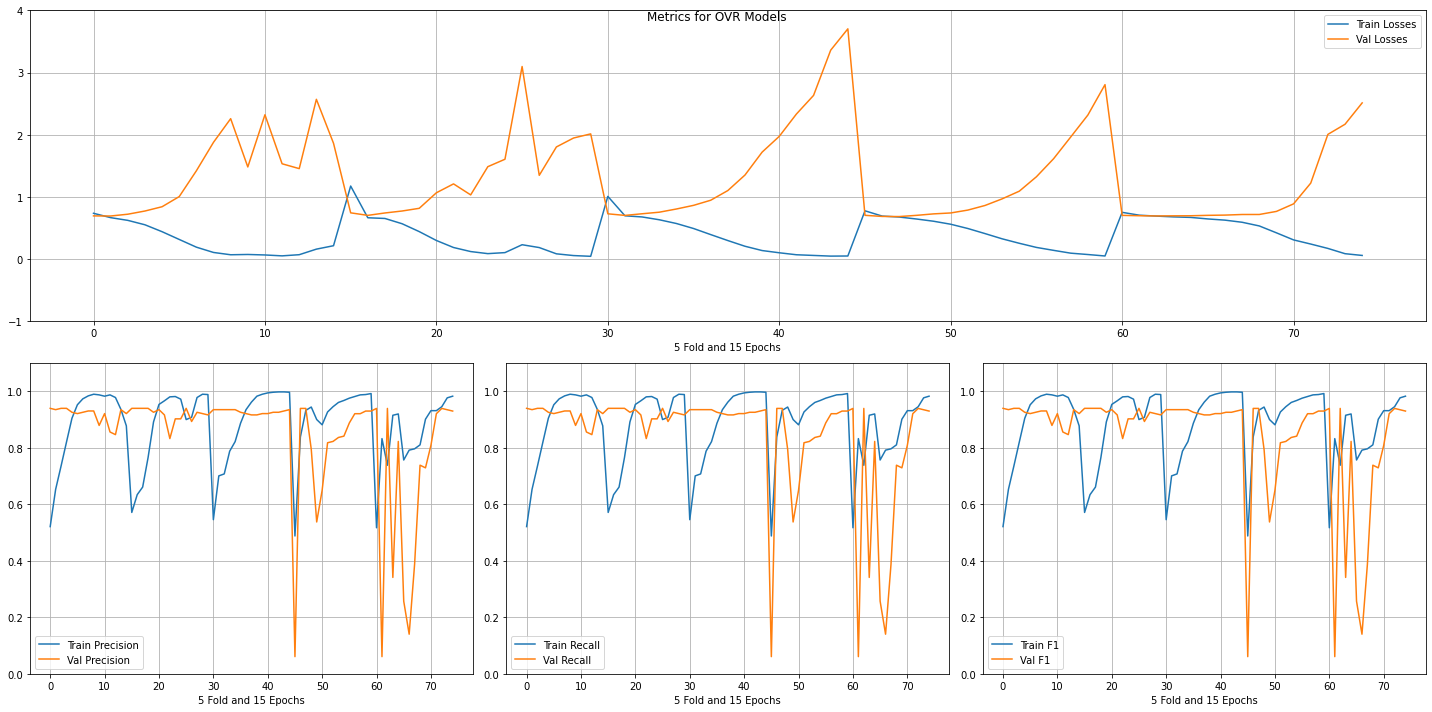

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.520979       0.939535  ...      0.736078           0.694139
2   0.735431       0.939535  ...      0.622131           0.721118
3   0.820513       0.939535  ...      0.551166           0.772506
10  0.899767       0.939535  ...      0.230293           3.097237
3   0.765734       0.939535  ...      0.567868           0.772744
..       ...            ...  ...           ...                ...
3   0.915017       0.341121  ...      0.678036           0.695188
5   0.756694       0.257009  ...      0.645058           0.702945
6   0.791618       0.140187  ...      0.625773           0.707017
0   0.487776       0.060748  ...      0.775915           0.703343
1   0.832363       0.060748  ...      0.705513           0.696628

[75 rows x 8 columns]
Training for ['Jhalavarali'] with 22 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.51046622 24.38636364]
Epoch 1/15 : Training Loss: 0.751 / Validation

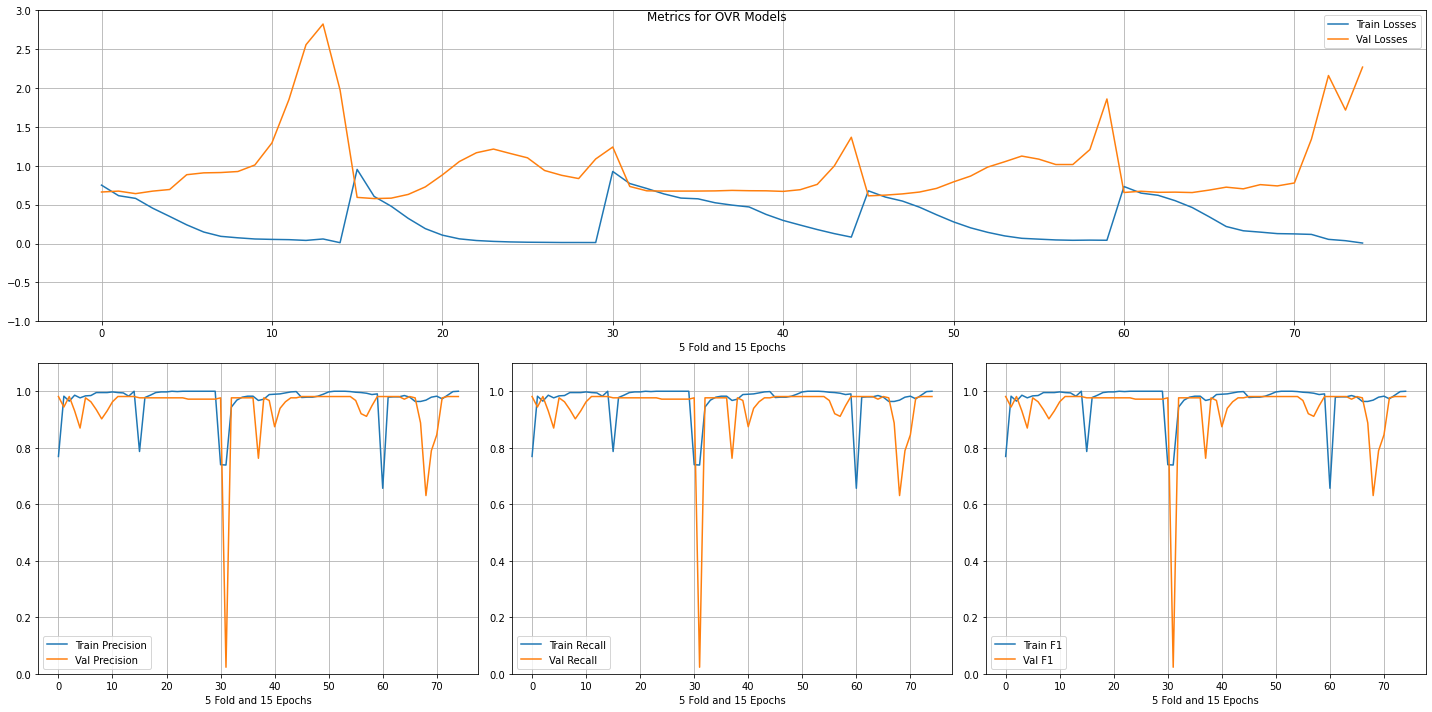

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.769231       0.981395  ...      0.751115           0.662702
11  0.995338       0.981395  ...      0.049478           1.853146
14  1.000000       0.981395  ...      0.010463           1.974577
13  0.982517       0.981395  ...      0.058278           2.824436
12  0.994172       0.981395  ...      0.039813           2.558093
..       ...            ...  ...           ...                ...
10  0.982538       0.845794  ...      0.123513           0.778860
9   0.979045       0.789720  ...      0.127204           0.741151
7   0.967366       0.762791  ...      0.494009           0.683534
8   0.968568       0.630841  ...      0.146374           0.757625
1   0.738928       0.023256  ...      0.771763           0.734044

[75 rows x 8 columns]
Training for ['Kalyani'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.50517891 48.77272727]
Epoch 1/15 : Training Loss: 0.839 / Validation Los

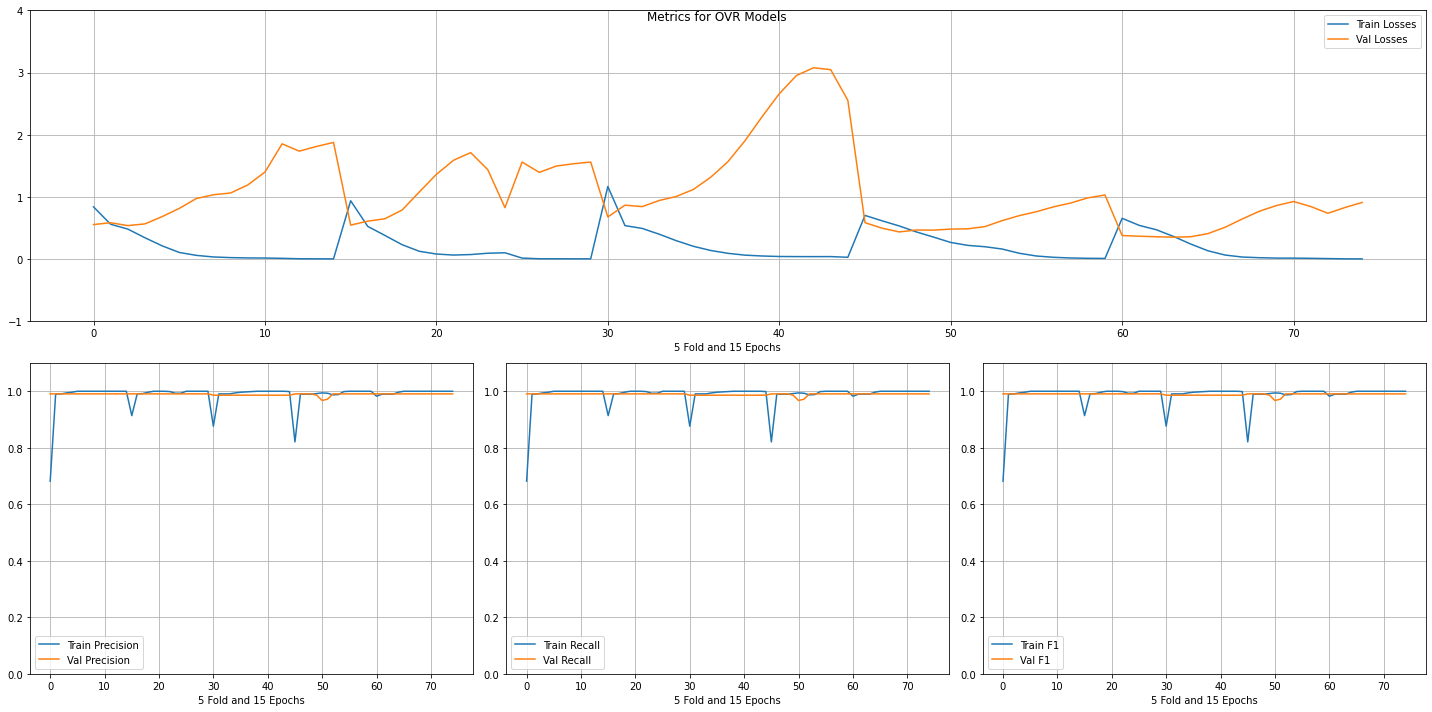

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.681818       0.990698  ...      0.839258           0.554451
1   0.990676       0.990698  ...      0.524426           0.609260
1   0.989510       0.990698  ...      0.559336           0.583925
14  1.000000       0.990698  ...      0.003118           1.560646
13  1.000000       0.990698  ...      0.003547           1.532789
..       ...            ...  ...           ...                ...
13  1.000000       0.986047  ...      0.039436           3.047245
14  0.998834       0.986047  ...      0.028056           2.552276
4   0.991851       0.985981  ...      0.353038           0.464990
6   0.993015       0.971963  ...      0.219676           0.486177
5   0.994179       0.967290  ...      0.266909           0.481650

[75 rows x 8 columns]
Training for ['Kharaharapriya'] with 135 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [0.57196162 3.97407407]
Epoch 1/15 : Training Loss: 0.786 / Validati

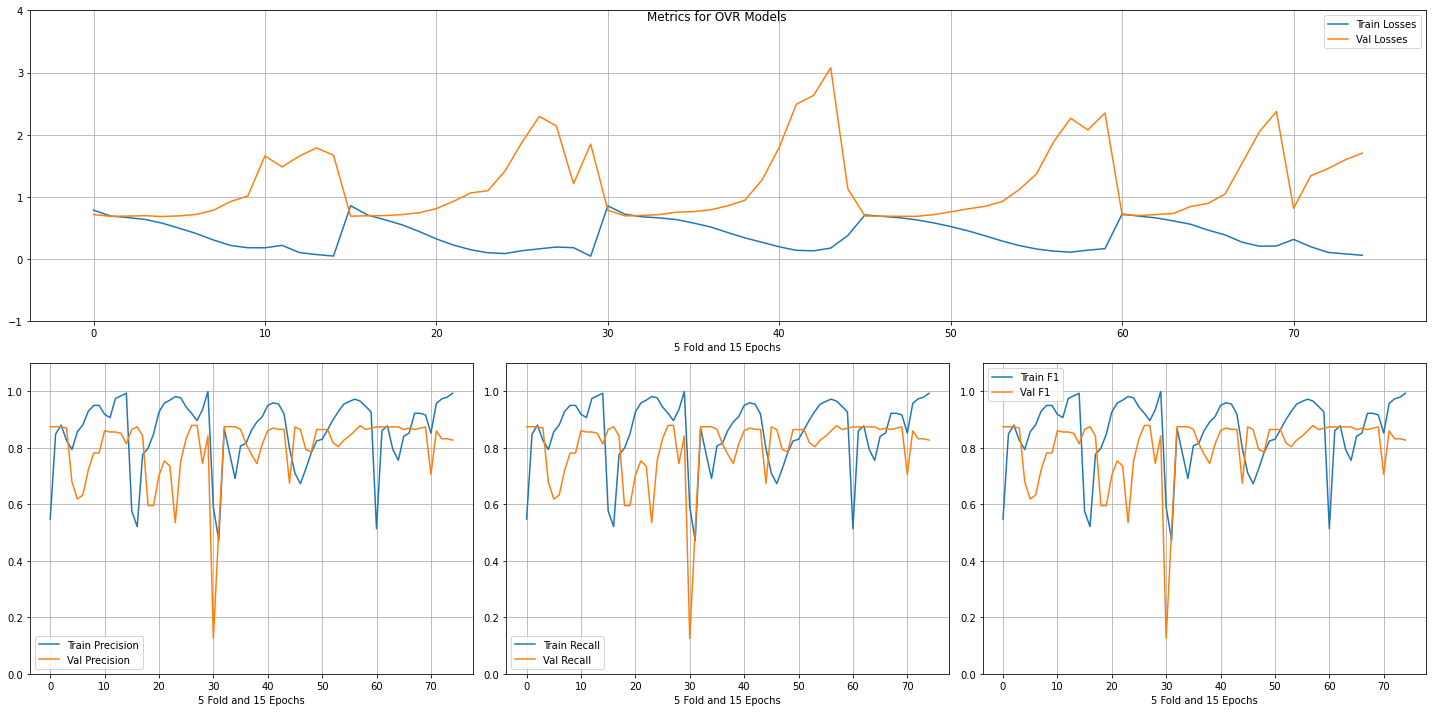

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.896270       0.879070  ...      0.192757           2.140562
11  0.921911       0.879070  ...      0.164336           2.293758
12  0.965076       0.878505  ...      0.110581           2.264810
0   0.547786       0.874419  ...      0.786215           0.716158
1   0.520979       0.874419  ...      0.706644           0.696929
..       ...            ...  ...           ...                ...
4   0.848485       0.595349  ...      0.442396           0.745172
3   0.798368       0.595349  ...      0.550224           0.715326
8   0.981352       0.534884  ...      0.101075           1.098954
1   0.472028       0.511628  ...      0.720906           0.693984
0   0.589744       0.125581  ...      0.855257           0.786087

[75 rows x 8 columns]
Training for ['Mayamalavagowla'] with 465 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [0.88240132 1.15376344]
Epoch 1/15 : Training Loss: 0.749 / Validat

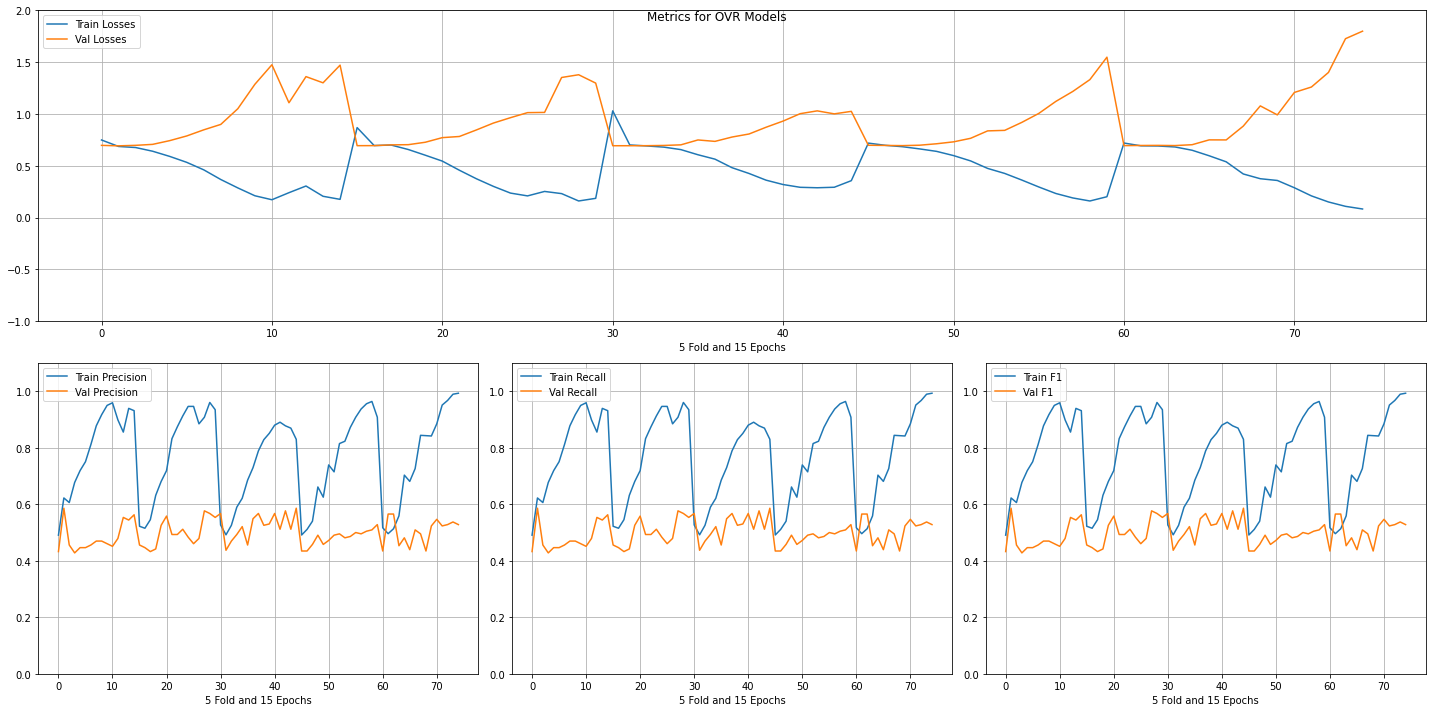

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.829837       0.586047  ...      0.356487           1.025504
1   0.622378       0.586047  ...      0.686680           0.692724
12  0.907925       0.576744  ...      0.231533           1.352494
12  0.877622       0.576744  ...      0.288103           1.030209
7   0.789044       0.567442  ...      0.481694           0.777593
..       ...            ...  ...           ...                ...
0   0.491269       0.434579  ...      0.719017           0.698204
0   0.516880       0.434579  ...      0.719762           0.694742
2   0.545455       0.432558  ...      0.700192           0.702068
0   0.490676       0.432558  ...      0.749202           0.697199
3   0.677156       0.427907  ...      0.640629           0.706877

[75 rows x 8 columns]
Training for ['Naganandini'] with 89 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [0.54522358 6.02808989]
Epoch 1/15 : Training Loss: 0.748 / Validation L

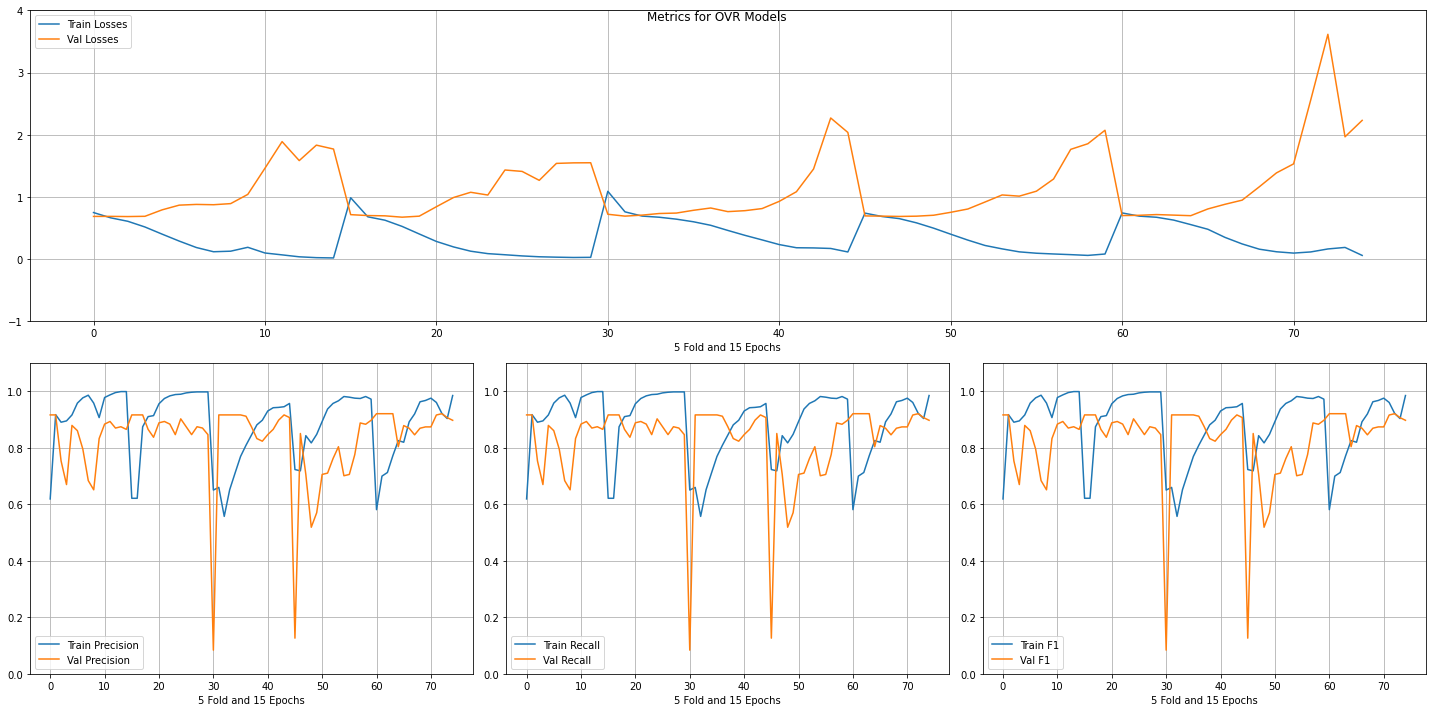

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.922002       0.920561  ...      0.162260           3.615425
3   0.771828       0.920561  ...      0.626831           0.706675
2   0.712456       0.920561  ...      0.672250           0.715448
1   0.699651       0.920561  ...      0.690091           0.703622
0   0.580908       0.920561  ...      0.741770           0.699267
..       ...            ...  ...           ...                ...
8   0.958042       0.651163  ...      0.126329           0.891637
4   0.847497       0.570093  ...      0.496872           0.704613
3   0.817229       0.518692  ...      0.582571           0.689566
0   0.722934       0.126168  ...      0.738483           0.693799
0   0.650350       0.083721  ...      1.089448           0.720373

[75 rows x 8 columns]
Training for ['Natabhairavi'] with 27 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.51290631 19.87037037]
Epoch 1/15 : Training Loss: 0.837 / Validatio

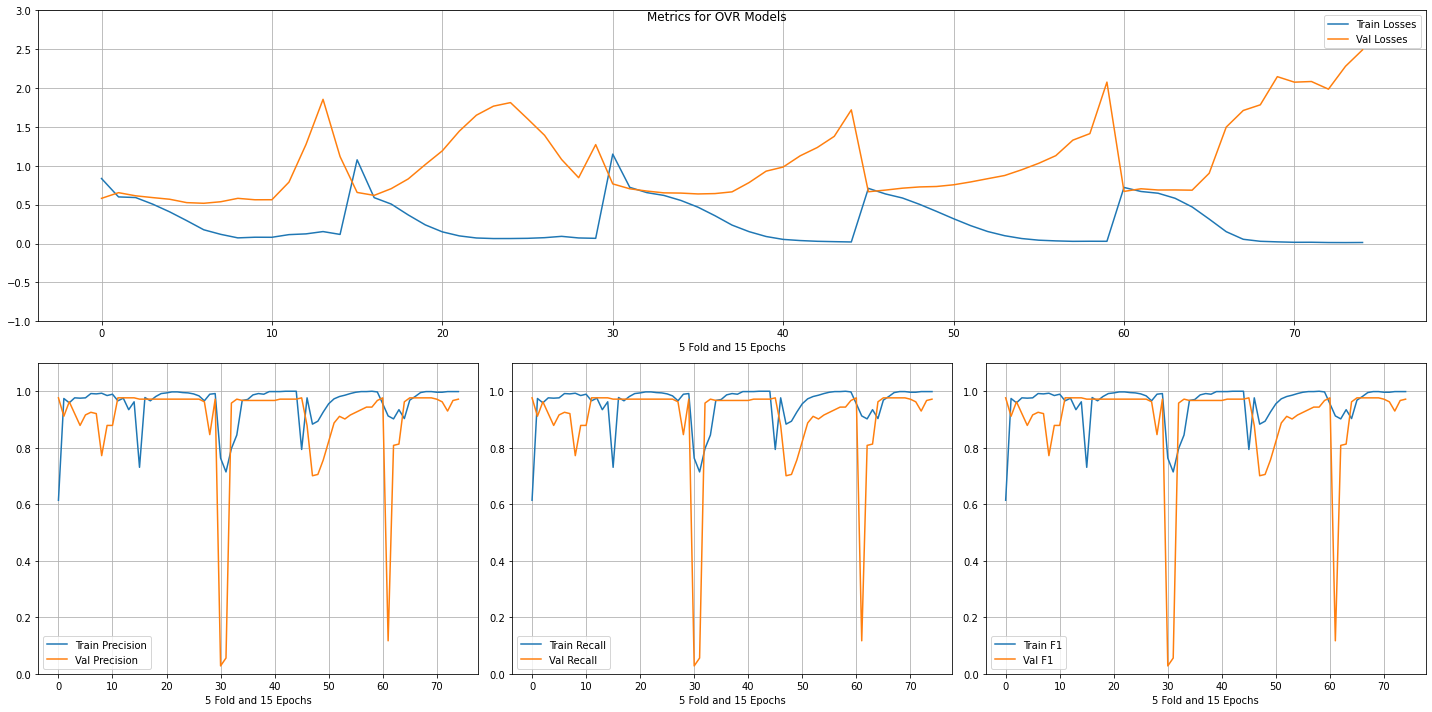

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.614219       0.976744  ...      0.836549           0.581096
11  0.966200       0.976744  ...      0.114179           0.789813
12  0.975524       0.976744  ...      0.123836           1.274414
13  0.934732       0.976744  ...      0.153465           1.855472
14  0.962704       0.976744  ...      0.116810           1.118238
..       ...            ...  ...           ...                ...
3   0.894063       0.705607  ...      0.504413           0.727985
2   0.883586       0.700935  ...      0.585588           0.711946
1   0.912689       0.116822  ...      0.669368           0.704415
1   0.714452       0.055814  ...      0.722588           0.704129
0   0.763403       0.027907  ...      1.150312           0.767169

[75 rows x 8 columns]
Training for ['Shankarabharanam'] with 136 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [0.57257204 3.94485294]
Epoch 1/15 : Training Loss: 0.740 / Valida

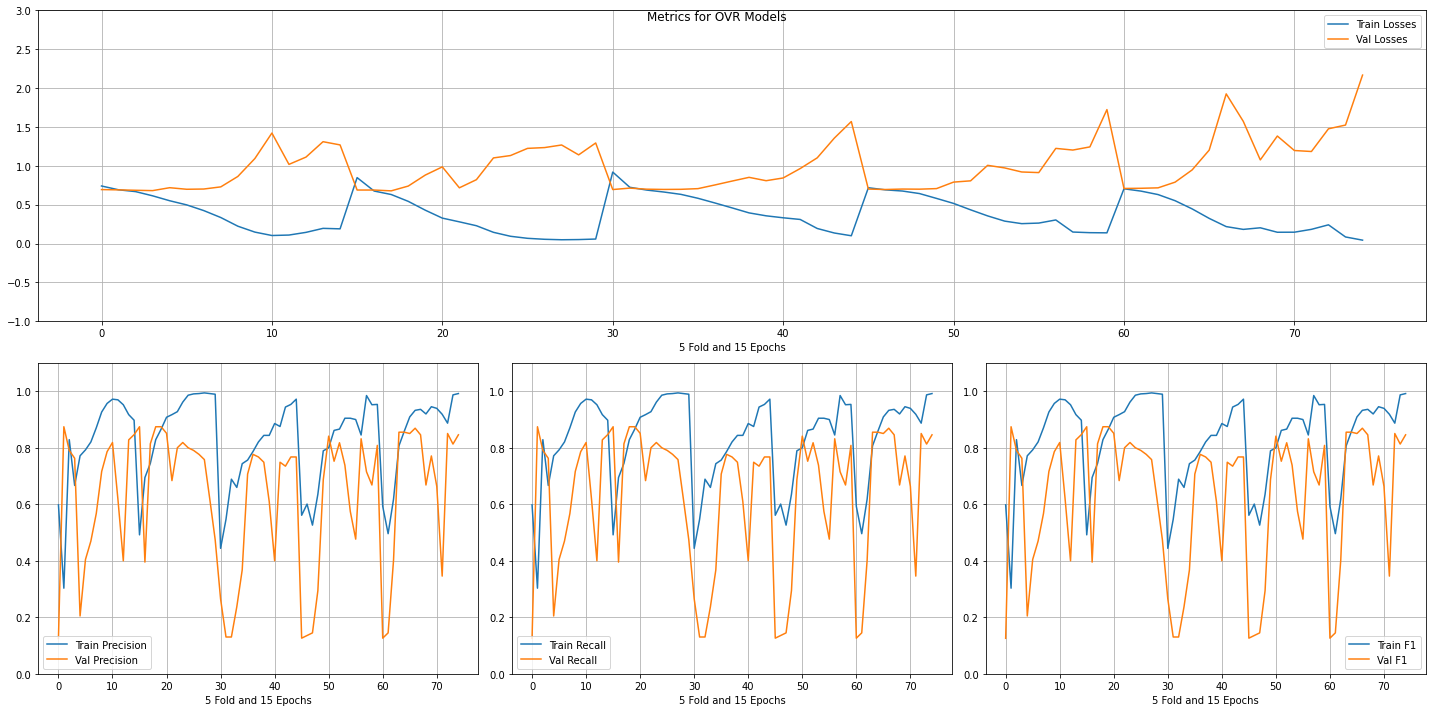

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.303030       0.874419  ...      0.691187           0.690305
4   0.865967       0.874419  ...      0.428707           0.880727
3   0.828671       0.874419  ...      0.542426           0.739165
0   0.491841       0.874419  ...      0.847867           0.688130
6   0.932480       0.869159  ...      0.217460           1.925509
..       ...            ...  ...           ...                ...
1   0.546620       0.130233  ...      0.723642           0.712801
2   0.688811       0.130233  ...      0.687407           0.699014
0   0.592549       0.126168  ...      0.704096           0.708405
0   0.561118       0.126168  ...      0.717712           0.700667
0   0.597902       0.125581  ...      0.740217           0.693932

[75 rows x 8 columns]
Training for ['Shubhapantuvarali'] with 32 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.51536984 16.765625  ]
Epoch 1/15 : Training Loss: 0.870 / Vali

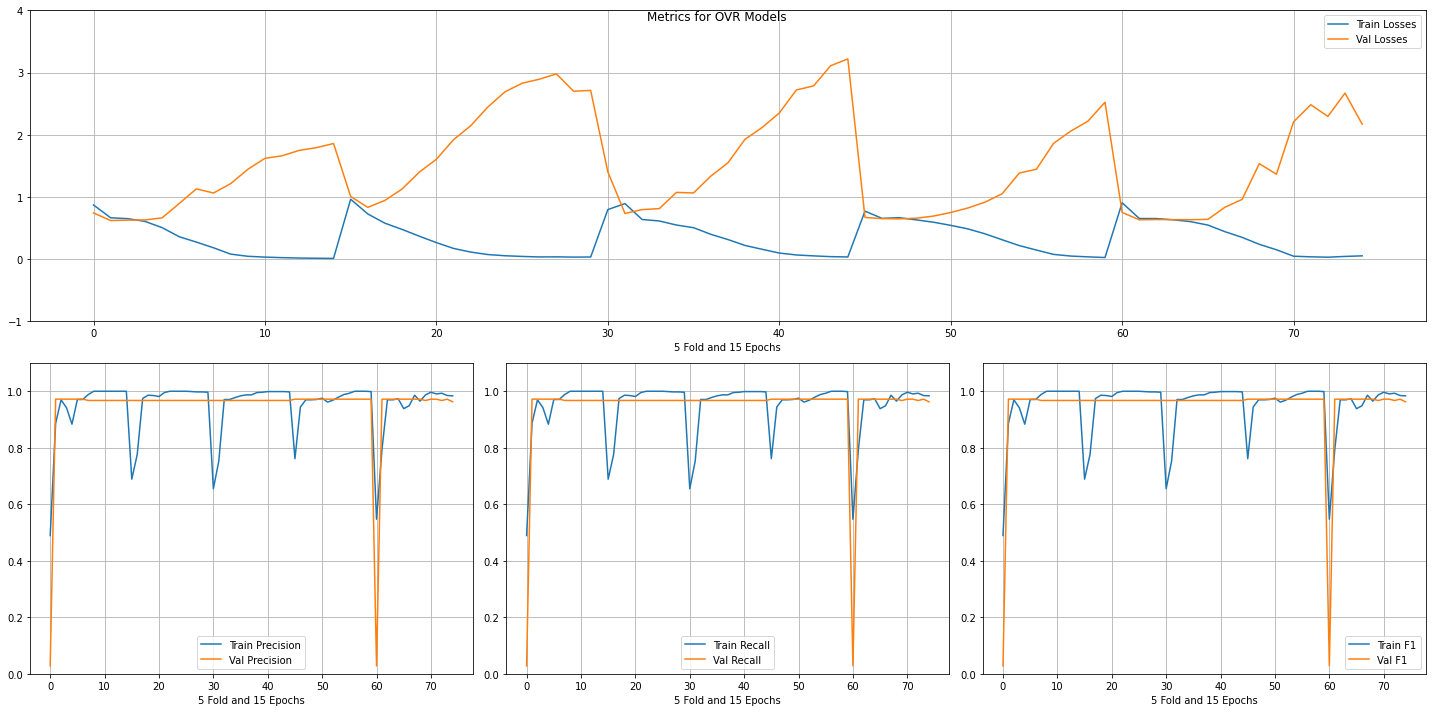

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.886946       0.972093  ...      0.663341           0.619442
2   0.969697       0.972093  ...      0.649610           0.625665
3   0.941725       0.972093  ...      0.605884           0.629013
4   0.883450       0.972093  ...      0.505555           0.662221
5   0.970862       0.972093  ...      0.358799           0.893238
..       ...            ...  ...           ...                ...
9   0.987194       0.967290  ...      0.149184           1.364674
12  0.993015       0.967290  ...      0.029638           2.294555
14  0.983702       0.962617  ...      0.051450           2.169934
0   0.547148       0.028037  ...      0.905665           0.749898
0   0.489510       0.027907  ...      0.869998           0.741800

[75 rows x 8 columns]
Training for ['Vakulabharanam'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.52188716 11.92222222]
Epoch 1/15 : Training Loss: 0.774 / Validat

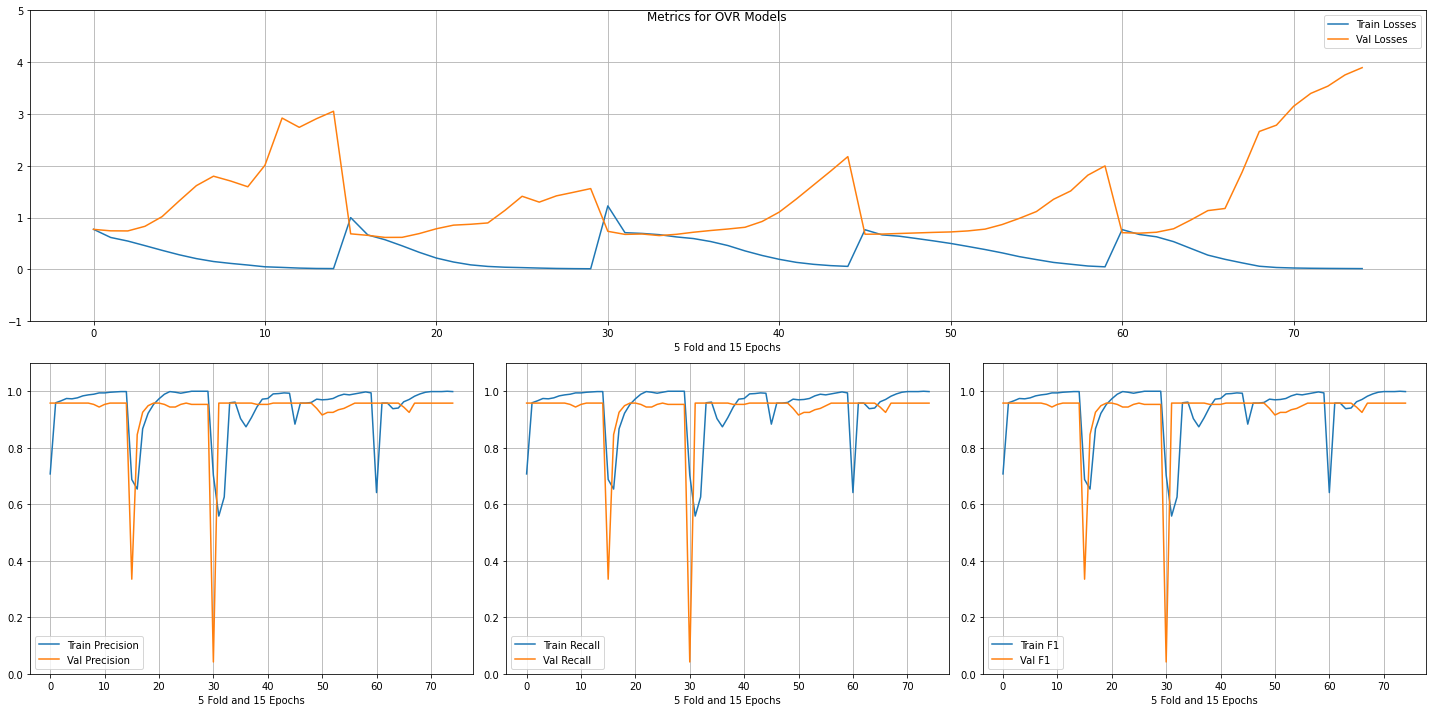

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.707459       0.958140  ...      0.773865           0.772854
4   0.953380       0.958140  ...      0.329732           0.691498
14  0.993007       0.958140  ...      0.058161           2.177190
13  0.994172       0.958140  ...      0.072822           1.898473
12  0.991841       0.958140  ...      0.097961           1.629319
..       ...            ...  ...           ...                ...
6   0.970896       0.925234  ...      0.443262           0.742847
5   0.969732       0.915888  ...      0.500912           0.723173
1   0.653846       0.846512  ...      0.665093           0.657126
0   0.687646       0.334884  ...      1.000156           0.686645
0   0.702797       0.041860  ...      1.225870           0.735087

[75 rows x 8 columns]


In [36]:
jovr_res_reduced = ovr_train_model(data, ChromaJanakaRagaDataset, ChromaRaga, "OVR Models", jlabels, jle.classes_, lbl_encoder=jle, 
                                   target='JanakaRagamCode', lr=1e-3, epochs=15, n_folds=5, feature='chroma')

In [37]:
for k in jovr_res_reduced:
  print(jle.inverse_transform([k]))
  print(results_to_df(jovr_res_reduced[k]).head())

['Chalanata']
    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.615385       0.976744  ...      1.262428           1.004443
13  0.995338       0.976744  ...      0.101750           1.379361
1   0.884615       0.976744  ...      0.661820           0.661921
0   0.547786       0.976744  ...      0.987298           0.756009
4   0.977855       0.976744  ...      0.600343           0.649547

[5 rows x 8 columns]
['Hanumatodi']
    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.989510       0.981395  ...      0.424325           0.655963
5   0.981352       0.981395  ...      0.555363           0.646771
8   1.000000       0.981395  ...      0.033420           1.794700
9   1.000000       0.981395  ...      0.026424           2.062894
10  1.000000       0.981395  ...      0.020879           2.374103

[5 rows x 8 columns]
['Harikambhoji']
    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.520979       0.939535  ...      0.736078      

# OVR Experiment 2 - LSTM Model

In [38]:
class ChromaLstmModel(nn.Module):
    def __init__(self, n_labels, dropout=0.25, n_layers=1):
        super().__init__()
        self.input_dim = 12
        self.hidden_dim = self.input_dim
        self.n_layers = n_layers
        self.seq_len = 1876
        self.n_labels = n_labels
        self.rnn = nn.LSTM(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Sequential(nn.Linear(2*self.hidden_dim,40),
                                nn.GELU(),
                                nn.Linear(40,self.n_labels))

    def forward(self,x,h):
        x = x.reshape((x.shape[0],x.shape[2],x.shape[3]))
        out, (hn, cn) = self.rnn(x.permute(0, 2, 1), h)
        x_forward = out[range(len(out)), self.seq_len - 1, :self.hidden_dim]
        x_reverse = out[:, 0, self.hidden_dim:]
        x = torch.cat((x_forward, x_reverse), 1)
        x = self.fc(x)
        return x
    
    def init_hidden(self, batch_size, target_device):
        weight = next(self.parameters()).data
        # Bi directional LSTM
        hidden = (weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device),
                  weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device))
        return hidden

In [43]:
def ovr_train_model_lstm(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, 
                         target='RagamCode', feature='mfcc', epochs=20, lr=1e-3, k_folds=2):
  results = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if lbl_encoder: print(f'Training for {lbl_encoder.inverse_transform([i])} with {nsamples} positive samples')
    ndata = pd.DataFrame()
    ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
    ndata[feature] = data[feature]
    results[i] = train_model(ndata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : True,
                                   'lr' : lr,
                                   'clip_at' : None,
                                   'k_folds' : k_folds,
                                   'balance_classes' : True,
                                   'dropout' : 0.1,
                                   'title' : title,
                                   'plot' : True,
                                   'epochs' : epochs,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target})
    print(results_to_df(results[i]))
  return results

Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 486/122
Class Weights : [ 0.52144082 12.16      ]
Epoch 1/25 : Training Loss: 0.716 / Validation Loss : 0.696 [Time Taken : 1.483308 seconds]
Epoch 2/25 : Training Loss: 0.696 / Validation Loss : 0.693 [Time Taken : 1.506926 seconds]
Epoch 3/25 : Training Loss: 0.682 / Validation Loss : 0.694 [Time Taken : 1.487528 seconds]
Epoch 4/25 : Training Loss: 0.672 / Validation Loss : 0.699 [Time Taken : 1.505623 seconds]
Epoch 5/25 : Training Loss: 0.666 / Validation Loss : 0.705 [Time Taken : 1.475768 seconds]
Epoch 6/25 : Training Loss: 0.662 / Validation Loss : 0.710 [Time Taken : 1.499274 seconds]
Epoch 7/25 : Training Loss: 0.661 / Validation Loss : 0.713 [Time Taken : 1.49551 seconds]
Epoch 8/25 : Training Loss: 0.659 / Validation Loss : 0.714 [Time Taken : 1.491243 seconds]
Epoch 9/25 : Training Loss: 0.657 / Validation Loss : 0.714 [Time Taken : 1.477764 seconds]
Epoch 10/25 : Training Loss: 0.654 /

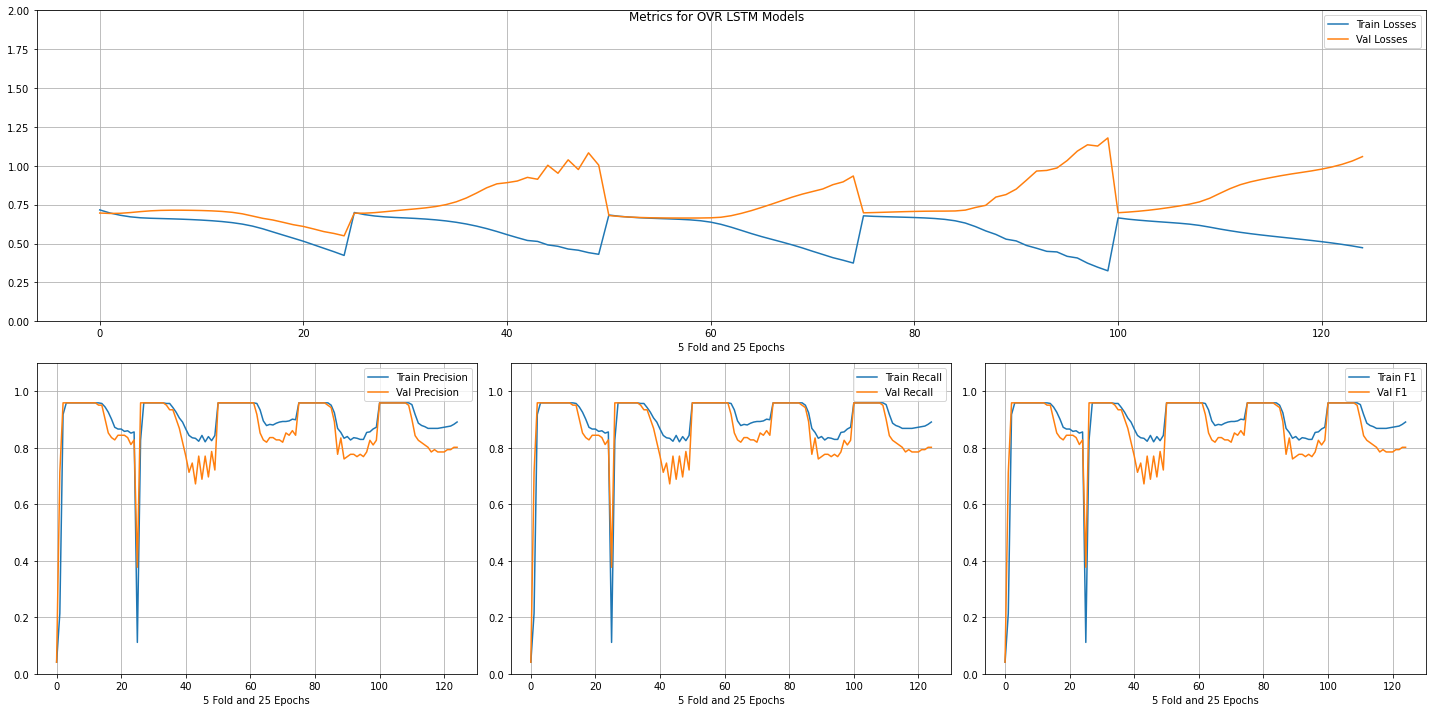

    train_f1  validation_f1  ...  train_losses  validation_losses
3   0.958848       0.959016  ...      0.671252           0.704413
10  0.958848       0.959016  ...      0.637427           0.665223
7   0.958848       0.959016  ...      0.655597           0.663850
4   0.958848       0.959016  ...      0.667554           0.710859
5   0.958848       0.959016  ...      0.664606           0.716898
..       ...            ...  ...           ...                ...
22  0.839506       0.696721  ...      0.456804           0.975965
20  0.843621       0.688525  ...      0.481926           0.951976
18  0.833333       0.672131  ...      0.513410           0.913471
0   0.111111       0.377049  ...      0.699400           0.695115
0   0.041152       0.040984  ...      0.716253           0.696157

[125 rows x 8 columns]
Training for ['Hanumatodi'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 486/122
Class Weights : [ 0.5170068 15.2      ]
Epoch 1/25 : Training Loss: 0.716 / Validation L

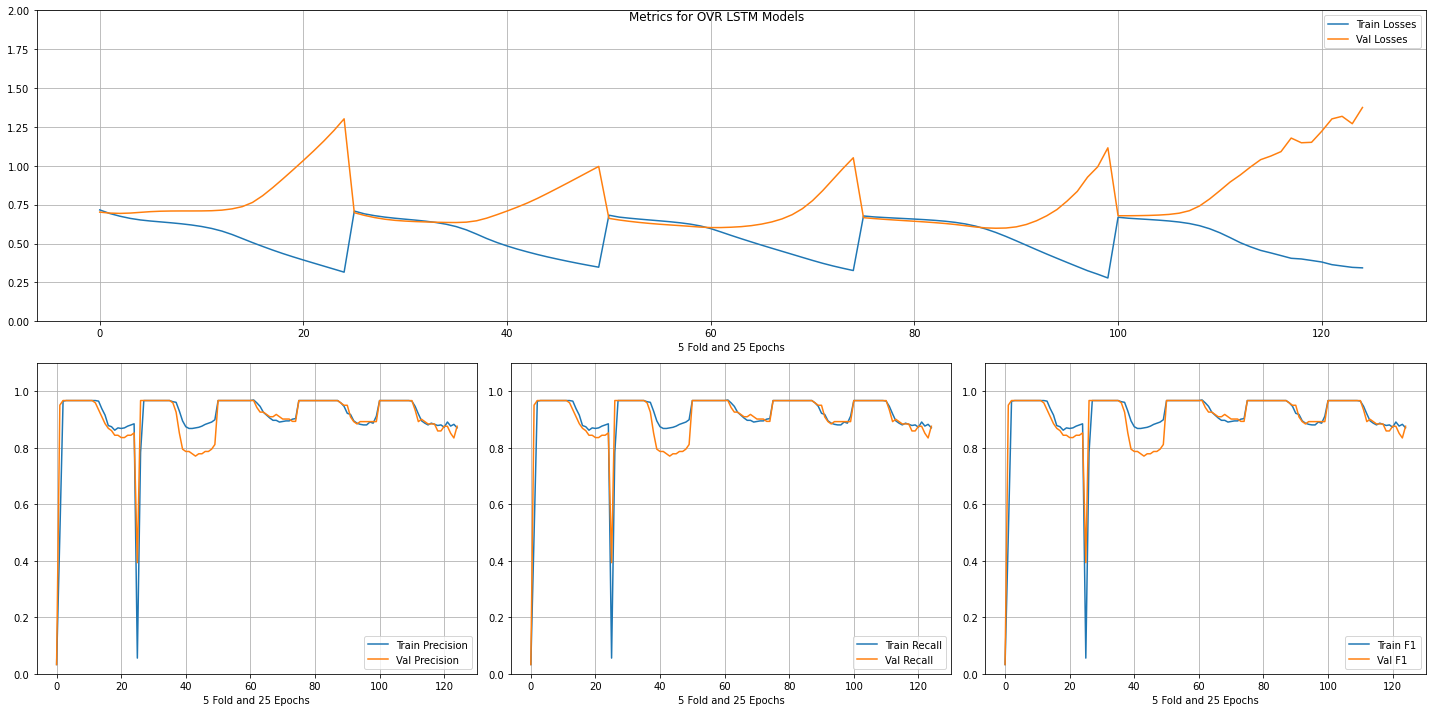

    train_f1  validation_f1  ...  train_losses  validation_losses
9   0.967078       0.967213  ...      0.612769           0.605545
6   0.967078       0.967213  ...      0.640020           0.619381
5   0.967078       0.967213  ...      0.645841           0.623941
11  0.969136       0.967213  ...      0.574407           0.602593
10  0.967078       0.967213  ...      0.595928           0.602425
..       ...            ...  ...           ...                ...
19  0.872428       0.778689  ...      0.413312           0.823563
20  0.876543       0.778689  ...      0.398830           0.857214
18  0.870370       0.770492  ...      0.428919           0.790841
0   0.055556       0.393443  ...      0.708736           0.698137
0   0.032922       0.032787  ...      0.716180           0.701907

[125 rows x 8 columns]
Training for ['Harikambhoji'] with 66 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 486/122
Class Weights : [0.56088561 4.60606061]
Epoch 1/25 : Training Loss: 0.699 / Validation

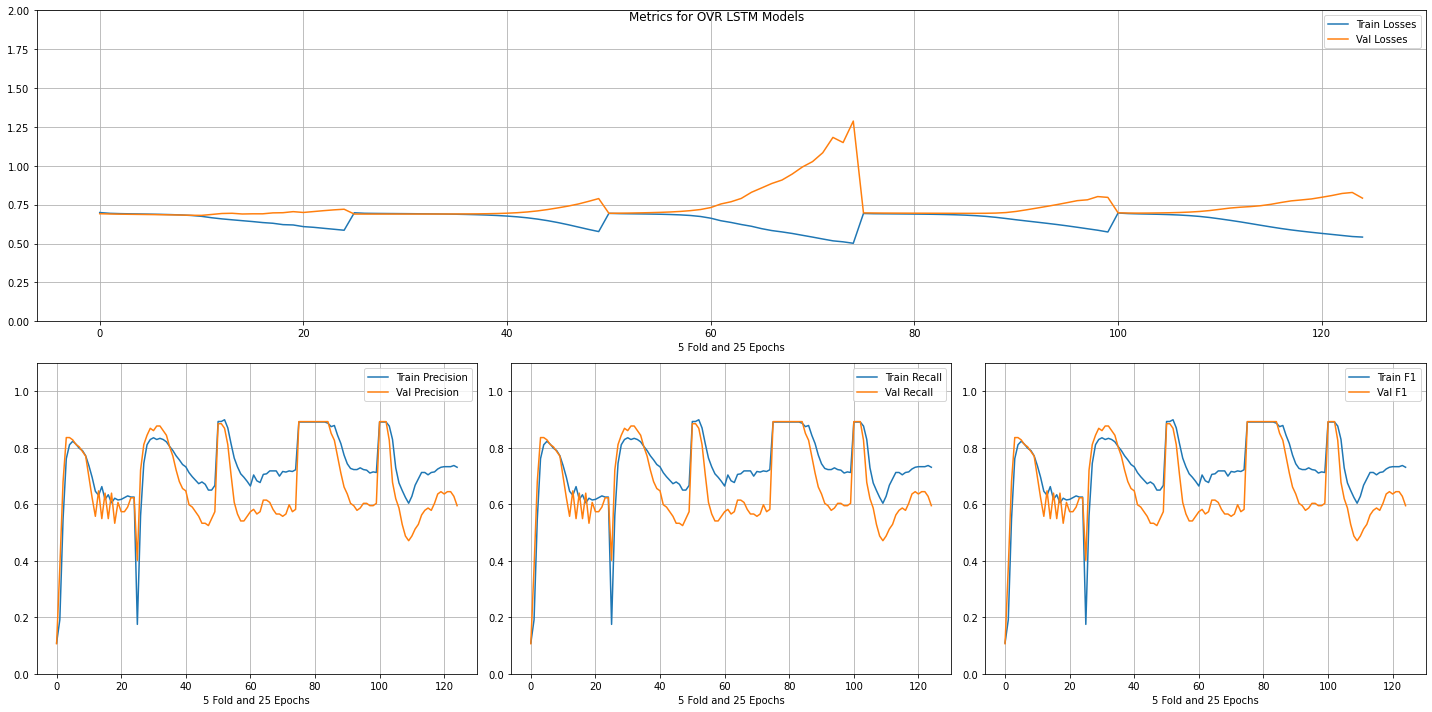

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.891170       0.892562  ...      0.693208           0.696860
3   0.891170       0.892562  ...      0.690615           0.695529
1   0.891170       0.892562  ...      0.691677           0.696285
8   0.891170       0.892562  ...      0.686506           0.694433
7   0.891170       0.892562  ...      0.687767           0.694644
..       ...            ...  ...           ...                ...
8   0.624230       0.487603  ...      0.674257           0.706083
9   0.603696       0.471074  ...      0.667216           0.712004
0   0.174897       0.401639  ...      0.697767           0.689430
1   0.191358       0.377049  ...      0.694137           0.689860
0   0.109053       0.106557  ...      0.699301           0.691682

[125 rows x 8 columns]
Training for ['Jhalavarali'] with 22 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 486/122
Class Weights : [ 0.51877133 13.81818182]
Epoch 1/25 : Training Loss: 0.710 / Validatio

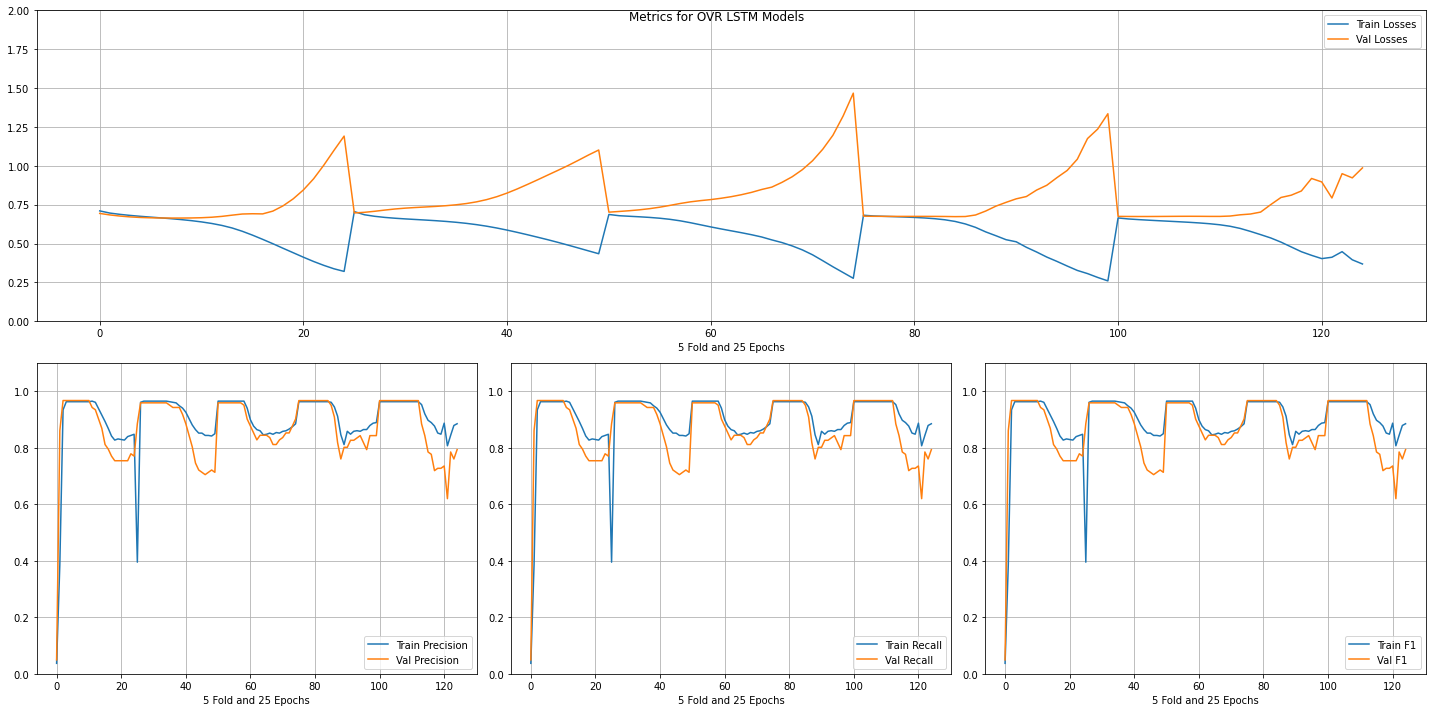

    train_f1  validation_f1  ...  train_losses  validation_losses
8   0.962963       0.967213  ...      0.653843           0.663771
2   0.934156       0.967213  ...      0.687406           0.676482
3   0.962963       0.967213  ...      0.680639           0.671101
4   0.962963       0.967213  ...      0.674895           0.667481
5   0.962963       0.967213  ...      0.669759           0.665311
..       ...            ...  ...           ...                ...
22  0.843621       0.713115  ...      0.471092           1.035308
24  0.849794       0.713115  ...      0.434147           1.101606
21  0.843621       0.704918  ...      0.489404           1.002052
21  0.806982       0.619835  ...      0.411451           0.792953
0   0.037037       0.049180  ...      0.709898           0.693582

[125 rows x 8 columns]
Training for ['Kalyani'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 486/122
Class Weights : [ 0.50921273 27.63636364]
Epoch 1/25 : Training Loss: 0.715 / Validation Lo

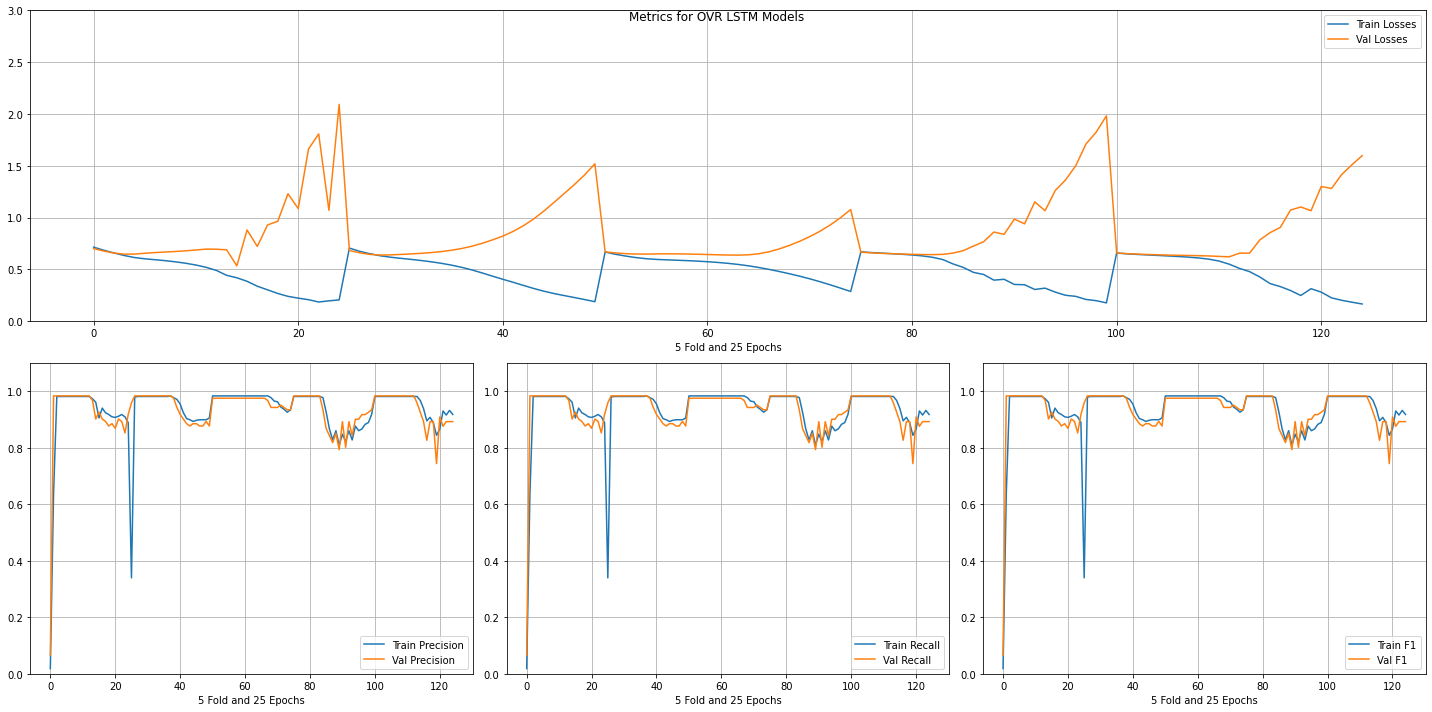

    train_f1  validation_f1  ...  train_losses  validation_losses
3   0.981481       0.983607  ...      0.631984           0.638546
12  0.981481       0.983607  ...      0.490141           0.694833
4   0.981481       0.983607  ...      0.617908           0.640003
7   0.981481       0.983607  ...      0.585891           0.655080
2   0.981481       0.983607  ...      0.651159           0.644732
..       ...            ...  ...           ...                ...
12  0.827515       0.818182  ...      0.450746           0.767140
16  0.821355       0.801653  ...      0.351897           0.939772
14  0.809035       0.793388  ...      0.404479           0.838469
19  0.843943       0.743802  ...      0.313647           1.066880
0   0.018519       0.065574  ...      0.714536           0.700259

[125 rows x 8 columns]
Training for ['Kharaharapriya'] with 135 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 486/122
Class Weights : [0.64270613 2.25185185]
Epoch 1/25 : Training Loss: 0.701 / Validat

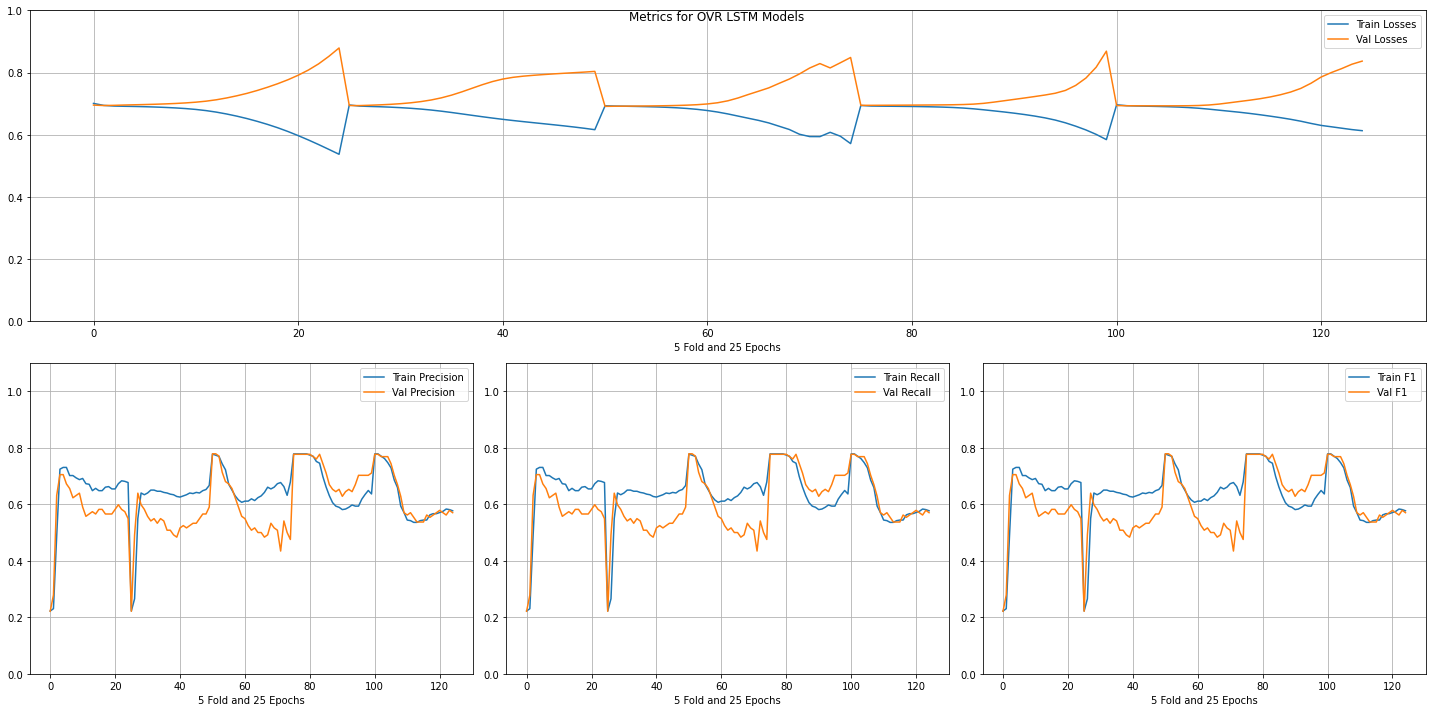

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.773663       0.778689  ...      0.692174           0.691644
0   0.777778       0.778689  ...      0.693032           0.691244
1   0.778234       0.776860  ...      0.693330           0.693242
2   0.778234       0.776860  ...      0.691890           0.694729
3   0.778234       0.776860  ...      0.691587           0.694912
..       ...            ...  ...           ...                ...
24  0.679012       0.475410  ...      0.571458           0.848511
21  0.676955       0.434426  ...      0.593902           0.828916
1   0.230453       0.278689  ...      0.694330           0.693918
0   0.222222       0.221311  ...      0.695677           0.693890
0   0.222222       0.221311  ...      0.700697           0.695304

[125 rows x 8 columns]
Training for ['Naganandini'] with 89 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 486/122
Class Weights : [0.58574181 3.41573034]
Epoch 1/25 : Training Loss: 0.700 / Validation 

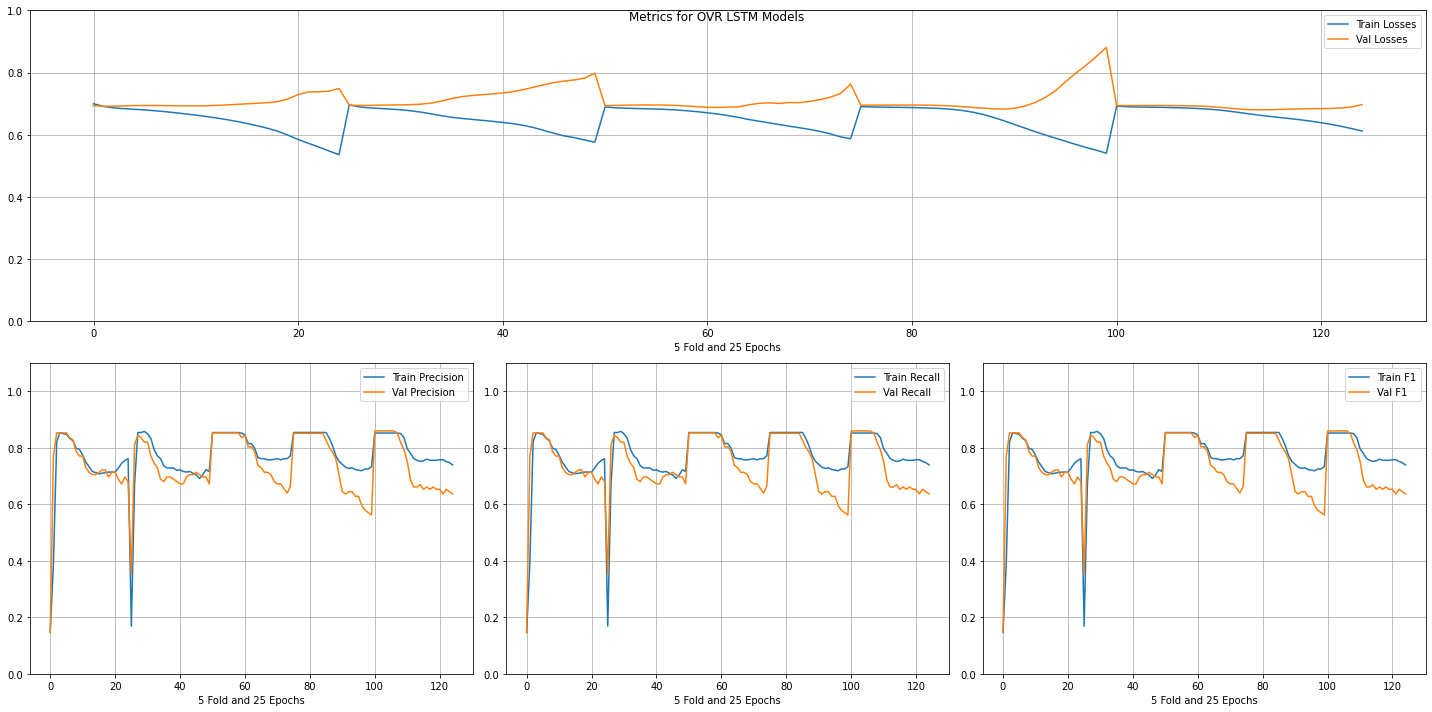

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.852156       0.859504  ...      0.690053           0.693735
0   0.852156       0.859504  ...      0.692053           0.693837
6   0.852156       0.859504  ...      0.686739           0.693475
5   0.852156       0.859504  ...      0.687556           0.693697
4   0.852156       0.859504  ...      0.688225           0.693783
..       ...            ...  ...           ...                ...
22  0.724846       0.578512  ...      0.559302           0.823047
23  0.724846       0.570248  ...      0.550248           0.851026
24  0.733060       0.561983  ...      0.540520           0.880955
0   0.168724       0.352459  ...      0.695787           0.695415
0   0.146091       0.147541  ...      0.699750           0.693440

[125 rows x 8 columns]
Training for ['Natabhairavi'] with 27 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 486/122
Class Weights : [ 0.5232358  11.25925926]
Epoch 1/25 : Training Loss: 0.698 / Validati

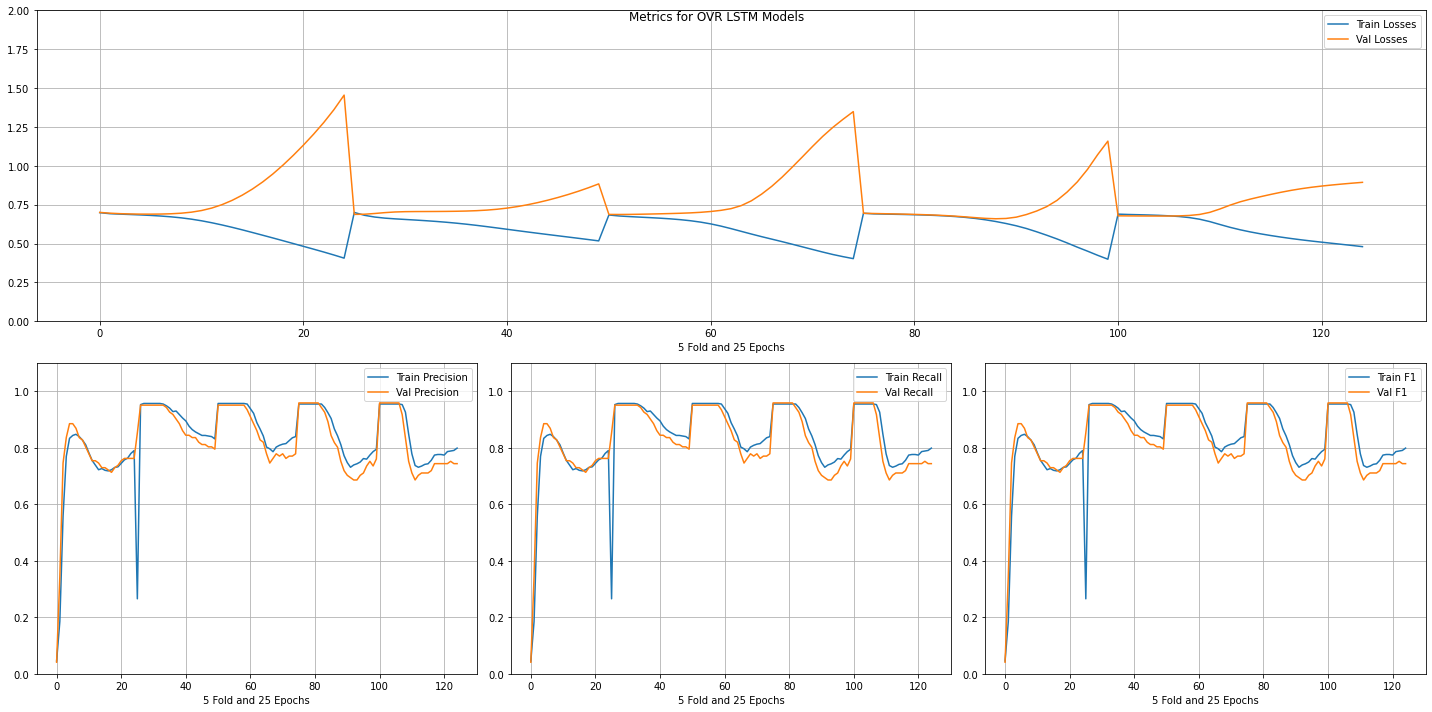

    train_f1  validation_f1  ...  train_losses  validation_losses
5   0.954825       0.958678  ...      0.678095           0.676873
3   0.954825       0.958678  ...      0.688055           0.690326
5   0.954825       0.958678  ...      0.685186           0.687274
6   0.954825       0.958678  ...      0.683262           0.685310
2   0.954825       0.958678  ...      0.689292           0.691663
..       ...            ...  ...           ...                ...
11  0.737166       0.685950  ...      0.604041           0.746814
17  0.739220       0.685950  ...      0.575575           0.708844
18  0.743326       0.685950  ...      0.553162           0.737496
1   0.185185       0.344262  ...      0.691868           0.695067
0   0.045267       0.040984  ...      0.698463           0.700155

[125 rows x 8 columns]
Training for ['Shankarabharanam'] with 136 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 486/122
Class Weights : [0.6440678  2.23529412]
Epoch 1/25 : Training Loss: 0.697 / Valid

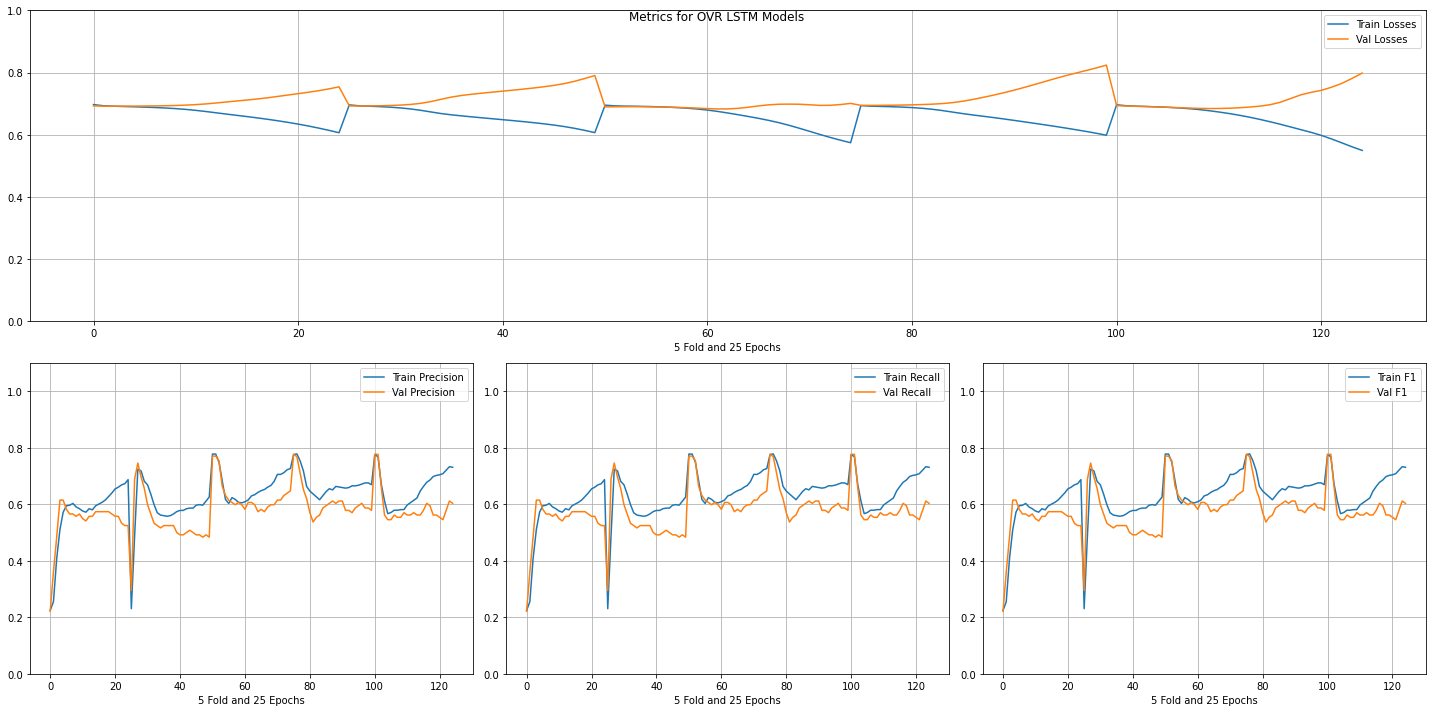

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.767967       0.776860  ...      0.693088           0.692227
0   0.776181       0.776860  ...      0.693645           0.694521
0   0.776181       0.776860  ...      0.696316           0.693678
1   0.777778       0.770492  ...      0.692742           0.689786
0   0.777778       0.770492  ...      0.695024           0.689438
..       ...            ...  ...           ...                ...
24  0.625514       0.483607  ...      0.606692           0.790319
2   0.407407       0.483607  ...      0.691703           0.691778
1   0.255144       0.360656  ...      0.693074           0.691882
0   0.230453       0.295082  ...      0.695989           0.692829
0   0.224280       0.221311  ...      0.696916           0.692797

[125 rows x 8 columns]
Training for ['Shubhapantuvarali'] with 32 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 486/122
Class Weights : [0.52777778 9.5       ]
Epoch 1/25 : Training Loss: 0.716 / Valid

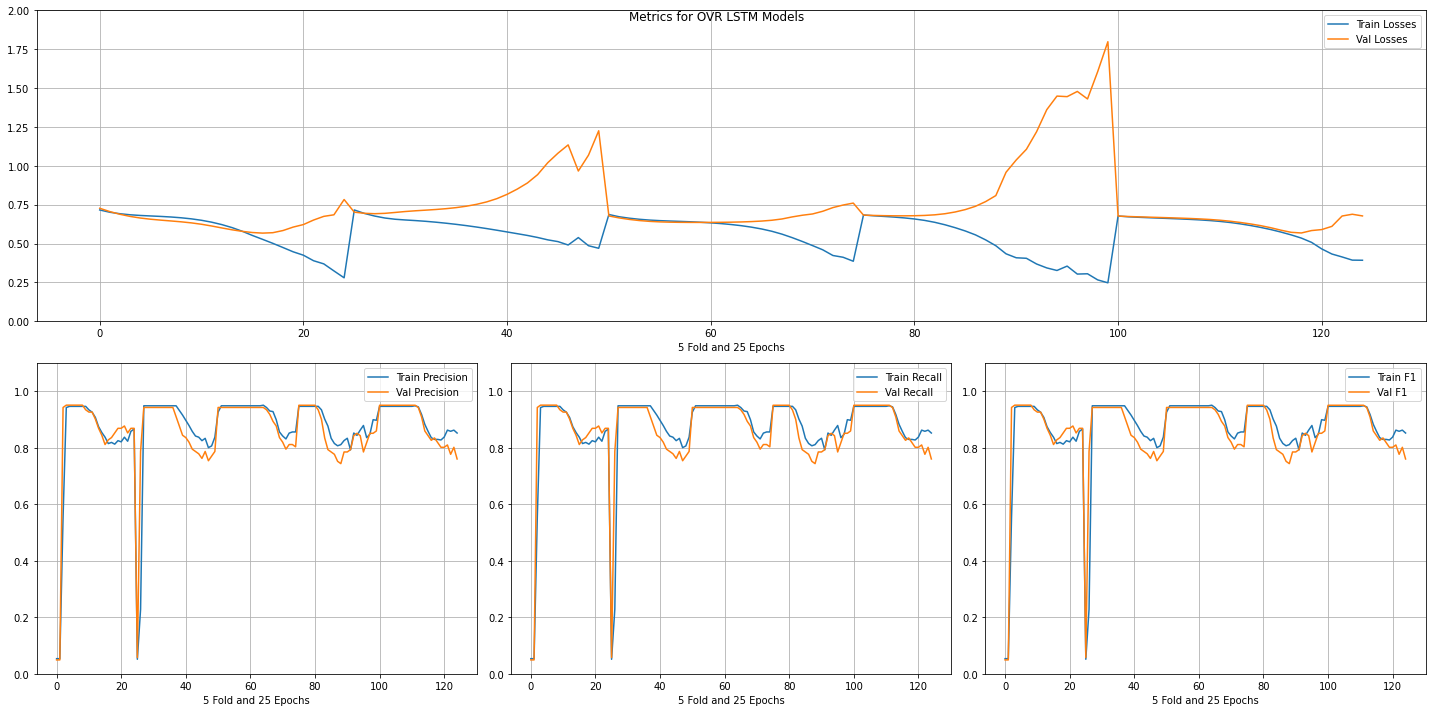

    train_f1  validation_f1  ...  train_losses  validation_losses
3   0.942387       0.950820  ...      0.684749           0.674141
4   0.946502       0.950820  ...      0.680353           0.663801
5   0.946502       0.950820  ...      0.677231           0.656193
6   0.946502       0.950820  ...      0.674239           0.650300
7   0.946502       0.950820  ...      0.670505           0.645049
..       ...            ...  ...           ...                ...
12  0.806982       0.752066  ...      0.523146           0.769768
13  0.811088       0.743802  ...      0.485530           0.808493
0   0.051440       0.057377  ...      0.715829           0.701671
1   0.053498       0.049180  ...      0.701004           0.705156
0   0.053498       0.049180  ...      0.715808           0.726805

[125 rows x 8 columns]
Training for ['Vakulabharanam'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 486/122
Class Weights : [0.53996448 6.75555556]
Epoch 1/25 : Training Loss: 0.711 / Validati

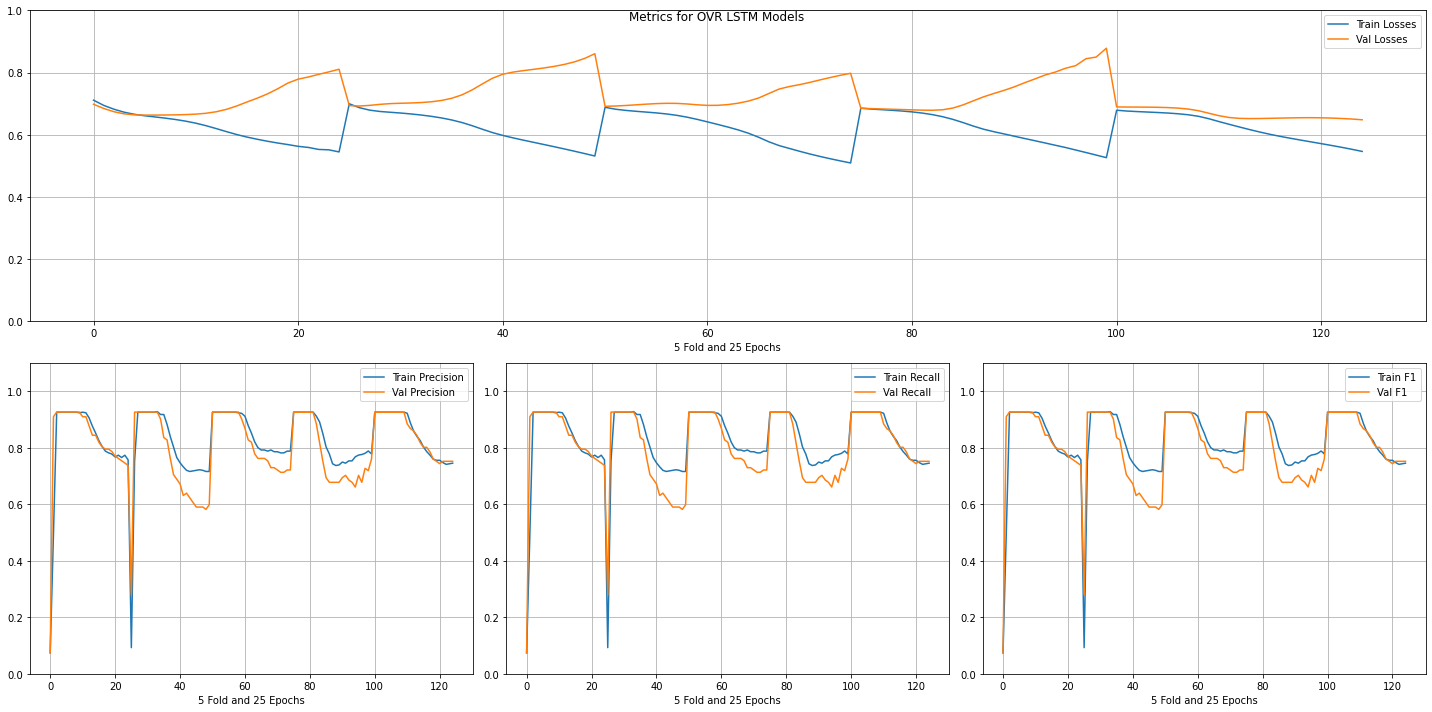

    train_f1  validation_f1  ...  train_losses  validation_losses
4   0.925926       0.926230  ...      0.672236           0.700077
1   0.753086       0.926230  ...      0.686875           0.692289
7   0.925926       0.926230  ...      0.662417           0.700810
6   0.925926       0.926230  ...      0.666856           0.701083
5   0.925926       0.926230  ...      0.670183           0.700088
..       ...            ...  ...           ...                ...
21  0.722222       0.590164  ...      0.554387           0.826048
22  0.720165       0.590164  ...      0.546982           0.834294
23  0.716049       0.581967  ...      0.539346           0.845412
0   0.092593       0.278689  ...      0.699543           0.693653
0   0.074074       0.073770  ...      0.711193           0.698097

[125 rows x 8 columns]


In [44]:
jovr_res_reduced = ovr_train_model_lstm(rdata, ChromaJanakaRagaDataset, ChromaLstmModel, "OVR LSTM Models", jlabels1, cl, lbl_encoder=jle, 
                                        target='JanakaRagamCode', feature='chroma', epochs=25, lr=1e-3, k_folds=5)

In [45]:
for k in jovr_res_reduced:
  print(jle.inverse_transform([k]))
  print(results_to_df(jovr_res_reduced[k]).head())

['Chalanata']
    train_f1  validation_f1  ...  train_losses  validation_losses
3   0.958848       0.959016  ...      0.671252           0.704413
10  0.958848       0.959016  ...      0.637427           0.665223
7   0.958848       0.959016  ...      0.655597           0.663850
4   0.958848       0.959016  ...      0.667554           0.710859
5   0.958848       0.959016  ...      0.664606           0.716898

[5 rows x 8 columns]
['Hanumatodi']
    train_f1  validation_f1  ...  train_losses  validation_losses
9   0.967078       0.967213  ...      0.612769           0.605545
6   0.967078       0.967213  ...      0.640020           0.619381
5   0.967078       0.967213  ...      0.645841           0.623941
11  0.969136       0.967213  ...      0.574407           0.602593
10  0.967078       0.967213  ...      0.595928           0.602425

[5 rows x 8 columns]
['Harikambhoji']
   train_f1  validation_f1  ...  train_losses  validation_losses
0   0.89117       0.892562  ...      0.693208        